# Motivated Sampling and Bayesian Learning - Simulation Models

In [1]:
import pandas as pd
import numpy as np
import random as rd
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import optuna
from functools import partial
from hyperopt import fmin, tpe, hp, Trials
from deap import base, creator, tools, algorithms
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Sampling Behavior Learning Models - Reinforcement Learning

The following code represents a simulation model where agents learn the optimal sample size that maximizes their reward

### Agent Classes

#### Base Agent Class

Class that defines an interface with the methods that all agents must implement

Bayes decision rule update:
\begin{equation}
    P(HL\mid X) = \frac{ P(X\mid HL)P(HL)}{P(X\mid HL)P(HL) + P(X\mid LH)P(LH)}
\end{equation}

In [2]:
class Agent:
    def __init__(self, population, p_high, p_low):
        self.population = population
        self.p_high = p_high
        self.p_low = p_low
        
    # Bayes posterior - shared across all agents
    def mod_bayesian_update(self, sample_left, sample_right, prior_left):
        population_list = self.population.tolist()
        if len(sample_left) == 0 and len(sample_right) == 0:
            P_HL_X = 0.5
        else:
            sample_left_high = [self.p_high[population_list.index(i)] for i in sample_left]
            sample_right_low = [self.p_low[population_list.index(i)] for i in sample_right]
            sample_left_low = [self.p_low[population_list.index(i)] for i in sample_left]
            sample_right_high = [self.p_high[population_list.index(i)] for i in sample_right]
            P_X_HL = np.product(sample_left_high + sample_right_low)
            P_X_LH = np.product(sample_left_low + sample_right_high)
            prior_right = 1 - prior_left
            P_HL_X = P_X_HL * prior_left / (P_X_HL * prior_left + P_X_LH * prior_right)
        return P_HL_X

    def prob_gen_list(self, computer):
        return None
    
    def select_action(self, computer):
        raise NotImplementedError()

    def update_beliefs(self, action, payoff, computer):
        raise NotImplementedError()

    def get_agent_data(self):
        raise NotImplementedError()

#### Agent Class: ABRL Softmax Agent

The ABRLSoftmaxAgent class represents an agent that uses the ABRL (Attraction-Based Reinforcement Learning) with Softmax algorithm to make decisions in an environment. 

Components: 

Attraction update: 
\begin{equation} A_{s_i}(n) = \phi A_{s_i}(n-1) + I(s(n)=s_i) \pi_{s_i}(n) \end{equation}

Softmax decision rule: 
\begin{equation}
P_{s_i}(n+1) = \frac{e^{\lambda A_{s_i}(n)}}{\sum_{k=1}^{m}e^{\lambda A_{s_k}(n)}}
\end{equation}

Where $s$ = sample size selection action, $n$ = period, and $\pi$ is the payoff connected to an action. 

Parameter definitions: 
 - $\phi$ (phi): Recency parameter, discount rate for attractions, weighting the importance of past experiences.
 - $\lambda$ (lam): Softmax update weight, or sensitivity parameter (weight of attractions). If $\lambda=0$, attractions are irrelevant. If $\lambda$ is large, attractions are important.

In [3]:
class ABRLSoftmaxAgent(Agent):
    def __init__(self, max_samples, phi, lam, population, p_high, p_low):
        super().__init__(population, p_high, p_low)  # Call the constructor of the base class
        self.max_samples = max_samples
        self.phi = phi
        self.lam = lam
        self.attractions = {'left': [0] * max_samples, 'right': [0] * max_samples} # initialize attractions tables
        self.payoffs_sample = {'left': [0] * max_samples, 'right': [0] * max_samples} # initialize payoffs tables

    def prob_gen_list(self, computer): # softmax function (logit transformation)
        attractions = self.attractions[computer]
        max_a = max(attractions)
        exps = [np.exp(self.lam * (a - max_a)) for a in attractions]
        sum_exps = sum(exps)
        probs_list = [exp_a / sum_exps for exp_a in exps]
        return probs_list

    def select_action(self, computer): # sample_size_selection_function
        probabilities_list = self.prob_gen_list(computer)
        pop = list(range(0, self.max_samples))
        strat_i = rd.choices(population=pop, weights=probabilities_list, k=1)
        return strat_i[0]

    def reinforcement_learning_update(self, payoffs_list, attractions): # abrl update method (attractions)
        new_attractions_list = []
        for (a, p) in zip(attractions, payoffs_list):
            a_new = self.phi * a + p
            new_attractions_list.append(a_new)
        return new_attractions_list

    def update_beliefs(self, action, payoff, computer): # update action
        self.payoffs_sample[computer][action] = payoff
        self.attractions[computer] = self.reinforcement_learning_update(self.payoffs_sample[computer], 
                                                                        self.attractions[computer])

    def get_agent_data(self): # storing probabilities and attractions lists
        return {
            'probs_list': {computer: self.prob_gen_list(computer) for computer in ['left', 'right']},
            'attractions': self.attractions,
        }

#### Agent Class: ABRL Softmax Agent with the $\epsilon$-Greedy Strategy

The ABRLSoftmaxBanditAgent class is similar to the ABRLSoftmaxAgent class, but it introduces an epsilon-greedy exploration strategy. This allows the agent to balance exploration and exploitation during decision-making by gradually decreasing the exploration rate ($\epsilon$) over time

The $\epsilon$-greedy approach in this agent allows to balance between exploration and exploitation, where exploration is a random choice and exploitation is the softmax rule: 

\begin{equation}
s_i(n) =
\begin{cases}
\text{random action} & \text{with probability } \epsilon \\
\text{softmax rule} & \text{with probability }  1-\epsilon
\end{cases}
\end{equation}

Parameter definitions: 
 - $\phi$ (phi): Recency parameter, discount rate for attractions, weighting the importance of past experiences.
 - $\lambda$ (lam): Softmax update weight, or sensitivity parameter (weight of attractions). If $\lambda=0$, attractions are irrelevant. If $\lambda$ is large, attractions are important.
 - $\epsilon$ (epsilon): Exploration and exploitattion balance, defines the probability of choosing a random action. $\epsilon$-start and $\epsilon$-end are initial and final values of epsilon, and $\epsilon$-decay governs the rate at which $\epsilon$ decreases from start to end.

In [4]:
class ABRLSoftmaxBanditAgent(Agent):
    def __init__(self, max_samples, phi, lam, population, p_high, p_low, epsilon_start, epsilon_end, epsilon_decay):
        super().__init__(population, p_high, p_low)
        self.max_samples = max_samples
        self.phi = phi
        self.lam = lam
        self.attractions = {'left': [0] * max_samples, 'right': [0] * max_samples}
        self.payoffs_sample = {'left': [0] * max_samples, 'right': [0] * max_samples}
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

    def prob_gen_list(self, computer):  # softmax
        attractions = self.attractions[computer]
        max_a = max(attractions)
        exps = [np.exp(self.lam * (a - max_a)) for a in attractions]
        sum_exps = sum(exps)
        probs_list = [exp_a / sum_exps for exp_a in exps]
        return probs_list

    def select_action(self, computer):  # epsilon-greedy version of select action - exploration/exploitation tradeoff
        if np.random.rand() <= self.epsilon:  # exploration
            strat_i = np.random.choice(range(self.max_samples), 1).item()
        else:  # exploitation
            probabilities_list = self.prob_gen_list(computer)
            pop = list(range(0, self.max_samples))
            strat_i = rd.choices(population=pop, weights=probabilities_list, k=1)[0]
        return strat_i

    def reinforcement_learning_update(self, payoffs_list, attractions):  # abrl 
        new_attractions_list = []
        for (a, p) in zip(attractions, payoffs_list):
            a_new = self.phi * a + p
            new_attractions_list.append(a_new)
        return new_attractions_list

    def update_beliefs(self, action, payoff, computer): # abrl update
        self.payoffs_sample[computer][action] = payoff
        self.attractions[computer] = self.reinforcement_learning_update(self.payoffs_sample[computer],
                                                                        self.attractions[computer])
        # Decay epsilon 
        if self.epsilon > self.epsilon_end:
            self.epsilon *= self.epsilon_decay

    def get_agent_data(self):
        return {
            'probs_list': {computer: self.prob_gen_list(computer) for computer in ['left', 'right']},
            'attractions': self.attractions,
        }

#### Agent Class: UCBS Agent

The UCBSBanditAgent class implements the UCB (Upper Confidence Bound) algorithm to balance exploration and exploitation in the multi-armed bandit problem. By considering both the empirical average rewards and the confidence bounds, it aims to select arms that are likely to provide higher rewards while exploring less explored arms.

Components:

Select action: 
\begin{equation}
s_i(n) = \arg \max_s \left[ Q(s) + \sqrt{\frac{2 \log N}{n(s)}} \right]
\end{equation}


Update beliefs
\begin{equation}
Q_{n+1}(s) = Q_n(s) + \frac{1}{n(s)} \left[ R_n(s) - Q_n(s) \right]
\end{equation}

Generate UCB values
\begin{equation}
UCB(s) = Q(s) + \sqrt{\frac{2 \log N}{n(s)}}
\end{equation}

In [5]:
class UCBSBanditAgent(Agent):
    def __init__(self, max_samples, population, p_high, p_low):
        super().__init__(population, p_high, p_low)
        self.max_samples = max_samples
        self.counts = {'left': np.zeros(max_samples + 1), 'right': np.zeros(max_samples + 1)}
        self.values = {'left': np.zeros(max_samples + 1), 'right': np.zeros(max_samples + 1)}

    def select_action(self, computer):
        if np.min(self.counts[computer]) == 0:  # If there are any arms we haven't tried yet, try one of them
            return np.argmin(self.counts[computer])
        total_counts = np.sum(self.counts[computer])
        ucb_values = self.values[computer] + np.sqrt((2 * np.log(total_counts)) / self.counts[computer])
        return np.argmax(ucb_values)
  
    def update_beliefs(self, action, payoff, computer):
        self.counts[computer][action] += 1
        n = self.counts[computer][action]
        value = self.values[computer][action]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * payoff
        self.values[computer][action] = new_value

    def get_ucb_values(self, computer):
        total_counts = np.sum(self.counts[computer])
        ucb_values = self.values[computer] + np.sqrt((2 * np.log(total_counts)) / self.counts[computer])
        return ucb_values

    def get_agent_data(self):
        ucb_values = {'left': self.get_ucb_values('left'), 'right': self.get_ucb_values('right')}
        relative_probabilities = {'left': ucb_values['left'] / np.sum(ucb_values['left']), 
                                  'right': ucb_values['right'] / np.sum(ucb_values['right'])}
        return {
            'ucb_values': ucb_values,
            'relative_probabilities': relative_probabilities,
            'values': self.values,
            'counts': self.counts,
        }

#### Agent Class: Random Sampling Agent

An agent that takes only random samples, for benchmarking purposes. 

In [6]:
class RandomSamplingAgent(Agent):
    def __init__(self, max_samples, population, p_high, p_low):
        super().__init__(population, p_high, p_low)  
        self.max_samples = max_samples

    def prob_gen_list(self, computer): # unbiased random generations (uniform probabilities)
        return [1/self.max_samples]*self.max_samples

    def select_action(self, computer): # random sample size selection
        strat_i = np.random.choice(range(self.max_samples), 1).item()
        return strat_i

    def update_beliefs(self, action, payoff, computer): # this agent has no beliefs
        pass 

    def get_agent_data(self):
        return {}  

### Environment Class: Experimental Task

The environment in which the agent operates. It is responsible for generating distributions, sampling from the distributions, and calculating the reward based on the selected computer and the total number of samples.

Reward function:
\begin{equation}
R = P + E - C \times T
\end{equation}

The externalities are handled as: 
\begin{equation}
E =
\begin{cases}
+E & \text{if the answer is correct and externality is positive} \\
-E \times 2 & \text{if the answer incorrect and externality is negative} \\
0 & \text{otherwise}
\end{cases}
\end{equation}

Where $P$ is the payoff for the round, $E$ is the externality value, $C$ is the sample cost and $T$ is the total sample size.

In [7]:
class Environment:
    def __init__(self, array_length, population, p_high, p_low, sample_cost, payoff_base, ext_cost, externality_type):
        self.array_length = array_length
        self.population = population
        self.p_high = p_high
        self.p_low = p_low
        self.sample_cost = sample_cost
        self.payoff_base = payoff_base
        self.high_dist = self.linear_distribution(self.p_high)
        self.low_dist = self.linear_distribution(self.p_low)
        self.externality = externality_type
        self.externality_computer = None
        self.ext_cost = ext_cost
        self.correct_array = None
        self.dist_list = None
        self.dist_dict = None
        self.generate_distributions()       

    def linear_distribution(self, p_dist): # generates linear distributions for high and low
        i = 0
        (temp_array, final_array) = ([], [])
        for i in range(len(self.population)):
            count = round(self.array_length * p_dist[i])
            temp_array = np.repeat(self.population[i], count)
            final_array.extend(temp_array)
            i += 1
        return final_array
    
    def generate_distributions(self): # creating the computers
        self.dist_list = [self.high_dist, self.low_dist]
        rd.shuffle(self.dist_list)
        self.dist_dict = {'left': self.dist_list[0], 'right': self.dist_list[1]}
        self.correct_array = 'left' if self.dist_dict['left'] == self.high_dist else 'right'
        self.generate_externalities()

    def generate_externalities(self): # creating the externalities (50/50 probabilities)
        self.externality_computer = np.random.choice(['left', 'right'])

    def sample(self, computer, sample_size): # sampling action
        return np.random.choice(self.dist_dict[computer], sample_size)
    
    def get_reward(self, selected_computer, total_samples): # defining reward for the agent given the scenario
        correct_answer = (selected_computer == self.correct_array)
        payoff_round = self.payoff_base if correct_answer else 0
        externality_realized = 0
        if selected_computer == self.externality_computer:
            if self.externality == 'positive' and correct_answer:
                payoff_round += self.ext_cost
                externality_realized = 1
            elif self.externality == 'negative' and not correct_answer:
                payoff_round -= (self.ext_cost * 2) # prospect theory loss aversion
                externality_realized = 1

        reward = payoff_round - (self.sample_cost * total_samples)
        return reward, externality_realized

### Simulation Class: Execution

The simulation class orchestrates the actions between the agents and the environment over multiple periods. 

In [8]:
class Simulation:
    def __init__(self, n_sims, n_periods, env, agent, sample_cost, prior):
        self.n_sims = n_sims
        self.n_periods = n_periods
        self.env = env
        self.agent = agent
        self.sample_cost = sample_cost
        self.payoff_base = env.payoff_base
        self.prior = prior
        self.externality_type = env.externality
        self.data = []

    def run(self):
        
        for sim_nr in range(self.n_sims):
            
            cum_reward = 0

            for period in range(self.n_periods):
                
                self.env.generate_distributions() # create computers
                self.env.generate_externalities() # create externalities
                
                # update probabilities
                probs_list = { 
                    'left': self.agent.prob_gen_list('left'),
                    'right': self.agent.prob_gen_list('right')
                }
                
                # select a sample size for each computer
                selected_sample_sizes = {
                    'left': self.agent.select_action('left'),
                    'right': self.agent.select_action('right')
                }
                
                # sampling action
                samples_dict = {
                    'left': self.env.sample('left', selected_sample_sizes['left']),
                    'right': self.env.sample('right', selected_sample_sizes['right'])
                }
                
                samples_left = samples_dict['left']
                samples_right = samples_dict['right']
                scount_left = len(samples_left)
                scount_right = len(samples_right)
                
                total_samples = sum(selected_sample_sizes.values())
                
                # Bayes posterior
                posterior_left = self.agent.mod_bayesian_update(
                    samples_dict['left'],
                    samples_dict['right'],
                    self.prior
                )
                
                posterior_right = 1 - posterior_left

                if np.random.uniform(0, 1) < posterior_left:
                    selected_computer = 'left'
                else:
                    selected_computer = 'right'
                
                # distribute rewards
                reward, externality_realized = self.env.get_reward(selected_computer, total_samples)
                cum_reward += reward

                correct_answer = (selected_computer == self.env.correct_array)
                
                # update RL method
                for computer in ['left', 'right']:
                    self.agent.update_beliefs(selected_sample_sizes[computer], reward, computer)
                    
                sample_cost_round = total_samples * self.sample_cost
                
                # store simulation data
                self.data.append({
                    'sim_nr': sim_nr,
                    'period': period,
                    'correct_answer': correct_answer,
                    'scount_left':scount_left,
                    'scount_right':scount_right,
                    'total_samples': total_samples,
                    'sample_cost_round':sample_cost_round,
                    'posterior_left':posterior_left,
                    'posterior_right':posterior_right,
                    'selected_computer': selected_computer,
                    'reward': reward,
                    'cum_reward': cum_reward,
                    'probs_list_left': probs_list['left'],
                    'probs_list_right': probs_list['right'],
                    'samples_left':samples_left,
                    'samples_right':samples_right,
                    'externality_computer': self.env.externality_computer,
                    'externality_realized': externality_realized,
                    'externality_type': self.externality_type
                })

        print('Simulation Finished')
        return pd.DataFrame(self.data)

#### Global Parameters

Parameter values used in all simulation runs

In [46]:
# Environment Class Parameters
array_length = 100 # lenght of the low and high distribution arrays
p_high = [0.08, 0.09, 0.10, 0.12, 0.13, 0.14, 0.16, 0.18] # high numbers distribution
p_low = list(reversed(p_high)) # low numbers distribution
population = np.arange(1, (len(p_high) + 1)) # pupulating the arrays

# Simulation Parameters
n_sims = 100 # how many agents we run  per method
n_periods = 21 # how many rounds each agent
max_samples = 25 # maximum amount of samples that can be drawin in one period
sample_cost = 0.019 # cost of each sample
payoff_base = 1 # points earned for correct computer selection
prior = 0.5 # initial beliefs about left/right
ext_cost = 0.25 # externalities quantification, plus for positive and minus for negative

ntrials = 250 # optimization trials for parameter fitting

#### Hyper Parameter Tuning: ABRL Softmax Agent (Optuna)

Sequential Model-Based Optimization (SMBO) to perform the hyperparameter optimization. SMBO combines the concepts of Bayesian optimization and bandit algorithms to efficiently search the hyperparameter space.

In [47]:
%%time

phi, lam = 0, 0
# objective function for parameter fitting - softmax agent
def objective(trial, agent, sim):
    try:
        phi = trial.suggest_uniform('phi', 0, 1) # phi range
        lam = trial.suggest_uniform('lam', 0, 10) # lam range
        agent.phi = phi
        agent.lam = lam
        data = sim.run()
        target = data.groupby('sim_nr')['reward'].mean().mean() # optimization target (IMPORTANT)
        return target
    except OverflowError:
        raise optuna.TrialPruned()
        
# initialize environments
positive_env = Environment(array_length, population, p_high, p_low, sample_cost, payoff_base, ext_cost, 'positive')
negative_env = Environment(array_length, population, p_high, p_low, sample_cost, payoff_base, ext_cost, 'negative')
neutral_env = Environment(array_length, population, p_high, p_low, sample_cost, payoff_base, ext_cost, 'neutral')
# initialize agent
agent = ABRLSoftmaxAgent(max_samples, phi, lam, population, p_high, p_low)
# initialize simulations
sim_positive = Simulation(n_sims, n_periods, positive_env, agent, sample_cost, prior)
sim_negative = Simulation(n_sims, n_periods, negative_env, agent, sample_cost, prior)
sim_neutral = Simulation(n_sims, n_periods, neutral_env, agent, sample_cost, prior)
# create objetctive functions
objective_positive = partial(objective, agent=agent, sim=sim_positive)
objective_negative = partial(objective, agent=agent, sim=sim_negative)
objective_neutral = partial(objective, agent=agent, sim=sim_neutral)
# optuna study - positive externalities
study_positive = optuna.create_study(direction='maximize')
study_positive.optimize(objective_positive, n_trials=ntrials)
# optuna study - negative externalities
study_negative = optuna.create_study(direction='maximize')
study_negative.optimize(objective_negative, n_trials=ntrials)
# optuna study - neutral externalities
study_neutral = optuna.create_study(direction='maximize')
study_neutral.optimize(objective_neutral, n_trials=ntrials)

# store best parameter sets
best_params_positive = study_positive.best_params
best_params_negative = study_negative.best_params
best_params_neutral = study_neutral.best_params

# store individual parameters for each externality type
sm_best_phi_neu = best_params_neutral['phi']
sm_best_lam_neu = best_params_neutral['lam']
sm_best_phi_pos = best_params_positive['phi']
sm_best_lam_pos = best_params_positive['lam']
sm_best_phi_neg = best_params_negative['phi']
sm_best_lam_neg = best_params_negative['lam']

print("Best parameters for positive externality: ", best_params_positive)
print("Best parameters for negative externality: ", best_params_negative)
print("Best parameters for neutral externality: ", best_params_neutral)


[I 2023-06-12 15:23:35,524] A new study created in memory with name: no-name-954615e5-ae8e-4206-8091-2d4c67c28963
[I 2023-06-12 15:23:36,173] Trial 0 finished with value: 0.5753257142857144 and parameters: {'phi': 0.44818786283004575, 'lam': 6.196975949332616}. Best is trial 0 with value: 0.5753257142857144.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:23:36,711] Trial 1 finished with value: 0.5896150000000001 and parameters: {'phi': 0.4143646637784234, 'lam': 6.035031047127991}. Best is trial 1 with value: 0.5896150000000001.
[I 2023-06-12 15:23:37,262] Trial 2 finished with value: 0.5856292063492065 and parameters: {'phi': 0.16568312616791325, 'lam': 8.025446041549628}. Best is trial 1 with value: 0.5896150000000001.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:23:37,847] Trial 3 finished with value: 0.5964930952380951 and parameters: {'phi': 0.842882513628718, 'lam': 2.503670195448593}. Best is trial 3 with value: 0.5964930952380951.
[I 2023-06-12 15:23:38,397] Trial 4 finished with value: 0.6034589523809523 and parameters: {'phi': 0.688400220047232, 'lam': 5.1260671516613945}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:23:39,003] Trial 5 finished with value: 0.5857400793650793 and parameters: {'phi': 0.3414276640062526, 'lam': 1.1152688797520771}. Best is trial 4 with value: 0.6034589523809523.
[I 2023-06-12 15:23:39,568] Trial 6 finished with value: 0.5840734693877553 and parameters: {'phi': 0.5682937402910208, 'lam': 5.268133246092129}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:23:40,158] Trial 7 finished with value: 0.5841946428571426 and parameters: {'phi': 0.12885692301196194, 'lam': 8.657280700985075}. Best is trial 4 with value: 0.6034589523809523.
[I 2023-06-12 15:23:40,773] Trial 8 finished with value: 0.5842074074074074 and parameters: {'phi': 0.9462585223853481, 'lam': 8.553184649418714}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:23:41,383] Trial 9 finished with value: 0.576884761904762 and parameters: {'phi': 0.31645885693116227, 'lam': 2.5958411585736685}. Best is trial 4 with value: 0.6034589523809523.
[I 2023-06-12 15:23:42,179] Trial 10 finished with value: 0.5796656277056279 and parameters: {'phi': 0.6845298800162086, 'lam': 3.9163027790093956}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:23:42,850] Trial 11 finished with value: 0.5826701587301588 and parameters: {'phi': 0.7871206734577056, 'lam': 3.3023535692608914}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:23:43,509] Trial 12 finished with value: 0.5845467399267401 and parameters: {'phi': 0.909660865807796, 'lam': 1.0604929698439824}. Best is trial 4 with value: 0.6034589523809523.
[I 2023-06-12 15:23:44,166] Trial 13 finished with value: 0.5777283333333333 and parameters: {'phi': 0.7143225300608796, 'lam': 0.03140578636915503}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:23:44,878] Trial 14 finished with value: 0.574917777777778 and parameters: {'phi': 0.9990647100014206, 'lam': 4.159618532291203}. Best is trial 4 with value: 0.6034589523809523.
[I 2023-06-12 15:23:45,592] Trial 15 finished with value: 0.5735710416666664 and parameters: {'phi': 0.5928627067904783, 'lam': 2.3671896984644096}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:23:46,304] Trial 16 finished with value: 0.5754912324929973 and parameters: {'phi': 0.8188474574034498, 'lam': 4.715245621043661}. Best is trial 4 with value: 0.6034589523809523.
[I 2023-06-12 15:23:46,990] Trial 17 finished with value: 0.5778131481481482 and parameters: {'phi': 0.8453471229901884, 'lam': 6.9004330654609305}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:23:47,651] Trial 18 finished with value: 0.5791438095238096 and parameters: {'phi': 0.6842525544688082, 'lam': 5.190886259653435}. Best is trial 4 with value: 0.6034589523809523.
[I 2023-06-12 15:23:48,353] Trial 19 finished with value: 0.5791275238095237 and parameters: {'phi': 0.5695278738250165, 'lam': 3.2017166766437524}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:23:49,106] Trial 20 finished with value: 0.5805778684807256 and parameters: {'phi': 0.8758977922885639, 'lam': 7.091558737396219}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:23:49,830] Trial 21 finished with value: 0.5813727272727273 and parameters: {'phi': 0.4592020523868211, 'lam': 5.875431114501289}. Best is trial 4 with value: 0.6034589523809523.
[I 2023-06-12 15:23:50,539] Trial 22 finished with value: 0.5831848033126295 and parameters: {'phi': 0.7709848386466347, 'lam': 9.602756760031415}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:23:51,248] Trial 23 finished with value: 0.5839551190476191 and parameters: {'phi': 0.6396570294481868, 'lam': 4.578663938957383}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:23:51,948] Trial 24 finished with value: 0.5838960761904761 and parameters: {'phi': 0.726882500779343, 'lam': 6.356238839618017}. Best is trial 4 with value: 0.6034589523809523.
[I 2023-06-12 15:23:52,648] Trial 25 finished with value: 0.5840323626373629 and parameters: {'phi': 0.5084687857905004, 'lam': 5.274062147761386}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:23:53,383] Trial 26 finished with value: 0.5834680776014111 and parameters: {'phi': 0.7847313854619149, 'lam': 3.8676768580648258}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:23:54,159] Trial 27 finished with value: 0.5819986394557821 and parameters: {'phi': 0.02941979259305394, 'lam': 5.602276286563037}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:23:54,880] Trial 28 finished with value: 0.5827466338259444 and parameters: {'phi': 0.8630142025168408, 'lam': 4.459842663627888}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:23:55,593] Trial 29 finished with value: 0.5838529206349204 and parameters: {'phi': 0.5157257312401264, 'lam': 6.187870590119226}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:23:56,394] Trial 30 finished with value: 0.5850240860215054 and parameters: {'phi': 0.5991054834508609, 'lam': 6.7306816694354}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:23:57,201] Trial 31 finished with value: 0.5823623363095237 and parameters: {'phi': 0.4207601918501931, 'lam': 1.2180921448017998}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:23:58,033] Trial 32 finished with value: 0.5796053535353535 and parameters: {'phi': 0.3854123972345995, 'lam': 1.6930790337507582}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:23:58,891] Trial 33 finished with value: 0.5766481792717089 and parameters: {'phi': 0.2924168027257649, 'lam': 0.08252513752923507}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:23:59,743] Trial 34 finished with value: 0.5759581088435373 and parameters: {'phi': 0.3501733324829598, 'lam': 5.320013195703276}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:00,576] Trial 35 finished with value: 0.5755861111111111 and parameters: {'phi': 0.23401938617329285, 'lam': 4.960052389296955}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:01,359] Trial 36 finished with value: 0.5766688674388672 and parameters: {'phi': 0.4359210737379348, 'lam': 7.505917466328588}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:02,159] Trial 37 finished with value: 0.5760550250626565 and parameters: {'phi': 0.4905487174789325, 'lam': 3.3608928764646233}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:02,980] Trial 38 finished with value: 0.5750480830280831 and parameters: {'phi': 0.3693398344563838, 'lam': 2.4227638772405107}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:03,807] Trial 39 finished with value: 0.5759407142857143 and parameters: {'phi': 0.5340114700237165, 'lam': 6.107522100527824}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:04,686] Trial 40 finished with value: 0.5754768292682929 and parameters: {'phi': 0.6434156867109087, 'lam': 1.756153884022698}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:05,515] Trial 41 finished with value: 0.5760113605442178 and parameters: {'phi': 0.25321327444992564, 'lam': 7.822741156821146}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:06,351] Trial 42 finished with value: 0.5762937763012181 and parameters: {'phi': 0.18921325089479343, 'lam': 8.15442219168782}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:07,217] Trial 43 finished with value: 0.5766315043290045 and parameters: {'phi': 0.16019675817298312, 'lam': 8.935081107294723}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:08,039] Trial 44 finished with value: 0.5766534497354499 and parameters: {'phi': 0.2944467103810916, 'lam': 5.7775000741370865}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:08,868] Trial 45 finished with value: 0.5765158488612835 and parameters: {'phi': 0.3277474035867821, 'lam': 6.500277547926805}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:09,715] Trial 46 finished with value: 0.5770400911854102 and parameters: {'phi': 0.3984928410877726, 'lam': 7.117167897948963}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:10,537] Trial 47 finished with value: 0.5764256646825396 and parameters: {'phi': 0.9424548549170879, 'lam': 4.019772184686801}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:11,411] Trial 48 finished with value: 0.5768229737609329 and parameters: {'phi': 0.45809689366044154, 'lam': 5.5110191211165995}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:12,297] Trial 49 finished with value: 0.5750749047619046 and parameters: {'phi': 0.11126333022363155, 'lam': 2.8608709669295243}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:13,210] Trial 50 finished with value: 0.5715938655462183 and parameters: {'phi': 0.8975717841707547, 'lam': 5.040553057000304}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:14,095] Trial 51 finished with value: 0.5722288003663006 and parameters: {'phi': 0.6204757300886502, 'lam': 6.7784907170634074}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:14,954] Trial 52 finished with value: 0.5730377178796049 and parameters: {'phi': 0.5629094042047058, 'lam': 7.376470934323033}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:15,848] Trial 53 finished with value: 0.5735564550264551 and parameters: {'phi': 0.7006409667223148, 'lam': 6.583884523213003}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:16,738] Trial 54 finished with value: 0.574542909090909 and parameters: {'phi': 0.7584595684340242, 'lam': 6.719517916492414}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:17,683] Trial 55 finished with value: 0.575372780612245 and parameters: {'phi': 0.6694661011860612, 'lam': 5.94290787467155}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:18,616] Trial 56 finished with value: 0.5756728404344194 and parameters: {'phi': 0.8221015010652125, 'lam': 6.320717323415372}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:19,592] Trial 57 finished with value: 0.5754917733990149 and parameters: {'phi': 0.6083927464853635, 'lam': 4.813569814653757}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:20,581] Trial 58 finished with value: 0.5759213075060533 and parameters: {'phi': 0.4789172596837719, 'lam': 4.365471344129698}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:21,527] Trial 59 finished with value: 0.5763510476190477 and parameters: {'phi': 0.7228045488623984, 'lam': 5.6322451930179085}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:22,516] Trial 60 finished with value: 0.5768588914910228 and parameters: {'phi': 0.5673503980874331, 'lam': 3.71531627477887}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:23,503] Trial 61 finished with value: 0.5759355913978493 and parameters: {'phi': 0.8078755354024001, 'lam': 0.5355481746219579}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:24,489] Trial 62 finished with value: 0.5757705517762662 and parameters: {'phi': 0.9833139859890412, 'lam': 0.7591146517759336}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:25,472] Trial 63 finished with value: 0.5754909970238095 and parameters: {'phi': 0.7399019350967184, 'lam': 2.1628646551976276}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:26,522] Trial 64 finished with value: 0.5755706666666667 and parameters: {'phi': 0.837006544485179, 'lam': 1.1437592747542147}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:27,519] Trial 65 finished with value: 0.575209956709957 and parameters: {'phi': 0.6711453367815468, 'lam': 2.0653260345268705}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:28,581] Trial 66 finished with value: 0.5746217484008528 and parameters: {'phi': 0.41805671568020636, 'lam': 2.8385957590356474}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:29,683] Trial 67 finished with value: 0.5725961554621848 and parameters: {'phi': 0.8957520548719731, 'lam': 4.724232443965558}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:30,710] Trial 68 finished with value: 0.5728517736369911 and parameters: {'phi': 0.7992181314360786, 'lam': 1.5382078981629919}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:31,746] Trial 69 finished with value: 0.5732199387755101 and parameters: {'phi': 0.5222279277008143, 'lam': 5.284072088414076}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:32,801] Trial 70 finished with value: 0.5733424211938298 and parameters: {'phi': 0.7460831195410621, 'lam': 5.983068635354838}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:33,868] Trial 71 finished with value: 0.5735377314814813 and parameters: {'phi': 0.8625321330958641, 'lam': 8.553049098173217}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:34,919] Trial 72 finished with value: 0.574233235485975 and parameters: {'phi': 0.9193638993869883, 'lam': 6.209354813559396}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:36,038] Trial 73 finished with value: 0.5747619369369369 and parameters: {'phi': 0.8363547390203323, 'lam': 7.075065936019472}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:37,105] Trial 74 finished with value: 0.5752495555555555 and parameters: {'phi': 0.9486133160104395, 'lam': 7.665957044304401}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:38,210] Trial 75 finished with value: 0.5756831203007519 and parameters: {'phi': 0.7737244790614175, 'lam': 9.4450831569364}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:39,277] Trial 76 finished with value: 0.5760598392084106 and parameters: {'phi': 0.8721532877079993, 'lam': 8.255059118870635}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:40,337] Trial 77 finished with value: 0.5765613308913313 and parameters: {'phi': 0.4819657140734567, 'lam': 7.909642782140183}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:41,420] Trial 78 finished with value: 0.5766266244725738 and parameters: {'phi': 0.35474463525539063, 'lam': 7.394227369736603}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:42,519] Trial 79 finished with value: 0.5767523988095238 and parameters: {'phi': 0.9926251023559425, 'lam': 1.3868038582685962}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:43,628] Trial 80 finished with value: 0.5762757554379777 and parameters: {'phi': 0.5886953922600736, 'lam': 2.0337248735845126}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:44,765] Trial 81 finished with value: 0.5763949651567944 and parameters: {'phi': 0.07665572376883645, 'lam': 8.773299417356727}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:45,956] Trial 82 finished with value: 0.5754395639701665 and parameters: {'phi': 0.21536712964039015, 'lam': 1.0526040656585922}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:47,102] Trial 83 finished with value: 0.5758453684807257 and parameters: {'phi': 0.28937696582543926, 'lam': 9.213809452821737}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:48,236] Trial 84 finished with value: 0.5762973277310924 and parameters: {'phi': 0.16480590697914022, 'lam': 8.42382784171492}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:49,381] Trial 85 finished with value: 0.5764476135105205 and parameters: {'phi': 0.4259339171360412, 'lam': 8.922294943202072}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:50,535] Trial 86 finished with value: 0.5769014176245212 and parameters: {'phi': 0.7028177665260393, 'lam': 8.099240663930464}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:51,671] Trial 87 finished with value: 0.5771279058441559 and parameters: {'phi': 0.3934013109223143, 'lam': 9.936661953802156}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:52,794] Trial 88 finished with value: 0.5773386516853936 and parameters: {'phi': 0.45029278598127936, 'lam': 6.942313990243495}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:53,953] Trial 89 finished with value: 0.5775658412698415 and parameters: {'phi': 0.7731303622846699, 'lam': 5.502022156057818}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:55,117] Trial 90 finished with value: 0.5776137676609107 and parameters: {'phi': 0.5296728250014541, 'lam': 5.058301466465129}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:56,269] Trial 91 finished with value: 0.5778213509316772 and parameters: {'phi': 0.5486980199872629, 'lam': 5.8520726078648835}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:57,488] Trial 92 finished with value: 0.578025084485407 and parameters: {'phi': 0.5033706501921122, 'lam': 6.447572967130357}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:58,682] Trial 93 finished with value: 0.5785262259371835 and parameters: {'phi': 0.639032401929026, 'lam': 5.1681800061063505}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:24:59,904] Trial 94 finished with value: 0.5784353082706766 and parameters: {'phi': 0.3306391658947567, 'lam': 4.281426087574018}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:01,087] Trial 95 finished with value: 0.5787284077380952 and parameters: {'phi': 0.5834604346401489, 'lam': 4.596324264158653}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:02,288] Trial 96 finished with value: 0.5788337702503682 and parameters: {'phi': 0.5512455676024427, 'lam': 5.678743195894577}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:03,509] Trial 97 finished with value: 0.5790956171039844 and parameters: {'phi': 0.6050523811320528, 'lam': 4.946633611011303}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:04,756] Trial 98 finished with value: 0.5786470514670513 and parameters: {'phi': 0.1167536688273418, 'lam': 6.596350205037468}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:06,097] Trial 99 finished with value: 0.5779510380952381 and parameters: {'phi': 0.46091975855531464, 'lam': 1.8514171455642483}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:07,366] Trial 100 finished with value: 0.5780160490334748 and parameters: {'phi': 0.5069877870626518, 'lam': 5.393839806422546}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:08,629] Trial 101 finished with value: 0.5783341129785253 and parameters: {'phi': 0.47430214040936053, 'lam': 5.299591122794301}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:09,930] Trial 102 finished with value: 0.5783783957466481 and parameters: {'phi': 0.5462609431253229, 'lam': 5.789022833317481}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:11,212] Trial 103 finished with value: 0.5785809661172163 and parameters: {'phi': 0.573290260237379, 'lam': 6.164553010955366}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:12,486] Trial 104 finished with value: 0.5786965351473924 and parameters: {'phi': 0.4920903893976679, 'lam': 4.843382795611596}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:13,850] Trial 105 finished with value: 0.5787794609164422 and parameters: {'phi': 0.5193494408001982, 'lam': 5.511280335015802}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:15,142] Trial 106 finished with value: 0.5780298931909211 and parameters: {'phi': 0.40416811492563615, 'lam': 0.32116041465895906}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:16,459] Trial 107 finished with value: 0.5771956216931216 and parameters: {'phi': 0.8504346371173956, 'lam': 4.5371591114227625}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:17,785] Trial 108 finished with value: 0.5765682437745742 and parameters: {'phi': 0.6328730677949497, 'lam': 0.8365814387100776}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:19,065] Trial 109 finished with value: 0.5766674155844155 and parameters: {'phi': 0.6000604668742432, 'lam': 5.961456945132966}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:20,387] Trial 110 finished with value: 0.5758934577434576 and parameters: {'phi': 0.4375051196489619, 'lam': 1.5364846305878301}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:21,689] Trial 111 finished with value: 0.5761512287414964 and parameters: {'phi': 0.6375234228667124, 'lam': 4.041207262821075}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:23,023] Trial 112 finished with value: 0.5762277370417194 and parameters: {'phi': 0.653313492054178, 'lam': 5.185590592964788}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:24,397] Trial 113 finished with value: 0.5764507309941521 and parameters: {'phi': 0.619855433233834, 'lam': 3.3239664505078492}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:25,734] Trial 114 finished with value: 0.5767208033126292 and parameters: {'phi': 0.6929444068464301, 'lam': 4.743820072611423}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:27,115] Trial 115 finished with value: 0.576891009852217 and parameters: {'phi': 0.6730522857834127, 'lam': 3.697434686295373}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:28,508] Trial 116 finished with value: 0.5770887260887263 and parameters: {'phi': 0.8878170202710256, 'lam': 2.5167926627665653}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:29,911] Trial 117 finished with value: 0.5774004600484262 and parameters: {'phi': 0.7191779353605203, 'lam': 6.345372515052117}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:31,348] Trial 118 finished with value: 0.5775910524209684 and parameters: {'phi': 0.5895940446622405, 'lam': 6.088450681008726}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:32,735] Trial 119 finished with value: 0.5774834523809524 and parameters: {'phi': 0.37980368119740715, 'lam': 4.448219536296513}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:34,126] Trial 120 finished with value: 0.5771012593467136 and parameters: {'phi': 0.9282630267118098, 'lam': 5.666929321473225}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:35,542] Trial 121 finished with value: 0.5772555113192817 and parameters: {'phi': 0.6539523322150977, 'lam': 6.342138086899099}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:36,943] Trial 122 finished with value: 0.5774882926829269 and parameters: {'phi': 0.7386019334524826, 'lam': 6.77038194262894}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:38,337] Trial 123 finished with value: 0.5775522427035333 and parameters: {'phi': 0.6812758464551439, 'lam': 2.2545996337640877}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:39,738] Trial 124 finished with value: 0.5778000152380954 and parameters: {'phi': 0.8262167131777916, 'lam': 5.009334251146344}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:41,225] Trial 125 finished with value: 0.5778392932728648 and parameters: {'phi': 0.6178176791067155, 'lam': 5.369875558398097}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:42,629] Trial 126 finished with value: 0.5779894150731159 and parameters: {'phi': 0.7893920988760722, 'lam': 7.212526946473377}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:44,084] Trial 127 finished with value: 0.5781304947916669 and parameters: {'phi': 0.9668374489072068, 'lam': 7.632596961705202}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:45,594] Trial 128 finished with value: 0.5776393503137691 and parameters: {'phi': 0.28344904868854315, 'lam': 2.7006693351396733}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:47,049] Trial 129 finished with value: 0.5770323772893772 and parameters: {'phi': 0.008431262313945642, 'lam': 1.2803824114000615}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:48,575] Trial 130 finished with value: 0.5771961105052711 and parameters: {'phi': 0.5357154557502064, 'lam': 6.576958537888018}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:50,051] Trial 131 finished with value: 0.577440295815296 and parameters: {'phi': 0.9060655661322679, 'lam': 6.144705097614873}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:51,533] Trial 132 finished with value: 0.577508424633011 and parameters: {'phi': 0.5657882484662363, 'lam': 5.777138157744353}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:53,048] Trial 133 finished with value: 0.5777374804548687 and parameters: {'phi': 0.5094869682458675, 'lam': 6.8171382876904785}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:54,595] Trial 134 finished with value: 0.5778222433862434 and parameters: {'phi': 0.4679450460154002, 'lam': 5.948453064098814}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:56,140] Trial 135 finished with value: 0.5779048879551821 and parameters: {'phi': 0.36016889948284625, 'lam': 5.47306986153035}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:57,679] Trial 136 finished with value: 0.5775791032325337 and parameters: {'phi': 0.49473219912082955, 'lam': 3.144059494463405}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:25:59,240] Trial 137 finished with value: 0.5778403588681852 and parameters: {'phi': 0.5600298749257332, 'lam': 8.66339255120867}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:00,766] Trial 138 finished with value: 0.577961582733813 and parameters: {'phi': 0.8740805658129398, 'lam': 8.365853194190901}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:02,332] Trial 139 finished with value: 0.5781699557823129 and parameters: {'phi': 0.23451029053667954, 'lam': 7.8431776864577625}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:03,888] Trial 140 finished with value: 0.5784500168861871 and parameters: {'phi': 0.5290440996894761, 'lam': 6.469260911599673}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:05,444] Trial 141 finished with value: 0.5787231321260902 and parameters: {'phi': 0.8032806850983711, 'lam': 8.119119183700398}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:06,996] Trial 142 finished with value: 0.5790286247086248 and parameters: {'phi': 0.7556609199744668, 'lam': 4.627839144926501}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:08,608] Trial 143 finished with value: 0.5786046990740742 and parameters: {'phi': 0.18394437259305818, 'lam': 4.17662438098301}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:10,202] Trial 144 finished with value: 0.5787153990147782 and parameters: {'phi': 0.4448568295491538, 'lam': 5.152117329585538}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:11,961] Trial 145 finished with value: 0.5787690802348338 and parameters: {'phi': 0.41988638203925177, 'lam': 4.954908146734585}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:13,608] Trial 146 finished with value: 0.5788560090702946 and parameters: {'phi': 0.8522541605121003, 'lam': 4.377570572327391}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:15,282] Trial 147 finished with value: 0.5789595720720722 and parameters: {'phi': 0.7031184453545373, 'lam': 5.622856114114706}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:16,946] Trial 148 finished with value: 0.5787537296260783 and parameters: {'phi': 0.3148765711261562, 'lam': 4.809730773176015}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:18,622] Trial 149 finished with value: 0.578834479365079 and parameters: {'phi': 0.7335469203376827, 'lam': 3.875464928204458}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:20,275] Trial 150 finished with value: 0.5783076442762537 and parameters: {'phi': 0.11286493646525683, 'lam': 1.051137956346467}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:21,918] Trial 151 finished with value: 0.5777818640350878 and parameters: {'phi': 0.78469968127072, 'lam': 8.92135035607762}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:23,649] Trial 152 finished with value: 0.5776793370681604 and parameters: {'phi': 0.777304962788038, 'lam': 9.29941098871734}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:25,327] Trial 153 finished with value: 0.5775549505256647 and parameters: {'phi': 0.8055491985777912, 'lam': 8.427974795321923}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:27,032] Trial 154 finished with value: 0.5777602242703533 and parameters: {'phi': 0.7086936179451319, 'lam': 7.030085068928063}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:28,935] Trial 155 finished with value: 0.5776240415140417 and parameters: {'phi': 0.7652945737862323, 'lam': 1.6880081154111397}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:30,835] Trial 156 finished with value: 0.5777419714892327 and parameters: {'phi': 0.1331960311200504, 'lam': 8.635948690642504}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:32,663] Trial 157 finished with value: 0.5779177396021701 and parameters: {'phi': 0.5872820385947113, 'lam': 7.275495374779908}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:34,494] Trial 158 finished with value: 0.577640374363582 and parameters: {'phi': 0.08900519651824203, 'lam': 5.23799246634986}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:36,269] Trial 159 finished with value: 0.5777039761904761 and parameters: {'phi': 0.7267259852711403, 'lam': 7.530102766895992}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:38,053] Trial 160 finished with value: 0.5775277610174504 and parameters: {'phi': 0.9497854342519398, 'lam': 9.731523812726014}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:39,872] Trial 161 finished with value: 0.577709394473839 and parameters: {'phi': 0.8291129439445131, 'lam': 4.710867606979852}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:41,620] Trial 162 finished with value: 0.5776711539585161 and parameters: {'phi': 0.9154919883391697, 'lam': 9.061797149193477}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:43,461] Trial 163 finished with value: 0.5778819425087107 and parameters: {'phi': 0.37434438965629485, 'lam': 6.257304823672425}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:45,321] Trial 164 finished with value: 0.5780488629148629 and parameters: {'phi': 0.2711650937107342, 'lam': 8.009740530911426}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:47,144] Trial 165 finished with value: 0.5781911388410785 and parameters: {'phi': 0.8910535254347806, 'lam': 4.493749299221877}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:48,917] Trial 166 finished with value: 0.5784250955232393 and parameters: {'phi': 0.8171316898882126, 'lam': 8.743834935591545}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:50,691] Trial 167 finished with value: 0.5787264200680271 and parameters: {'phi': 0.8454609539922746, 'lam': 4.267507396788776}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:52,491] Trial 168 finished with value: 0.5787385038038882 and parameters: {'phi': 0.6854897722297412, 'lam': 6.009549952291815}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:54,265] Trial 169 finished with value: 0.5787758963585437 and parameters: {'phi': 0.8693421494000886, 'lam': 5.024952090958731}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:56,111] Trial 170 finished with value: 0.5783938652186023 and parameters: {'phi': 0.4889019194746955, 'lam': 1.9891224697098324}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:57,938] Trial 171 finished with value: 0.5785062790697674 and parameters: {'phi': 0.6646999226949688, 'lam': 3.6925996517070554}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:26:59,808] Trial 172 finished with value: 0.5787169474263691 and parameters: {'phi': 0.7535050131296019, 'lam': 3.923539469681791}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:01,687] Trial 173 finished with value: 0.5786381691297209 and parameters: {'phi': 0.04904724158455967, 'lam': 6.673488476720463}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:03,556] Trial 174 finished with value: 0.5783801414965987 and parameters: {'phi': 0.4012423770114576, 'lam': 3.072192427079112}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:05,420] Trial 175 finished with value: 0.5785332088744589 and parameters: {'phi': 0.7978185805608752, 'lam': 2.2733521352435346}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:07,322] Trial 176 finished with value: 0.5780973392520847 and parameters: {'phi': 0.1539980333941281, 'lam': 3.525912700988412}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:09,246] Trial 177 finished with value: 0.5782600267522742 and parameters: {'phi': 0.5380671634798325, 'lam': 4.095866590550616}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:11,180] Trial 178 finished with value: 0.578064801808992 and parameters: {'phi': 0.6112614102644794, 'lam': 2.9054625604079862}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:13,163] Trial 179 finished with value: 0.5781216851851856 and parameters: {'phi': 0.19216043899204627, 'lam': 7.77065426784741}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:15,105] Trial 180 finished with value: 0.5782092843988427 and parameters: {'phi': 0.44992498053139224, 'lam': 8.187859158553133}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:17,076] Trial 181 finished with value: 0.5778402851909994 and parameters: {'phi': 0.47658814188932425, 'lam': 0.8081252289968173}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:18,974] Trial 182 finished with value: 0.5775439084048919 and parameters: {'phi': 0.5165657291271125, 'lam': 1.4424000100437613}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:20,912] Trial 183 finished with value: 0.5770442339544516 and parameters: {'phi': 0.3575302737258277, 'lam': 0.9973449010701544}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:22,935] Trial 184 finished with value: 0.5771676036036035 and parameters: {'phi': 0.43521548955220146, 'lam': 6.919717521785494}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:25,059] Trial 185 finished with value: 0.5773269098822325 and parameters: {'phi': 0.30904548408349003, 'lam': 8.311829572133654}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:27,131] Trial 186 finished with value: 0.5773777336389099 and parameters: {'phi': 0.3356537437382278, 'lam': 8.50696067772077}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:29,117] Trial 187 finished with value: 0.5772079660587637 and parameters: {'phi': 0.41329621420692375, 'lam': 3.3640855999680666}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:31,153] Trial 188 finished with value: 0.5770381783824642 and parameters: {'phi': 0.768021962302385, 'lam': 2.5728068919959792}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:33,167] Trial 189 finished with value: 0.5766334235588974 and parameters: {'phi': 0.38004068148550063, 'lam': 1.2879957807700633}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:35,199] Trial 190 finished with value: 0.5766762777362255 and parameters: {'phi': 0.5638024260864329, 'lam': 9.447222799349406}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:37,218] Trial 191 finished with value: 0.5762744866071431 and parameters: {'phi': 0.09355841336264094, 'lam': 0.5057479944750032}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:39,228] Trial 192 finished with value: 0.5763029953121146 and parameters: {'phi': 0.26095224108674686, 'lam': 5.418567991063716}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:41,314] Trial 193 finished with value: 0.5760298159057435 and parameters: {'phi': 0.059974342493554156, 'lam': 5.768354168042944}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:43,234] Trial 194 finished with value: 0.5759938632478633 and parameters: {'phi': 0.14802556990768256, 'lam': 8.813810700693512}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:45,243] Trial 195 finished with value: 0.5759304664723033 and parameters: {'phi': 0.023494543277307225, 'lam': 5.615603381028044}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:47,246] Trial 196 finished with value: 0.5755237515107567 and parameters: {'phi': 0.21887935441058293, 'lam': 1.7702439945687058}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:49,267] Trial 197 finished with value: 0.5755014742664742 and parameters: {'phi': 0.06520929053193528, 'lam': 9.044729829917754}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:51,314] Trial 198 finished with value: 0.5754961186886816 and parameters: {'phi': 0.13390485433951396, 'lam': 6.223263102170336}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:53,303] Trial 199 finished with value: 0.575075066666667 and parameters: {'phi': 0.10375944122865582, 'lam': 1.209150594216324}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:55,324] Trial 200 finished with value: 0.5750017886756692 and parameters: {'phi': 0.33757049584208765, 'lam': 5.934732048225201}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:57,279] Trial 201 finished with value: 0.5750794082979725 and parameters: {'phi': 0.45926128727156323, 'lam': 5.326574126645376}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:27:59,431] Trial 202 finished with value: 0.574815857377434 and parameters: {'phi': 0.0353963062115949, 'lam': 5.4936248157147585}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:01,405] Trial 203 finished with value: 0.5748934407096172 and parameters: {'phi': 0.5020340712825484, 'lam': 5.874934949411348}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:03,448] Trial 204 finished with value: 0.5748111219512199 and parameters: {'phi': 0.009034503225355227, 'lam': 6.105215952341923}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:05,506] Trial 205 finished with value: 0.5743540360610264 and parameters: {'phi': 0.08409849053047147, 'lam': 2.435510747546159}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:07,519] Trial 206 finished with value: 0.574379526109961 and parameters: {'phi': 0.2452333316933808, 'lam': 7.403149274913869}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:09,545] Trial 207 finished with value: 0.5744528708791208 and parameters: {'phi': 0.4162710832747889, 'lam': 6.479707453782715}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:11,687] Trial 208 finished with value: 0.5745274572795624 and parameters: {'phi': 0.7430237348503421, 'lam': 5.150070823094362}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:13,709] Trial 209 finished with value: 0.5745129387755101 and parameters: {'phi': 0.395202652511303, 'lam': 4.894673051523248}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:15,735] Trial 210 finished with value: 0.5746883457458813 and parameters: {'phi': 0.922676343156774, 'lam': 4.305249103954463}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:17,740] Trial 211 finished with value: 0.5748379514824797 and parameters: {'phi': 0.8431613452923459, 'lam': 6.485280604899977}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:19,797] Trial 212 finished with value: 0.5749688262910799 and parameters: {'phi': 0.8798023798142618, 'lam': 8.058455517023214}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:21,873] Trial 213 finished with value: 0.5750203827325323 and parameters: {'phi': 0.8942339098452426, 'lam': 1.5539255780252823}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:24,001] Trial 214 finished with value: 0.5751799778516058 and parameters: {'phi': 0.8153438711883291, 'lam': 6.81663535030203}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:26,106] Trial 215 finished with value: 0.5751190388007056 and parameters: {'phi': 0.8657809190528404, 'lam': 0.6660716852402521}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:28,225] Trial 216 finished with value: 0.5750899056396755 and parameters: {'phi': 0.630126916274929, 'lam': 7.210328124177917}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:30,328] Trial 217 finished with value: 0.5752439056356486 and parameters: {'phi': 0.4318812573459268, 'lam': 8.59425305577763}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:32,449] Trial 218 finished with value: 0.5747492302674493 and parameters: {'phi': 0.11915083587284525, 'lam': 0.1832761356854884}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:34,648] Trial 219 finished with value: 0.5744668701298699 and parameters: {'phi': 0.47621265039425076, 'lam': 1.0597579645776378}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:36,777] Trial 220 finished with value: 0.5744109049773755 and parameters: {'phi': 0.17066579523986877, 'lam': 6.332440726339609}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:38,948] Trial 221 finished with value: 0.574524643929644 and parameters: {'phi': 0.7205413408358725, 'lam': 4.612647253226431}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:41,122] Trial 222 finished with value: 0.5743804569720267 and parameters: {'phi': 0.20197048159086795, 'lam': 4.04187350698808}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:43,294] Trial 223 finished with value: 0.5744971726190475 and parameters: {'phi': 0.6490819420183158, 'lam': 3.7990248484885694}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:45,474] Trial 224 finished with value: 0.5744971195767197 and parameters: {'phi': 0.04421131548561255, 'lam': 7.8677046054314115}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:47,639] Trial 225 finished with value: 0.574689412136536 and parameters: {'phi': 0.7040452616629391, 'lam': 3.472006676885232}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:49,831] Trial 226 finished with value: 0.5747113131948816 and parameters: {'phi': 0.6748116273203218, 'lam': 3.101564392270529}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:52,031] Trial 227 finished with value: 0.5744476127819551 and parameters: {'phi': 0.07377599701327223, 'lam': 4.089161686799259}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:54,272] Trial 228 finished with value: 0.5744008983156579 and parameters: {'phi': 0.22381144605420147, 'lam': 7.557422430168416}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:56,459] Trial 229 finished with value: 0.5743201987577643 and parameters: {'phi': 0.7832286114289129, 'lam': 8.43941602038292}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:28:58,696] Trial 230 finished with value: 0.5743072686044115 and parameters: {'phi': 0.905259407637651, 'lam': 2.7397646507549966}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:29:00,981] Trial 231 finished with value: 0.5744111945812805 and parameters: {'phi': 0.5978009890650993, 'lam': 3.687658268086402}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:29:03,226] Trial 232 finished with value: 0.5741672041692214 and parameters: {'phi': 0.1714692178336155, 'lam': 1.301165689686397}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:29:05,469] Trial 233 finished with value: 0.5738647537647538 and parameters: {'phi': 0.3756234496354905, 'lam': 2.0810330531017547}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:29:07,657] Trial 234 finished with value: 0.5740925633232016 and parameters: {'phi': 0.4486153514078433, 'lam': 9.223261531947324}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:29:10,015] Trial 235 finished with value: 0.5741014991928973 and parameters: {'phi': 0.24353911953517868, 'lam': 8.842775896786037}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:29:12,244] Trial 236 finished with value: 0.5742256580269239 and parameters: {'phi': 0.39383725958757804, 'lam': 4.428077997035721}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:29:14,485] Trial 237 finished with value: 0.5738876970788317 and parameters: {'phi': 0.5798559297015012, 'lam': 0.9686750409114598}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:29:16,732] Trial 238 finished with value: 0.5739722952779436 and parameters: {'phi': 0.2789923794415221, 'lam': 6.620652576073141}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:29:19,024] Trial 239 finished with value: 0.5735977996031748 and parameters: {'phi': 0.19833572994887538, 'lam': 1.8895616481125073}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:29:21,318] Trial 240 finished with value: 0.5736739201738787 and parameters: {'phi': 0.5468101546833677, 'lam': 9.800571139264518}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:29:23,574] Trial 241 finished with value: 0.5737578827233377 and parameters: {'phi': 0.6686192921896186, 'lam': 5.186394820271381}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:29:25,931] Trial 242 finished with value: 0.5738218734077993 and parameters: {'phi': 0.6805548316220047, 'lam': 5.669829603222631}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:29:28,316] Trial 243 finished with value: 0.5737072716627636 and parameters: {'phi': 0.0008410156743981524, 'lam': 4.8561921412103475}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:29:30,614] Trial 244 finished with value: 0.5738447677356657 and parameters: {'phi': 0.7488207236885118, 'lam': 7.043045744284397}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:29:32,978] Trial 245 finished with value: 0.5740635172280295 and parameters: {'phi': 0.7017604475173308, 'lam': 5.377986472639688}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:29:35,338] Trial 246 finished with value: 0.5742847869674186 and parameters: {'phi': 0.4161595014154435, 'lam': 8.257926718965074}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:29:37,670] Trial 247 finished with value: 0.5742486693548385 and parameters: {'phi': 0.6365627061228883, 'lam': 2.926813304246447}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:29:40,049] Trial 248 finished with value: 0.5743430426467772 and parameters: {'phi': 0.30852070921373753, 'lam': 7.951836054565807}. Best is trial 4 with value: 0.6034589523809523.


Simulation Finished


[I 2023-06-12 15:29:42,418] Trial 249 finished with value: 0.5745662704761905 and parameters: {'phi': 0.7258090559138752, 'lam': 5.058924277486772}. Best is trial 4 with value: 0.6034589523809523.
[I 2023-06-12 15:29:42,420] A new study created in memory with name: no-name-019e8187-e606-43c8-aff6-0d3e6f7692e9
[I 2023-06-12 15:29:42,953] Trial 0 finished with value: 0.3452333333333333 and parameters: {'phi': 0.6868391979343303, 'lam': 0.39028874198145824}. Best is trial 0 with value: 0.3452333333333333.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:29:43,473] Trial 1 finished with value: 0.35089452380952374 and parameters: {'phi': 0.3523018300208668, 'lam': 3.660524450606153}. Best is trial 1 with value: 0.35089452380952374.
[I 2023-06-12 15:29:43,954] Trial 2 finished with value: 0.3762446031746031 and parameters: {'phi': 0.22361046650366034, 'lam': 9.584672627633111}. Best is trial 2 with value: 0.3762446031746031.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:29:44,456] Trial 3 finished with value: 0.38327821428571424 and parameters: {'phi': 0.034346779062538246, 'lam': 8.548575356628481}. Best is trial 3 with value: 0.38327821428571424.
[I 2023-06-12 15:29:44,967] Trial 4 finished with value: 0.3925894285714287 and parameters: {'phi': 0.6898908006848866, 'lam': 8.132191289198474}. Best is trial 4 with value: 0.3925894285714287.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:29:45,488] Trial 5 finished with value: 0.38817468253968257 and parameters: {'phi': 0.04350075179554924, 'lam': 5.808485441862978}. Best is trial 4 with value: 0.3925894285714287.
[I 2023-06-12 15:29:46,015] Trial 6 finished with value: 0.38094374149659865 and parameters: {'phi': 0.7929457874764188, 'lam': 0.3957677606503873}. Best is trial 4 with value: 0.3925894285714287.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:29:46,518] Trial 7 finished with value: 0.38848011904761903 and parameters: {'phi': 0.49290787632573896, 'lam': 8.855368920832605}. Best is trial 4 with value: 0.3925894285714287.
[I 2023-06-12 15:29:47,022] Trial 8 finished with value: 0.3911198941798942 and parameters: {'phi': 0.7842269704457002, 'lam': 9.795916124763359}. Best is trial 4 with value: 0.3925894285714287.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:29:47,573] Trial 9 finished with value: 0.39371904761904775 and parameters: {'phi': 0.555804681776015, 'lam': 8.093967450055015}. Best is trial 9 with value: 0.39371904761904775.
[I 2023-06-12 15:29:48,154] Trial 10 finished with value: 0.3973506493506493 and parameters: {'phi': 0.9991912708865841, 'lam': 6.912303318158537}. Best is trial 10 with value: 0.3973506493506493.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:29:48,729] Trial 11 finished with value: 0.40283730158730163 and parameters: {'phi': 0.9576760359698229, 'lam': 6.463507228903335}. Best is trial 11 with value: 0.40283730158730163.
[I 2023-06-12 15:29:49,323] Trial 12 finished with value: 0.4070402930402931 and parameters: {'phi': 0.9844928942897837, 'lam': 6.380731360381383}. Best is trial 12 with value: 0.4070402930402931.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:29:49,910] Trial 13 finished with value: 0.4094693877551019 and parameters: {'phi': 0.9799013650921125, 'lam': 5.076596294788349}. Best is trial 13 with value: 0.4094693877551019.
[I 2023-06-12 15:29:50,507] Trial 14 finished with value: 0.4114793650793653 and parameters: {'phi': 0.9100033225075986, 'lam': 4.41827882670074}. Best is trial 14 with value: 0.4114793650793653.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:29:51,108] Trial 15 finished with value: 0.41450297619047616 and parameters: {'phi': 0.8563110149362579, 'lam': 4.007296768704316}. Best is trial 15 with value: 0.41450297619047616.
[I 2023-06-12 15:29:51,732] Trial 16 finished with value: 0.416078431372549 and parameters: {'phi': 0.836269321553768, 'lam': 3.738685408402065}. Best is trial 16 with value: 0.416078431372549.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:29:52,357] Trial 17 finished with value: 0.4181931216931216 and parameters: {'phi': 0.8390715003559003, 'lam': 3.02936013354424}. Best is trial 17 with value: 0.4181931216931216.
[I 2023-06-12 15:29:52,996] Trial 18 finished with value: 0.419032581453634 and parameters: {'phi': 0.8223138368169627, 'lam': 2.9397822123905506}. Best is trial 18 with value: 0.419032581453634.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:29:53,657] Trial 19 finished with value: 0.4196105714285712 and parameters: {'phi': 0.709470265831537, 'lam': 2.590391918409113}. Best is trial 19 with value: 0.4196105714285712.
[I 2023-06-12 15:29:54,319] Trial 20 finished with value: 0.41854598639455776 and parameters: {'phi': 0.723283184510001, 'lam': 2.5054898134664234}. Best is trial 19 with value: 0.4196105714285712.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:29:54,970] Trial 21 finished with value: 0.418845974025974 and parameters: {'phi': 0.6955077094255744, 'lam': 2.373396538462061}. Best is trial 19 with value: 0.4196105714285712.
[I 2023-06-12 15:29:55,626] Trial 22 finished with value: 0.42035687370600433 and parameters: {'phi': 0.6363686216431963, 'lam': 2.2949285329393123}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:29:56,284] Trial 23 finished with value: 0.4196491865079366 and parameters: {'phi': 0.595807433982102, 'lam': 1.7589368272028416}. Best is trial 22 with value: 0.42035687370600433.
[I 2023-06-12 15:29:56,943] Trial 24 finished with value: 0.4171634285714284 and parameters: {'phi': 0.5932721694912451, 'lam': 1.6593676026986122}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:29:57,648] Trial 25 finished with value: 0.41635924908424904 and parameters: {'phi': 0.6207941272543039, 'lam': 1.60704964154526}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:29:58,368] Trial 26 finished with value: 0.41371555555555567 and parameters: {'phi': 0.47377892955347134, 'lam': 1.2476016723395418}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:29:59,061] Trial 27 finished with value: 0.4137921088435374 and parameters: {'phi': 0.6202031092330945, 'lam': 2.0552975494420576}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:29:59,742] Trial 28 finished with value: 0.4150165188834154 and parameters: {'phi': 0.5377981497619244, 'lam': 3.0772408429411255}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:00,451] Trial 29 finished with value: 0.413758126984127 and parameters: {'phi': 0.7523847737387697, 'lam': 0.7840588483280988}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:01,219] Trial 30 finished with value: 0.4112460983102919 and parameters: {'phi': 0.639078523561929, 'lam': 0.01550619157266242}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:30:01,980] Trial 31 finished with value: 0.4103717559523809 and parameters: {'phi': 0.7346476193828244, 'lam': 1.1899873330245188}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:02,695] Trial 32 finished with value: 0.4105197113997114 and parameters: {'phi': 0.6333711665432038, 'lam': 3.139058925449715}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:03,428] Trial 33 finished with value: 0.40873729691876753 and parameters: {'phi': 0.4333815863849815, 'lam': 2.2883794852483708}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:04,152] Trial 34 finished with value: 0.4097999727891156 and parameters: {'phi': 0.6769876015793737, 'lam': 2.99616224111632}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:04,848] Trial 35 finished with value: 0.41006448412698426 and parameters: {'phi': 0.7709870002460557, 'lam': 1.7092559187580068}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:05,617] Trial 36 finished with value: 0.40818129987129986 and parameters: {'phi': 0.6825674876146539, 'lam': 0.9084971666435886}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:06,371] Trial 37 finished with value: 0.4077278571428572 and parameters: {'phi': 0.58036939848553, 'lam': 2.6826390416770045}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:07,129] Trial 38 finished with value: 0.40816665445665445 and parameters: {'phi': 0.402673437536786, 'lam': 3.5270059648139793}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:07,917] Trial 39 finished with value: 0.4074384642857143 and parameters: {'phi': 0.5232039573693854, 'lam': 2.080369028063987}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:08,719] Trial 40 finished with value: 0.40586376306620225 and parameters: {'phi': 0.7989049026929447, 'lam': 0.5185912139193756}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:09,513] Trial 41 finished with value: 0.40622212018140574 and parameters: {'phi': 0.7029168133439699, 'lam': 2.779527019567338}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:10,295] Trial 42 finished with value: 0.4069353377630123 and parameters: {'phi': 0.663431581448806, 'lam': 2.3372309400732436}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:11,107] Trial 43 finished with value: 0.40768839826839837 and parameters: {'phi': 0.7297597563688516, 'lam': 3.421898459185151}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:11,905] Trial 44 finished with value: 0.40710503703703715 and parameters: {'phi': 0.5819135674434143, 'lam': 1.9151341504969177}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:12,723] Trial 45 finished with value: 0.40759737060041396 and parameters: {'phi': 0.6897415779808935, 'lam': 2.408470312382584}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:13,543] Trial 46 finished with value: 0.40655818642350544 and parameters: {'phi': 0.5524837841685413, 'lam': 1.3652113116209073}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:14,401] Trial 47 finished with value: 0.39940337301587286 and parameters: {'phi': 0.886663126599666, 'lam': 4.20882176319509}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:15,245] Trial 48 finished with value: 0.3994641690962099 and parameters: {'phi': 0.7723949298072722, 'lam': 2.576196142056883}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:16,084] Trial 49 finished with value: 0.39993738095238096 and parameters: {'phi': 0.6578367512646984, 'lam': 4.677368541841496}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:16,929] Trial 50 finished with value: 0.3998639122315594 and parameters: {'phi': 0.8070418453014231, 'lam': 3.5761189658194907}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:17,814] Trial 51 finished with value: 0.3992158241758241 and parameters: {'phi': 0.7234284919775514, 'lam': 2.519579141525021}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:18,723] Trial 52 finished with value: 0.3989121653189578 and parameters: {'phi': 0.7242839962781984, 'lam': 1.8260717813401848}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:19,586] Trial 53 finished with value: 0.3992829805996471 and parameters: {'phi': 0.7640037009174723, 'lam': 1.4076543718533674}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:20,449] Trial 54 finished with value: 0.3998464069264068 and parameters: {'phi': 0.6063608567739677, 'lam': 3.804862182454323}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:21,362] Trial 55 finished with value: 0.4000582993197279 and parameters: {'phi': 0.816197733684141, 'lam': 2.0702906996806147}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:22,249] Trial 56 finished with value: 0.40051321637426907 and parameters: {'phi': 0.6493148979806471, 'lam': 2.79924316905807}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:23,147] Trial 57 finished with value: 0.40152078817733977 and parameters: {'phi': 0.875434150842827, 'lam': 3.1410466390114253}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:24,050] Trial 58 finished with value: 0.40251841807909616 and parameters: {'phi': 0.9242561939256, 'lam': 2.191892615735258}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:24,985] Trial 59 finished with value: 0.4027517301587304 and parameters: {'phi': 0.7096706368305039, 'lam': 1.6051183625696948}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:25,937] Trial 60 finished with value: 0.40353561280249783 and parameters: {'phi': 0.83966439499822, 'lam': 3.3341301537549244}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:26,861] Trial 61 finished with value: 0.4046007066052227 and parameters: {'phi': 0.8400039974128032, 'lam': 2.9273888054038046}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:27,804] Trial 62 finished with value: 0.40546569916855646 and parameters: {'phi': 0.7867200034117361, 'lam': 2.558880863851773}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:28,763] Trial 63 finished with value: 0.405950238095238 and parameters: {'phi': 0.7562498071244536, 'lam': 3.9550344952884844}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:29,704] Trial 64 finished with value: 0.40618473260073257 and parameters: {'phi': 0.6264408338739622, 'lam': 3.2088788159203205}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:30,694] Trial 65 finished with value: 0.4064931746031747 and parameters: {'phi': 0.6861777563114806, 'lam': 1.9889599401043954}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:31,690] Trial 66 finished with value: 0.4069069509594885 and parameters: {'phi': 0.7405991210247141, 'lam': 2.859711970773229}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:32,644] Trial 67 finished with value: 0.40714589635854326 and parameters: {'phi': 0.8105139764330891, 'lam': 1.0468656397455574}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:33,643] Trial 68 finished with value: 0.4073560455486544 and parameters: {'phi': 0.6511507888987453, 'lam': 2.242045109042101}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:34,692] Trial 69 finished with value: 0.4067080544217687 and parameters: {'phi': 0.5881412143811166, 'lam': 1.5268609420157682}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:35,693] Trial 70 finished with value: 0.4069385244802147 and parameters: {'phi': 0.7040256167253854, 'lam': 3.650939598576826}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:36,743] Trial 71 finished with value: 0.4066398743386245 and parameters: {'phi': 0.6072742054744864, 'lam': 1.728978313108929}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:37,814] Trial 72 finished with value: 0.4057757469015002 and parameters: {'phi': 0.518057186403533, 'lam': 1.068977012374929}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:38,839] Trial 73 finished with value: 0.40571450450450486 and parameters: {'phi': 0.5619734723557311, 'lam': 2.3908193039122514}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:39,881] Trial 74 finished with value: 0.40559783492063484 and parameters: {'phi': 0.659667523113635, 'lam': 1.7045630090829302}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:40,886] Trial 75 finished with value: 0.4057075313283209 and parameters: {'phi': 0.7520126613254482, 'lam': 2.655718170312974}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:42,001] Trial 76 finished with value: 0.40576147186147193 and parameters: {'phi': 0.6863954132901764, 'lam': 1.3847667996673863}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:43,112] Trial 77 finished with value: 0.40505815628815633 and parameters: {'phi': 0.6281779728803064, 'lam': 0.7183143340181042}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:44,164] Trial 78 finished with value: 0.40464020494273667 and parameters: {'phi': 0.5935813329002391, 'lam': 1.964540307357657}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:45,272] Trial 79 finished with value: 0.4054568571428572 and parameters: {'phi': 0.7875151828170666, 'lam': 3.043841325128004}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:46,344] Trial 80 finished with value: 0.40602048206937114 and parameters: {'phi': 0.7097500857152692, 'lam': 2.349701364271143}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:47,466] Trial 81 finished with value: 0.4059687514518 and parameters: {'phi': 0.5599722075486534, 'lam': 1.8269800146752915}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:48,601] Trial 82 finished with value: 0.4053245152036719 and parameters: {'phi': 0.6209486428448099, 'lam': 1.1321447082788003}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:49,706] Trial 83 finished with value: 0.4050198696145124 and parameters: {'phi': 0.6354138245268828, 'lam': 2.1326388500312103}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:50,810] Trial 84 finished with value: 0.4052100840336136 and parameters: {'phi': 0.6713420277446562, 'lam': 2.695053147912553}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:51,926] Trial 85 finished with value: 0.4051027630121818 and parameters: {'phi': 0.7463342073388965, 'lam': 1.5034860465017414}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:53,049] Trial 86 finished with value: 0.405034236453202 and parameters: {'phi': 0.49435569721075606, 'lam': 3.3296891724537616}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:54,178] Trial 87 finished with value: 0.4051473214285713 and parameters: {'phi': 0.598821110845459, 'lam': 2.361991415643602}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:55,301] Trial 88 finished with value: 0.4051653023006956 and parameters: {'phi': 0.7239767629781377, 'lam': 2.889612838709318}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:56,500] Trial 89 finished with value: 0.40467225925925926 and parameters: {'phi': 0.6573685923926634, 'lam': 1.2684883160050222}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:57,653] Trial 90 finished with value: 0.4043936630036628 and parameters: {'phi': 0.7762705708460507, 'lam': 1.9463093760455579}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:30:58,850] Trial 91 finished with value: 0.4048355538302276 and parameters: {'phi': 0.8263836712677137, 'lam': 2.6065451615323134}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:00,016] Trial 92 finished with value: 0.4051527342549924 and parameters: {'phi': 0.8612783355207685, 'lam': 3.5170868287066694}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:01,219] Trial 93 finished with value: 0.4054707649442754 and parameters: {'phi': 0.7985069740808985, 'lam': 3.1578668929467133}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:02,427] Trial 94 finished with value: 0.4060577894736844 and parameters: {'phi': 0.9077121269019851, 'lam': 2.1841745666427523}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:03,578] Trial 95 finished with value: 0.4063147619047619 and parameters: {'phi': 0.6726557651254346, 'lam': 2.8893789570749453}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:04,774] Trial 96 finished with value: 0.4064922778595976 and parameters: {'phi': 0.5705988612387553, 'lam': 2.4624223331370168}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:06,002] Trial 97 finished with value: 0.40681952380952396 and parameters: {'phi': 0.8519974626182296, 'lam': 1.7628657112569026}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:07,170] Trial 98 finished with value: 0.4069940500240501 and parameters: {'phi': 0.5354566726503918, 'lam': 3.79757748440762}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:08,411] Trial 99 finished with value: 0.40763839523809514 and parameters: {'phi': 0.820050499081173, 'lam': 2.7005934923194954}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:09,597] Trial 100 finished with value: 0.40782666195190953 and parameters: {'phi': 0.6142080741603967, 'lam': 3.2476687114170146}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:10,817] Trial 101 finished with value: 0.4081149066293184 and parameters: {'phi': 0.575157701026488, 'lam': 3.0135837918500887}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:12,048] Trial 102 finished with value: 0.4078341562644475 and parameters: {'phi': 0.5440478274663947, 'lam': 2.172659283788982}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:13,291] Trial 103 finished with value: 0.4075562225274724 and parameters: {'phi': 0.6413998960431578, 'lam': 1.6023326503210646}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:14,620] Trial 104 finished with value: 0.40707580045351466 and parameters: {'phi': 0.7050353017328116, 'lam': 3.4857190846944643}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:15,841] Trial 105 finished with value: 0.40721324348607363 and parameters: {'phi': 0.7665246181999094, 'lam': 2.4251687205498937}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:17,117] Trial 106 finished with value: 0.40742906097018233 and parameters: {'phi': 0.6011785014798605, 'lam': 3.0399234328675524}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:18,402] Trial 107 finished with value: 0.4074730820105819 and parameters: {'phi': 0.5125103193918265, 'lam': 2.8010264788010524}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:19,695] Trial 108 finished with value: 0.40739584971603326 and parameters: {'phi': 0.6890157141000739, 'lam': 2.033795391852269}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:21,082] Trial 109 finished with value: 0.40703535064935076 and parameters: {'phi': 0.7299679561180906, 'lam': 2.542504654049621}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:22,406] Trial 110 finished with value: 0.40694821964821976 and parameters: {'phi': 0.6406677211962755, 'lam': 1.9176131046374403}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:23,726] Trial 111 finished with value: 0.4070473214285714 and parameters: {'phi': 0.8770545532553372, 'lam': 4.004804752084821}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:25,045] Trial 112 finished with value: 0.40755533923303827 and parameters: {'phi': 0.7964807941340459, 'lam': 3.3678172904250663}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:26,354] Trial 113 finished with value: 0.40818329991645774 and parameters: {'phi': 0.8316778625561504, 'lam': 3.7585831044770517}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:27,717] Trial 114 finished with value: 0.4083952298136643 and parameters: {'phi': 0.5762717368372489, 'lam': 4.458794120261683}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:29,071] Trial 115 finished with value: 0.40865249589490965 and parameters: {'phi': 0.8524504679307225, 'lam': 3.127390387540522}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:30,431] Trial 116 finished with value: 0.4091434595034593 and parameters: {'phi': 0.7527072619081179, 'lam': 2.2713387882833778}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:31,764] Trial 117 finished with value: 0.40948599273607755 and parameters: {'phi': 0.6186818511880097, 'lam': 3.6375743682157955}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:33,154] Trial 118 finished with value: 0.40923255702280925 and parameters: {'phi': 0.7800187791942839, 'lam': 2.715460267082837}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:34,526] Trial 119 finished with value: 0.4096320357142858 and parameters: {'phi': 0.6675821017001476, 'lam': 3.3588760810974563}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:35,900] Trial 120 finished with value: 0.40947222353404195 and parameters: {'phi': 0.7147263890489444, 'lam': 1.673175679610799}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:37,316] Trial 121 finished with value: 0.4094469008587043 and parameters: {'phi': 0.5968077893565438, 'lam': 2.1399410215783203}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:38,734] Trial 122 finished with value: 0.4090144367015098 and parameters: {'phi': 0.5526179084506843, 'lam': 1.4367456771304212}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:40,131] Trial 123 finished with value: 0.4093155721966207 and parameters: {'phi': 0.6918623546534076, 'lam': 2.4718505307093888}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:41,513] Trial 124 finished with value: 0.40953730666666677 and parameters: {'phi': 0.6386404086596301, 'lam': 2.9186401302775504}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:42,967] Trial 125 finished with value: 0.40917058578987175 and parameters: {'phi': 0.47540492507082033, 'lam': 1.8909071237040627}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:44,374] Trial 126 finished with value: 0.40951916760404933 and parameters: {'phi': 0.8160128066355413, 'lam': 2.27648512304057}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:45,847] Trial 127 finished with value: 0.409890933779762 and parameters: {'phi': 0.6198171283343769, 'lam': 2.7320607487449124}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:47,310] Trial 128 finished with value: 0.4103531007751938 and parameters: {'phi': 0.8957631000271326, 'lam': 1.3248583909095633}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:48,777] Trial 129 finished with value: 0.41068408424908426 and parameters: {'phi': 0.8679571387472713, 'lam': 3.1470949767347065}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:50,254] Trial 130 finished with value: 0.4107804761904763 and parameters: {'phi': 0.6570759491626461, 'lam': 2.557745378410941}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:51,691] Trial 131 finished with value: 0.41053142496392503 and parameters: {'phi': 0.8447379015730587, 'lam': 0.5871389866639817}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:53,189] Trial 132 finished with value: 0.41049681704260643 and parameters: {'phi': 0.7306203957889974, 'lam': 1.160549153327968}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:54,633] Trial 133 finished with value: 0.4103958599857853 and parameters: {'phi': 0.7464911044762037, 'lam': 1.5765515547328985}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:56,112] Trial 134 finished with value: 0.41003452204585533 and parameters: {'phi': 0.9334077161381356, 'lam': 0.9682605769253749}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:57,635] Trial 135 finished with value: 0.40962797619047614 and parameters: {'phi': 0.6768402396992432, 'lam': 0.7540182562247213}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:31:59,133] Trial 136 finished with value: 0.4096163329857491 and parameters: {'phi': 0.8018483491367254, 'lam': 2.046754318076589}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:00,638] Trial 137 finished with value: 0.40896121463077967 and parameters: {'phi': 0.7671311795877424, 'lam': 1.7564815105641174}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:02,151] Trial 138 finished with value: 0.4090420589242889 and parameters: {'phi': 0.539172422897486, 'lam': 4.020538339227053}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:03,678] Trial 139 finished with value: 0.4085883673469388 and parameters: {'phi': 0.579411731186751, 'lam': 0.15661854988860968}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:05,215] Trial 140 finished with value: 0.4079408713272543 and parameters: {'phi': 0.8341102057999638, 'lam': 2.337653678330454}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:06,766] Trial 141 finished with value: 0.40756979208584837 and parameters: {'phi': 0.6000822590754047, 'lam': 0.8721214413300555}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:08,284] Trial 142 finished with value: 0.4073645221445221 and parameters: {'phi': 0.7043172727171885, 'lam': 1.2534471685077015}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:09,889] Trial 143 finished with value: 0.40696696759259265 and parameters: {'phi': 0.867456160132654, 'lam': 1.5065092987748103}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:11,455] Trial 144 finished with value: 0.4066834515599344 and parameters: {'phi': 0.8892508249511726, 'lam': 1.9097287291958183}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:13,057] Trial 145 finished with value: 0.40666942922374416 and parameters: {'phi': 0.6383394942688189, 'lam': 2.9391652222960563}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:14,625] Trial 146 finished with value: 0.4065418723679949 and parameters: {'phi': 0.466527998036716, 'lam': 2.565016223229098}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:16,223] Trial 147 finished with value: 0.40649749999999996 and parameters: {'phi': 0.5261430873206958, 'lam': 2.1527111932680136}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:17,810] Trial 148 finished with value: 0.4065943656120165 and parameters: {'phi': 0.5581182317975859, 'lam': 3.564862060471097}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:19,386] Trial 149 finished with value: 0.40704595873015864 and parameters: {'phi': 0.7910862637697531, 'lam': 3.2866238115460558}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:20,988] Trial 150 finished with value: 0.40678093661305587 and parameters: {'phi': 0.6626389721066581, 'lam': 1.0301757522457298}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:22,580] Trial 151 finished with value: 0.4064208677944863 and parameters: {'phi': 0.9102939592452132, 'lam': 3.938683642618462}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:24,177] Trial 152 finished with value: 0.4061644724556489 and parameters: {'phi': 0.8262999089137013, 'lam': 4.293915517220957}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:25,811] Trial 153 finished with value: 0.40599550092764397 and parameters: {'phi': 0.8470695482813183, 'lam': 4.812673710970886}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:27,468] Trial 154 finished with value: 0.40586219047619054 and parameters: {'phi': 0.5867888260176721, 'lam': 1.8089713160630563}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:29,177] Trial 155 finished with value: 0.4054582783882785 and parameters: {'phi': 0.6142520951640712, 'lam': 1.3481477925924517}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:30,833] Trial 156 finished with value: 0.40396875947831357 and parameters: {'phi': 0.9558918424616802, 'lam': 2.7568975408365075}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:32,463] Trial 157 finished with value: 0.40410898432790837 and parameters: {'phi': 0.7231418320719493, 'lam': 5.089993474231507}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:34,121] Trial 158 finished with value: 0.40397900569032635 and parameters: {'phi': 0.7590035124012531, 'lam': 2.4255600625041494}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:35,807] Trial 159 finished with value: 0.4039828839285714 and parameters: {'phi': 0.6843601889610057, 'lam': 1.6541756322606087}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:37,484] Trial 160 finished with value: 0.4033495208518188 and parameters: {'phi': 0.891852671016347, 'lam': 3.0140951317885216}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:39,163] Trial 161 finished with value: 0.40298940917107573 and parameters: {'phi': 0.629738206489225, 'lam': 0.2948907200961712}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:40,962] Trial 162 finished with value: 0.4026945544843704 and parameters: {'phi': 0.7040831215240776, 'lam': 0.49993786933946227}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:42,634] Trial 163 finished with value: 0.40234088850174227 and parameters: {'phi': 0.7392955867446129, 'lam': 0.8162987127119606}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:44,388] Trial 164 finished with value: 0.4018838354978356 and parameters: {'phi': 0.6572028188377323, 'lam': 0.06008212628516373}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:46,118] Trial 165 finished with value: 0.40158464142283407 and parameters: {'phi': 0.5091033816800297, 'lam': 0.31524815826437624}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:47,860] Trial 166 finished with value: 0.401454627887083 and parameters: {'phi': 0.5651420394925608, 'lam': 2.0175899119367675}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:49,644] Trial 167 finished with value: 0.40145838151927427 and parameters: {'phi': 0.8080927852177521, 'lam': 1.1597422590698043}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:51,329] Trial 168 finished with value: 0.4013558467173853 and parameters: {'phi': 0.6079220778122955, 'lam': 1.4637995504271313}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:53,094] Trial 169 finished with value: 0.4009961484593837 and parameters: {'phi': 0.6524847241589133, 'lam': 0.4857442646353171}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:54,889] Trial 170 finished with value: 0.4010650181008076 and parameters: {'phi': 0.5889507145232705, 'lam': 2.1823339088960423}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:56,605] Trial 171 finished with value: 0.40133338870431906 and parameters: {'phi': 0.6480517744560064, 'lam': 2.5615897469160784}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:32:58,368] Trial 172 finished with value: 0.4014360335810624 and parameters: {'phi': 0.6789718897067493, 'lam': 2.6416454594464334}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:00,205] Trial 173 finished with value: 0.4012383853311438 and parameters: {'phi': 0.6949784272302401, 'lam': 0.7087956577737231}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:02,004] Trial 174 finished with value: 0.40116145034013606 and parameters: {'phi': 0.8672073504301842, 'lam': 2.3271454412666746}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:03,865] Trial 175 finished with value: 0.4011361769480519 and parameters: {'phi': 0.6239181387334903, 'lam': 3.7140434576633616}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:05,643] Trial 176 finished with value: 0.40131681463545843 and parameters: {'phi': 0.6706871872443692, 'lam': 2.9102730426439942}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:07,471] Trial 177 finished with value: 0.4012421696094169 and parameters: {'phi': 0.6357469422246027, 'lam': 1.8784806039634454}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:09,298] Trial 178 finished with value: 0.4013998643256184 and parameters: {'phi': 0.7175751564566341, 'lam': 3.504334240420707}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:11,115] Trial 179 finished with value: 0.4013559312169312 and parameters: {'phi': 0.5398975192663042, 'lam': 2.4821348327736836}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:12,983] Trial 180 finished with value: 0.40121901867929494 and parameters: {'phi': 0.6099058902167966, 'lam': 3.2539887678919284}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:14,792] Trial 181 finished with value: 0.4013538697017266 and parameters: {'phi': 0.8775914869885542, 'lam': 3.2310234627516787}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:16,617] Trial 182 finished with value: 0.4015431928181106 and parameters: {'phi': 0.8274817173965507, 'lam': 2.846070497042281}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:18,427] Trial 183 finished with value: 0.4016735222567287 and parameters: {'phi': 0.8501567316977705, 'lam': 2.690151634758721}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:20,285] Trial 184 finished with value: 0.4018114517374517 and parameters: {'phi': 0.8699406444799157, 'lam': 3.1251460284488424}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:22,152] Trial 185 finished with value: 0.4019734997439838 and parameters: {'phi': 0.9159524954928596, 'lam': 1.67725691418818}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:24,047] Trial 186 finished with value: 0.40220766233766225 and parameters: {'phi': 0.7860244153322629, 'lam': 4.236191345280766}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:25,875] Trial 187 finished with value: 0.4023722112462007 and parameters: {'phi': 0.9338694483365779, 'lam': 3.04470240322929}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:27,756] Trial 188 finished with value: 0.4025820131015368 and parameters: {'phi': 0.8931742836780997, 'lam': 0.9728319491211004}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:29,666] Trial 189 finished with value: 0.4026280827067671 and parameters: {'phi': 0.6584244207908515, 'lam': 2.0617912684310884}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:31,541] Trial 190 finished with value: 0.4026627499376714 and parameters: {'phi': 0.8488315392288781, 'lam': 1.2254720261153678}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:33,423] Trial 191 finished with value: 0.4024706398809525 and parameters: {'phi': 0.8400476218676135, 'lam': 0.6355201601193485}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:35,385] Trial 192 finished with value: 0.40219159634838403 and parameters: {'phi': 0.8119278634663637, 'lam': 0.22518070938612}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:37,301] Trial 193 finished with value: 0.4018634266077566 and parameters: {'phi': 0.8622322442760252, 'lam': 0.05125297711517263}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:39,247] Trial 194 finished with value: 0.4016873699633704 and parameters: {'phi': 0.7758104394387559, 'lam': 2.3307779623677134}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:41,149] Trial 195 finished with value: 0.40179489310009714 and parameters: {'phi': 0.8354836967008544, 'lam': 3.403482290603317}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:43,116] Trial 196 finished with value: 0.4016893328498911 and parameters: {'phi': 0.8830747571209091, 'lam': 0.6030617830969222}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:45,011] Trial 197 finished with value: 0.40176231842231813 and parameters: {'phi': 0.48489046903392113, 'lam': 3.8234025123921134}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:46,935] Trial 198 finished with value: 0.4014672266092368 and parameters: {'phi': 0.5816552795730033, 'lam': 0.8681596278850463}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:48,889] Trial 199 finished with value: 0.4012506785714286 and parameters: {'phi': 0.4317702201108102, 'lam': 0.2824385638459865}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:50,905] Trial 200 finished with value: 0.4007022388059703 and parameters: {'phi': 0.7342544020547521, 'lam': 4.123528427524913}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:52,836] Trial 201 finished with value: 0.40062318481848197 and parameters: {'phi': 0.6407887976473116, 'lam': 2.82480557024481}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:54,792] Trial 202 finished with value: 0.4008351958714519 and parameters: {'phi': 0.625259890727648, 'lam': 3.1315723422432766}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:56,736] Trial 203 finished with value: 0.40094718487394965 and parameters: {'phi': 0.6020588481206773, 'lam': 4.479962025731092}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:33:58,694] Trial 204 finished with value: 0.40105947270615583 and parameters: {'phi': 0.6682875810497618, 'lam': 2.500201978825636}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:00,686] Trial 205 finished with value: 0.4011175936199722 and parameters: {'phi': 0.6965844888105954, 'lam': 3.566018052176304}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:02,685] Trial 206 finished with value: 0.40080481941568896 and parameters: {'phi': 0.653060815912144, 'lam': 0.4666352321748563}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:04,725] Trial 207 finished with value: 0.400308250915751 and parameters: {'phi': 0.8611683375940649, 'lam': 2.968489537699257}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:06,779] Trial 208 finished with value: 0.39996692185007965 and parameters: {'phi': 0.8136193801691254, 'lam': 2.653667567613285}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:08,868] Trial 209 finished with value: 0.3999419569160999 and parameters: {'phi': 0.5684069255540428, 'lam': 2.2362059077148726}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:10,869] Trial 210 finished with value: 0.40005995260663496 and parameters: {'phi': 0.6170818351407363, 'lam': 3.4253824475181496}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:12,911] Trial 211 finished with value: 0.39994390386343226 and parameters: {'phi': 0.7519193199876136, 'lam': 1.0191151720194682}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:14,938] Trial 212 finished with value: 0.3999177643639614 and parameters: {'phi': 0.7054362742442232, 'lam': 1.1748089907032715}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:17,015] Trial 213 finished with value: 0.3998524899866488 and parameters: {'phi': 0.7222451205429555, 'lam': 1.389738499880726}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:19,089] Trial 214 finished with value: 0.4001143698781838 and parameters: {'phi': 0.685100598486754, 'lam': 3.868186170271037}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:21,127] Trial 215 finished with value: 0.4002557958553791 and parameters: {'phi': 0.7354608642602921, 'lam': 1.522378163064246}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:23,205] Trial 216 finished with value: 0.3999786043449638 and parameters: {'phi': 0.6424602375306195, 'lam': 0.7873086832815686}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:25,297] Trial 217 finished with value: 0.39977404980340764 and parameters: {'phi': 0.21364054442427882, 'lam': 1.7530604280469508}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:27,410] Trial 218 finished with value: 0.3994977560339203 and parameters: {'phi': 0.7964201871141088, 'lam': 2.7843455968448674}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:29,526] Trial 219 finished with value: 0.39948829870129876 and parameters: {'phi': 0.83596108948715, 'lam': 1.1304252358460032}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:31,616] Trial 220 finished with value: 0.39946928248222385 and parameters: {'phi': 0.907295960821877, 'lam': 3.172094528353267}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:33,801] Trial 221 finished with value: 0.3996043586443585 and parameters: {'phi': 0.7499060979291133, 'lam': 1.6343412215288984}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:35,958] Trial 222 finished with value: 0.39954439461883395 and parameters: {'phi': 0.7228394372031655, 'lam': 1.3546748999016573}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:38,127] Trial 223 finished with value: 0.39956380102040834 and parameters: {'phi': 0.7721850406025031, 'lam': 1.9455175925884185}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:40,267] Trial 224 finished with value: 0.3993858455026454 and parameters: {'phi': 0.7504452044664023, 'lam': 8.66786580234756}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:42,401] Trial 225 finished with value: 0.39934971554993687 and parameters: {'phi': 0.6707706351155798, 'lam': 1.547116308659994}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:44,571] Trial 226 finished with value: 0.3989924774491294 and parameters: {'phi': 0.7051782076427644, 'lam': 0.5272355345943767}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:46,706] Trial 227 finished with value: 0.39879390350877203 and parameters: {'phi': 0.5893647390488617, 'lam': 0.024405247187565093}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:48,845] Trial 228 finished with value: 0.39890610937824905 and parameters: {'phi': 0.6308780843497235, 'lam': 3.681835425083472}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:50,990] Trial 229 finished with value: 0.39913571014492755 and parameters: {'phi': 0.880286326085804, 'lam': 2.0459137058010524}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:53,135] Trial 230 finished with value: 0.3993045722531437 and parameters: {'phi': 0.8536992185769675, 'lam': 2.471779791016199}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:55,310] Trial 231 finished with value: 0.39927453407224966 and parameters: {'phi': 0.7285890604164006, 'lam': 1.1314322161680228}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:57,509] Trial 232 finished with value: 0.39921650725526286 and parameters: {'phi': 0.7472224573578334, 'lam': 0.9680619243522902}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:34:59,717] Trial 233 finished with value: 0.39915468253968256 and parameters: {'phi': 0.7752300449210313, 'lam': 1.3389217950036578}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:35:01,908] Trial 234 finished with value: 0.3992010435663627 and parameters: {'phi': 0.6851210968301564, 'lam': 1.7292849200223948}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:35:04,134] Trial 235 finished with value: 0.39866071226795796 and parameters: {'phi': 0.8077390183741086, 'lam': 4.001053032994481}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:35:06,375] Trial 236 finished with value: 0.398699427365883 and parameters: {'phi': 0.7122951527845878, 'lam': 1.5386898555104962}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:35:08,598] Trial 237 finished with value: 0.3987728331332533 and parameters: {'phi': 0.8291029974508756, 'lam': 1.2279820686498226}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:35:10,823] Trial 238 finished with value: 0.39855017334130294 and parameters: {'phi': 0.6000792955934666, 'lam': 0.7466257314068228}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:35:13,104] Trial 239 finished with value: 0.39885082738095207 and parameters: {'phi': 0.7600683661040082, 'lam': 9.849886712260266}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:35:15,332] Trial 240 finished with value: 0.3988469472436277 and parameters: {'phi': 0.7378485078425358, 'lam': 3.0181420604869422}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:35:17,586] Trial 241 finished with value: 0.3989937819756002 and parameters: {'phi': 0.8844233680030623, 'lam': 1.3573498101737187}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:35:19,893] Trial 242 finished with value: 0.39900622378992756 and parameters: {'phi': 0.8991006617804335, 'lam': 0.39319970551275807}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:35:22,204] Trial 243 finished with value: 0.3981851736924277 and parameters: {'phi': 0.9039735754067217, 'lam': 1.102993968445685}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:35:24,496] Trial 244 finished with value: 0.39732027793974745 and parameters: {'phi': 0.9331124782470996, 'lam': 0.9000286963120999}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:35:26,772] Trial 245 finished with value: 0.39649532133178467 and parameters: {'phi': 0.8554555600262712, 'lam': 2.6522416513524543}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:35:29,074] Trial 246 finished with value: 0.39646087719298223 and parameters: {'phi': 0.5017183383840376, 'lam': 3.3184259281564326}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:35:31,360] Trial 247 finished with value: 0.3964275768049154 and parameters: {'phi': 0.6228505880832421, 'lam': 1.8238228540470236}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:35:33,634] Trial 248 finished with value: 0.3965006578695735 and parameters: {'phi': 0.6532639946514318, 'lam': 2.2753369019159884}. Best is trial 22 with value: 0.42035687370600433.


Simulation Finished


[I 2023-06-12 15:35:35,951] Trial 249 finished with value: 0.3963968171428571 and parameters: {'phi': 0.5473118768344181, 'lam': 1.4093204841936613}. Best is trial 22 with value: 0.42035687370600433.
[I 2023-06-12 15:35:35,952] A new study created in memory with name: no-name-27c768b4-d005-402d-824d-31a77d6f93af
[I 2023-06-12 15:35:36,456] Trial 0 finished with value: 0.5167647619047616 and parameters: {'phi': 0.13181037276516328, 'lam': 7.7026937362872285}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:35:36,975] Trial 1 finished with value: 0.44896333333333305 and parameters: {'phi': 0.42140389186266003, 'lam': 0.2703489134638659}. Best is trial 0 with value: 0.5167647619047616.
[I 2023-06-12 15:35:37,471] Trial 2 finished with value: 0.4684298412698412 and parameters: {'phi': 0.5608287296792434, 'lam': 5.09995522242985}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:35:37,999] Trial 3 finished with value: 0.4471935714285713 and parameters: {'phi': 0.5791925615770716, 'lam': 0.05616148042021596}. Best is trial 0 with value: 0.5167647619047616.
[I 2023-06-12 15:35:38,501] Trial 4 finished with value: 0.4541461904761903 and parameters: {'phi': 0.1538541657720447, 'lam': 7.348983459749794}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:35:39,023] Trial 5 finished with value: 0.4506653174603173 and parameters: {'phi': 0.05485094772019561, 'lam': 4.787010826738118}. Best is trial 0 with value: 0.5167647619047616.
[I 2023-06-12 15:35:39,550] Trial 6 finished with value: 0.4393108163265307 and parameters: {'phi': 0.9369522754292174, 'lam': 1.2585623312974725}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:35:40,078] Trial 7 finished with value: 0.4463927976190478 and parameters: {'phi': 0.7023387420153197, 'lam': 6.272769435015963}. Best is trial 0 with value: 0.5167647619047616.
[I 2023-06-12 15:35:40,614] Trial 8 finished with value: 0.45555021164021153 and parameters: {'phi': 0.8823158591459788, 'lam': 9.570930767975154}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:35:41,160] Trial 9 finished with value: 0.4598268571428571 and parameters: {'phi': 0.5623586574688968, 'lam': 3.6930876729175566}. Best is trial 0 with value: 0.5167647619047616.
[I 2023-06-12 15:35:41,708] Trial 10 finished with value: 0.4660076623376623 and parameters: {'phi': 0.23997899763560038, 'lam': 9.201823318258445}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:35:42,283] Trial 11 finished with value: 0.4696403174603174 and parameters: {'phi': 0.33080345617075924, 'lam': 7.152818774817317}. Best is trial 0 with value: 0.5167647619047616.
[I 2023-06-12 15:35:42,844] Trial 12 finished with value: 0.4739840659340657 and parameters: {'phi': 0.3039177736790304, 'lam': 8.01610042694926}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:35:43,438] Trial 13 finished with value: 0.4751305782312924 and parameters: {'phi': 0.028878150873117375, 'lam': 8.297981288366834}. Best is trial 0 with value: 0.5167647619047616.
[I 2023-06-12 15:35:44,031] Trial 14 finished with value: 0.4754889206349205 and parameters: {'phi': 0.03275175710065759, 'lam': 9.926585859265508}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:35:44,615] Trial 15 finished with value: 0.4789263690476191 and parameters: {'phi': 0.14949743920567815, 'lam': 9.70263662553919}. Best is trial 0 with value: 0.5167647619047616.
[I 2023-06-12 15:35:45,236] Trial 16 finished with value: 0.48126495798319324 and parameters: {'phi': 0.17273555791388062, 'lam': 8.692987764556811}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:35:45,833] Trial 17 finished with value: 0.48335116402116396 and parameters: {'phi': 0.38957889888646, 'lam': 8.382144785114116}. Best is trial 0 with value: 0.5167647619047616.
[I 2023-06-12 15:35:46,450] Trial 18 finished with value: 0.48629528822055124 and parameters: {'phi': 0.406686708197625, 'lam': 6.887587952535284}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:35:47,076] Trial 19 finished with value: 0.4886466904761905 and parameters: {'phi': 0.43032670343347346, 'lam': 6.582756868049771}. Best is trial 0 with value: 0.5167647619047616.
[I 2023-06-12 15:35:47,721] Trial 20 finished with value: 0.4881543537414965 and parameters: {'phi': 0.26077213460538473, 'lam': 5.68275214621128}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:35:48,387] Trial 21 finished with value: 0.48655748917748937 and parameters: {'phi': 0.26347391048620755, 'lam': 6.158808727160106}. Best is trial 0 with value: 0.5167647619047616.
[I 2023-06-12 15:35:49,032] Trial 22 finished with value: 0.48549598343685296 and parameters: {'phi': 0.2169431374787209, 'lam': 6.04764378165777}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:35:49,679] Trial 23 finished with value: 0.4870394642857142 and parameters: {'phi': 0.3442615966004229, 'lam': 7.569615211124724}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:35:50,333] Trial 24 finished with value: 0.4884238666666665 and parameters: {'phi': 0.4793153169367136, 'lam': 6.761957635012467}. Best is trial 0 with value: 0.5167647619047616.
[I 2023-06-12 15:35:50,982] Trial 25 finished with value: 0.4893476007326008 and parameters: {'phi': 0.47241707303153113, 'lam': 6.955603692075069}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:35:51,641] Trial 26 finished with value: 0.4902029982363316 and parameters: {'phi': 0.47706491353672414, 'lam': 8.645664184022618}. Best is trial 0 with value: 0.5167647619047616.
[I 2023-06-12 15:35:52,279] Trial 27 finished with value: 0.4908791496598639 and parameters: {'phi': 0.48606874466462796, 'lam': 8.83670774264181}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:35:52,975] Trial 28 finished with value: 0.49225114942528725 and parameters: {'phi': 0.6744397488988888, 'lam': 8.833253592531339}. Best is trial 0 with value: 0.5167647619047616.
[I 2023-06-12 15:35:53,675] Trial 29 finished with value: 0.4933485238095238 and parameters: {'phi': 0.6852566718945498, 'lam': 9.10400500688216}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:35:54,352] Trial 30 finished with value: 0.49389823348694323 and parameters: {'phi': 0.7078121830205375, 'lam': 7.801038975806921}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:35:55,028] Trial 31 finished with value: 0.4942839732142856 and parameters: {'phi': 0.7109923203777538, 'lam': 7.780585639893422}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:35:55,667] Trial 32 finished with value: 0.4945526695526695 and parameters: {'phi': 0.743418132313912, 'lam': 7.887250292262076}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:35:56,388] Trial 33 finished with value: 0.49576610644257707 and parameters: {'phi': 0.766476010172508, 'lam': 7.820759475812755}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:35:57,077] Trial 34 finished with value: 0.4960394557823129 and parameters: {'phi': 0.8206213578162771, 'lam': 7.9903283439971835}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:35:57,776] Trial 35 finished with value: 0.4965651851851852 and parameters: {'phi': 0.8016557798932327, 'lam': 7.454968833500763}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:35:58,495] Trial 36 finished with value: 0.4975486229086226 and parameters: {'phi': 0.8312368788359785, 'lam': 7.389728511812202}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:35:59,259] Trial 37 finished with value: 0.49806676691729357 and parameters: {'phi': 0.9983613024843161, 'lam': 7.146211434480481}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:00,020] Trial 38 finished with value: 0.4986071794871795 and parameters: {'phi': 0.9923015092447902, 'lam': 7.301830121178422}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:00,770] Trial 39 finished with value: 0.4995967619047619 and parameters: {'phi': 0.9856066099388314, 'lam': 5.45043297023301}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:01,519] Trial 40 finished with value: 0.5000502671312427 and parameters: {'phi': 0.9837678712523592, 'lam': 5.1372606411773845}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:02,304] Trial 41 finished with value: 0.5006409070294784 and parameters: {'phi': 0.9950333321267013, 'lam': 5.159891907887857}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:03,081] Trial 42 finished with value: 0.501259446290144 and parameters: {'phi': 0.9897655183904459, 'lam': 4.8811342850270645}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:03,862] Trial 43 finished with value: 0.5014169696969698 and parameters: {'phi': 0.9125290813952448, 'lam': 4.774212747711822}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:04,639] Trial 44 finished with value: 0.5015674920634923 and parameters: {'phi': 0.9154423106034602, 'lam': 4.843450503199797}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:05,440] Trial 45 finished with value: 0.5016390062111801 and parameters: {'phi': 0.9128313721500235, 'lam': 4.418143801630737}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:06,221] Trial 46 finished with value: 0.5028523606889563 and parameters: {'phi': 0.9121784746150445, 'lam': 4.412959032781261}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:07,104] Trial 47 finished with value: 0.5031322222222221 and parameters: {'phi': 0.9093433391541816, 'lam': 4.27984387708528}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:07,926] Trial 48 finished with value: 0.503828260447036 and parameters: {'phi': 0.9013617893641002, 'lam': 4.089628132750985}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:08,758] Trial 49 finished with value: 0.5041059809523807 and parameters: {'phi': 0.8874118613722668, 'lam': 3.9710627885270617}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:09,576] Trial 50 finished with value: 0.5045222035480859 and parameters: {'phi': 0.8813904194163567, 'lam': 3.5731491715533066}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:10,406] Trial 51 finished with value: 0.5049502380952382 and parameters: {'phi': 0.8558480554430129, 'lam': 3.794721221236513}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:11,261] Trial 52 finished with value: 0.505360242587601 and parameters: {'phi': 0.8764354079842237, 'lam': 3.374125472664953}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:12,092] Trial 53 finished with value: 0.505950740740741 and parameters: {'phi': 0.8541858923457405, 'lam': 3.287016553301947}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:12,928] Trial 54 finished with value: 0.5061234978354979 and parameters: {'phi': 0.8602391361989531, 'lam': 3.294862419183311}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:13,762] Trial 55 finished with value: 0.5059040476190478 and parameters: {'phi': 0.8504932670133208, 'lam': 3.2041569894234185}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:14,608] Trial 56 finished with value: 0.5058460317460317 and parameters: {'phi': 0.852994716122323, 'lam': 2.9403517130730346}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:15,475] Trial 57 finished with value: 0.5062020114942529 and parameters: {'phi': 0.8471660683756048, 'lam': 3.0974478127090763}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:16,364] Trial 58 finished with value: 0.5061786521388215 and parameters: {'phi': 0.7843071477212143, 'lam': 3.083723322039575}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:17,268] Trial 59 finished with value: 0.506066484126984 and parameters: {'phi': 0.6381603657505316, 'lam': 2.6121194129185272}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:18,168] Trial 60 finished with value: 0.5053313427010149 and parameters: {'phi': 0.6242003682606811, 'lam': 2.50974124513617}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:19,097] Trial 61 finished with value: 0.5049135867895547 and parameters: {'phi': 0.7867720410264369, 'lam': 2.325566383088717}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:20,021] Trial 62 finished with value: 0.5048997354497353 and parameters: {'phi': 0.812062358713228, 'lam': 2.0174665379120538}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:20,947] Trial 63 finished with value: 0.5054799330357145 and parameters: {'phi': 0.7852171707315327, 'lam': 3.263206703941991}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:21,862] Trial 64 finished with value: 0.5054206373626378 and parameters: {'phi': 0.7475959025464237, 'lam': 2.9704025534666787}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:22,820] Trial 65 finished with value: 0.5056048124098126 and parameters: {'phi': 0.8437504421321783, 'lam': 1.6646286453298111}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:23,762] Trial 66 finished with value: 0.5059021108742006 and parameters: {'phi': 0.9500815840815303, 'lam': 2.926161588826907}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:24,729] Trial 67 finished with value: 0.5054991386554621 and parameters: {'phi': 0.5529239519264098, 'lam': 3.5200138417057936}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:25,724] Trial 68 finished with value: 0.5053462249827465 and parameters: {'phi': 0.8338724956251835, 'lam': 3.180834880975094}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:26,677] Trial 69 finished with value: 0.5056274625850339 and parameters: {'phi': 0.7524831413744476, 'lam': 2.642107555459714}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:27,701] Trial 70 finished with value: 0.5045764587525152 and parameters: {'phi': 0.08898436717620561, 'lam': 3.726719095823502}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:28,778] Trial 71 finished with value: 0.5034188227513229 and parameters: {'phi': 0.8607857208525977, 'lam': 2.861841447427303}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:29,795] Trial 72 finished with value: 0.5024333072407048 and parameters: {'phi': 0.9392004332785345, 'lam': 3.203211248479741}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:30,828] Trial 73 finished with value: 0.5013135521235518 and parameters: {'phi': 0.9437675366790728, 'lam': 2.3072092568179845}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:31,875] Trial 74 finished with value: 0.5013840698412698 and parameters: {'phi': 0.8075128976687045, 'lam': 2.6727635722774186}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:32,953] Trial 75 finished with value: 0.5016832393483707 and parameters: {'phi': 0.7866384052806434, 'lam': 2.9406683441575616}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:33,977] Trial 76 finished with value: 0.5022470315398888 and parameters: {'phi': 0.9550533702719657, 'lam': 3.4947245994440683}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:35,035] Trial 77 finished with value: 0.502169297924298 and parameters: {'phi': 0.721765750579142, 'lam': 2.0165933837277494}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:36,081] Trial 78 finished with value: 0.5024917359855334 and parameters: {'phi': 0.8245417067115717, 'lam': 3.202433746063695}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:37,119] Trial 79 finished with value: 0.5015735357142856 and parameters: {'phi': 0.6574852261840025, 'lam': 1.336762562583056}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:38,202] Trial 80 finished with value: 0.500781064079953 and parameters: {'phi': 0.8677154013955742, 'lam': 3.8990701768177605}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:39,267] Trial 81 finished with value: 0.500026300813008 and parameters: {'phi': 0.8448377037844181, 'lam': 2.8999937723956375}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:40,369] Trial 82 finished with value: 0.49920366609294314 and parameters: {'phi': 0.8567968723803734, 'lam': 3.584010592062378}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:41,457] Trial 83 finished with value: 0.4990434353741496 and parameters: {'phi': 0.7648080005272444, 'lam': 2.8278690098719768}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:42,561] Trial 84 finished with value: 0.49954016246498606 and parameters: {'phi': 0.8840702071142282, 'lam': 2.4950611901875384}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:43,698] Trial 85 finished with value: 0.4995326024363232 and parameters: {'phi': 0.7332269765154049, 'lam': 3.353348814360561}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:44,814] Trial 86 finished with value: 0.49991400109469075 and parameters: {'phi': 0.9592652968995306, 'lam': 3.0783859083716507}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:45,889] Trial 87 finished with value: 0.4997856601731602 and parameters: {'phi': 0.8192190617034629, 'lam': 3.7773528519121906}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:46,971] Trial 88 finished with value: 0.5001153558052436 and parameters: {'phi': 0.7801679111489821, 'lam': 2.7354381248694204}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:36:48,119] Trial 89 finished with value: 0.4992600317460316 and parameters: {'phi': 0.000752425252357608, 'lam': 3.99991159646097}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:10,653] Trial 90 finished with value: 0.4993406488749345 and parameters: {'phi': 0.8444992985506004, 'lam': 3.057953208811169}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:11,841] Trial 91 finished with value: 0.49950409420289843 and parameters: {'phi': 0.748048647990499, 'lam': 2.6662697861056035}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:12,989] Trial 92 finished with value: 0.4998603686635944 and parameters: {'phi': 0.7938620742891972, 'lam': 3.3068474931267446}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:14,143] Trial 93 finished with value: 0.5002792806484295 and parameters: {'phi': 0.9290016218611559, 'lam': 2.580854515807168}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:15,339] Trial 94 finished with value: 0.5003020952380951 and parameters: {'phi': 0.7607080229635389, 'lam': 2.3180858332630665}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:16,489] Trial 95 finished with value: 0.5005787103174602 and parameters: {'phi': 0.8827114056241908, 'lam': 3.456711020319008}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:17,678] Trial 96 finished with value: 0.5007344035346096 and parameters: {'phi': 0.6998230445290677, 'lam': 2.9981118266473574}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:18,881] Trial 97 finished with value: 0.500589397473275 and parameters: {'phi': 0.8213311049279557, 'lam': 3.6869321462446627}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:20,095] Trial 98 finished with value: 0.5003030206830207 and parameters: {'phi': 0.8935431284188979, 'lam': 4.209841252498232}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:21,323] Trial 99 finished with value: 0.5001095666666667 and parameters: {'phi': 0.8045102381786304, 'lam': 2.726700464160994}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:22,582] Trial 100 finished with value: 0.4998336115040075 and parameters: {'phi': 0.8619126888977818, 'lam': 3.1807888505592543}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:23,837] Trial 101 finished with value: 0.4992047945845004 and parameters: {'phi': 0.8466459600575906, 'lam': 2.050322159657655}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:25,111] Trial 102 finished with value: 0.49895027739251047 and parameters: {'phi': 0.8289957336387076, 'lam': 1.8362607706293108}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:26,370] Trial 103 finished with value: 0.49881233058608054 and parameters: {'phi': 0.7655337778902354, 'lam': 1.633168019978752}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:27,614] Trial 104 finished with value: 0.49913961451247163 and parameters: {'phi': 0.873071162439642, 'lam': 2.4301866861914503}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:28,929] Trial 105 finished with value: 0.49913354896675644 and parameters: {'phi': 0.924895319889069, 'lam': 0.7948583720871879}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:30,213] Trial 106 finished with value: 0.49953283489096556 and parameters: {'phi': 0.9055077481446082, 'lam': 2.214257691133315}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:31,473] Trial 107 finished with value: 0.49971432539682537 and parameters: {'phi': 0.7310297502132728, 'lam': 2.5891021195535515}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:32,789] Trial 108 finished with value: 0.5000945172564438 and parameters: {'phi': 0.8388120878173986, 'lam': 2.8356064191380703}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:34,086] Trial 109 finished with value: 0.5004811038961039 and parameters: {'phi': 0.8955612644877665, 'lam': 3.363547879878633}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:35,399] Trial 110 finished with value: 0.5007791891891893 and parameters: {'phi': 0.8046459908664805, 'lam': 3.0937052399252467}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:36,699] Trial 111 finished with value: 0.5006866921768707 and parameters: {'phi': 0.6020855635483964, 'lam': 3.5256893172697055}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:38,053] Trial 112 finished with value: 0.5006167762326169 and parameters: {'phi': 0.5412031952152198, 'lam': 3.6865955528357546}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:39,385] Trial 113 finished with value: 0.5004487928153719 and parameters: {'phi': 0.5598628112224759, 'lam': 2.8730690208980993}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:40,708] Trial 114 finished with value: 0.500389341614907 and parameters: {'phi': 0.6630721119085752, 'lam': 2.4037606425545484}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:42,022] Trial 115 finished with value: 0.5006341297208539 and parameters: {'phi': 0.8641599461436094, 'lam': 3.530277358554908}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:43,330] Trial 116 finished with value: 0.5007317704517704 and parameters: {'phi': 0.6900584455165353, 'lam': 3.926286015530379}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:44,692] Trial 117 finished with value: 0.5008098870056495 and parameters: {'phi': 0.7771381546974955, 'lam': 2.629594050850543}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:46,031] Trial 118 finished with value: 0.5004115606242494 and parameters: {'phi': 0.5082325196927944, 'lam': 3.0209516107939796}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:47,376] Trial 119 finished with value: 0.5008738214285715 and parameters: {'phi': 0.7138766937252538, 'lam': 3.291437600057157}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:48,761] Trial 120 finished with value: 0.5010556040928766 and parameters: {'phi': 0.7996651323727094, 'lam': 2.1985860727413478}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:50,101] Trial 121 finished with value: 0.501263306010929 and parameters: {'phi': 0.7870694587436291, 'lam': 3.2098761854045876}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:51,457] Trial 122 finished with value: 0.5016618621757645 and parameters: {'phi': 0.8368700570822535, 'lam': 3.399077438509786}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:52,848] Trial 123 finished with value: 0.5018988901689708 and parameters: {'phi': 0.8172838446346352, 'lam': 2.8146895485518986}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:54,254] Trial 124 finished with value: 0.5022859657142856 and parameters: {'phi': 0.7481221936211064, 'lam': 3.10252346213745}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:55,663] Trial 125 finished with value: 0.501674157218443 and parameters: {'phi': 0.442019067981555, 'lam': 2.50579133835993}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:57,086] Trial 126 finished with value: 0.5004249606299213 and parameters: {'phi': 0.8578909502495322, 'lam': 3.782073084199399}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:58,524] Trial 127 finished with value: 0.49924492931547626 and parameters: {'phi': 0.953359641068995, 'lam': 4.147542469131862}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:37:59,966] Trial 128 finished with value: 0.49927293097083797 and parameters: {'phi': 0.6407971576835337, 'lam': 3.5464487652295893}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:01,428] Trial 129 finished with value: 0.49964865201465203 and parameters: {'phi': 0.7772772512483708, 'lam': 2.689894527942024}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:02,897] Trial 130 finished with value: 0.4998927008360595 and parameters: {'phi': 0.876255009803591, 'lam': 4.565974259485438}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:04,336] Trial 131 finished with value: 0.499954953102453 and parameters: {'phi': 0.7460145747601984, 'lam': 3.0548580963756855}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:05,772] Trial 132 finished with value: 0.5000203114930184 and parameters: {'phi': 0.6847011994224973, 'lam': 2.9753266060382466}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:07,270] Trial 133 finished with value: 0.5000651279317696 and parameters: {'phi': 0.715691838363186, 'lam': 3.267063299850899}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:08,740] Trial 134 finished with value: 0.5002042786596121 and parameters: {'phi': 0.7648809478527642, 'lam': 2.8496500324919927}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:10,221] Trial 135 finished with value: 0.5004250175070029 and parameters: {'phi': 0.7995732117324367, 'lam': 3.8834848058666176}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:11,668] Trial 136 finished with value: 0.5006265241571081 and parameters: {'phi': 0.8302655094633685, 'lam': 2.452745378516197}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:13,184] Trial 137 finished with value: 0.5008836645962735 and parameters: {'phi': 0.7339497785038869, 'lam': 3.386688130469309}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:14,787] Trial 138 finished with value: 0.5008954059609456 and parameters: {'phi': 0.8520845963962372, 'lam': 2.0922170381353657}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:16,324] Trial 139 finished with value: 0.5009175034013607 and parameters: {'phi': 0.601132198959664, 'lam': 3.675779867009478}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:17,948] Trial 140 finished with value: 0.5011880243161094 and parameters: {'phi': 0.8973124734889093, 'lam': 1.8025779522071976}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:19,507] Trial 141 finished with value: 0.5013845774647887 and parameters: {'phi': 0.8177779129688386, 'lam': 2.9170266224875534}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:21,041] Trial 142 finished with value: 0.5016239793539794 and parameters: {'phi': 0.9267057225439412, 'lam': 3.192411098485572}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:22,657] Trial 143 finished with value: 0.501843521825397 and parameters: {'phi': 0.8744425394034292, 'lam': 3.346703759468995}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:24,257] Trial 144 finished with value: 0.5011825451559934 and parameters: {'phi': 0.12446671456950288, 'lam': 2.6934494855755666}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:25,839] Trial 145 finished with value: 0.5013194357469013 and parameters: {'phi': 0.838020038688906, 'lam': 2.293933236545768}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:27,413] Trial 146 finished with value: 0.5009814544865564 and parameters: {'phi': 0.3099118290912268, 'lam': 3.5780192321425934}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:29,039] Trial 147 finished with value: 0.5011512612612613 and parameters: {'phi': 0.7851330834153882, 'lam': 3.9809176228637333}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:30,610] Trial 148 finished with value: 0.5006654873761588 and parameters: {'phi': 0.20820751734558296, 'lam': 3.029541827218766}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:32,255] Trial 149 finished with value: 0.5000457333333334 and parameters: {'phi': 0.8841833920032247, 'lam': 2.5985154757521416}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:33,854] Trial 150 finished with value: 0.4996200126143174 and parameters: {'phi': 0.9101850543060549, 'lam': 3.2592100858502073}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:35,500] Trial 151 finished with value: 0.4991882550125312 and parameters: {'phi': 0.8424896253022808, 'lam': 3.409097494676177}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:37,118] Trial 152 finished with value: 0.4988017149081856 and parameters: {'phi': 0.81741865024445, 'lam': 6.5076635566196686}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:38,910] Trial 153 finished with value: 0.49836762832405684 and parameters: {'phi': 0.8645704264380691, 'lam': 3.0757599836546}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:40,525] Trial 154 finished with value: 0.4985081935483871 and parameters: {'phi': 0.7992689473099693, 'lam': 2.786097576919712}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:42,171] Trial 155 finished with value: 0.49874827533577537 and parameters: {'phi': 0.7537618998616453, 'lam': 3.71989041764343}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:43,839] Trial 156 finished with value: 0.49878111919927215 and parameters: {'phi': 0.9723235824902181, 'lam': 8.140019329552992}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:45,447] Trial 157 finished with value: 0.4989793098251959 and parameters: {'phi': 0.9372762514067191, 'lam': 3.492867184864996}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:47,131] Trial 158 finished with value: 0.49915104821802914 and parameters: {'phi': 0.8503547623038034, 'lam': 3.1647305910942314}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:48,784] Trial 159 finished with value: 0.4991140059523811 and parameters: {'phi': 0.7028803354761081, 'lam': 2.8966899998008513}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:50,447] Trial 160 finished with value: 0.4991093197278909 and parameters: {'phi': 0.3773511202323115, 'lam': 5.693044574906737}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:52,092] Trial 161 finished with value: 0.49894828924162254 and parameters: {'phi': 0.6371199463232051, 'lam': 2.5030727067551646}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:53,795] Trial 162 finished with value: 0.4987040490797549 and parameters: {'phi': 0.5210791056751896, 'lam': 2.3508122564867513}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:55,487] Trial 163 finished with value: 0.4981630458768873 and parameters: {'phi': 0.8284774332817287, 'lam': 2.7085555970583957}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:57,171] Trial 164 finished with value: 0.49794118614718635 and parameters: {'phi': 0.579646652288551, 'lam': 9.512590990407952}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:38:58,894] Trial 165 finished with value: 0.49788974182444073 and parameters: {'phi': 0.7741133857046354, 'lam': 2.9836396769879987}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:00,571] Trial 166 finished with value: 0.49807774165953844 and parameters: {'phi': 0.8922456046758322, 'lam': 3.2423871343238315}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:02,256] Trial 167 finished with value: 0.4974912556689341 and parameters: {'phi': 0.05333305327141277, 'lam': 2.1766790437177552}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:03,972] Trial 168 finished with value: 0.4972855142293605 and parameters: {'phi': 0.8063350206685503, 'lam': 2.5343978343519673}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:05,681] Trial 169 finished with value: 0.49735808683473387 and parameters: {'phi': 0.7313819633188324, 'lam': 2.834437690789756}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:07,463] Trial 170 finished with value: 0.49712428571428596 and parameters: {'phi': 0.4896959318548706, 'lam': 3.5022653571559856}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:09,250] Trial 171 finished with value: 0.49734114617940206 and parameters: {'phi': 0.8674806773574897, 'lam': 3.1418716169977103}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:11,049] Trial 172 finished with value: 0.4975563501238641 and parameters: {'phi': 0.8492068606406891, 'lam': 3.7727947260714183}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:12,788] Trial 173 finished with value: 0.4978006349206348 and parameters: {'phi': 0.8267447864981132, 'lam': 3.3749361056853084}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:14,613] Trial 174 finished with value: 0.4979936789115646 and parameters: {'phi': 0.6709008208515873, 'lam': 7.611289227457708}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:16,459] Trial 175 finished with value: 0.4982169291125543 and parameters: {'phi': 0.8846194046639578, 'lam': 4.22121946658549}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:18,255] Trial 176 finished with value: 0.4983100295937584 and parameters: {'phi': 0.7927816842846444, 'lam': 2.9686258022358887}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:20,001] Trial 177 finished with value: 0.4984290208667738 and parameters: {'phi': 0.6294097096118535, 'lam': 3.832402320892065}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:21,831] Trial 178 finished with value: 0.4983728491620111 and parameters: {'phi': 0.5277328566229504, 'lam': 3.5872232418955265}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:23,715] Trial 179 finished with value: 0.4972653994708993 and parameters: {'phi': 0.9133080373437614, 'lam': 3.2056975003171435}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:25,533] Trial 180 finished with value: 0.4971527203367534 and parameters: {'phi': 0.8578487984781389, 'lam': 2.681948036528796}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:27,476] Trial 181 finished with value: 0.4971584039769757 and parameters: {'phi': 0.7645279854899555, 'lam': 1.9192999686147216}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:29,377] Trial 182 finished with value: 0.49706047879260995 and parameters: {'phi': 0.7844806423383841, 'lam': 2.558163084926703}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:31,265] Trial 183 finished with value: 0.4967424120082814 and parameters: {'phi': 0.833463476458181, 'lam': 2.832918173244398}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:33,175] Trial 184 finished with value: 0.4964400077220079 and parameters: {'phi': 0.5472485971754688, 'lam': 2.3274501639754495}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:35,061] Trial 185 finished with value: 0.4955058038914489 and parameters: {'phi': 0.8114501098103548, 'lam': 8.670659220423836}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:37,028] Trial 186 finished with value: 0.4954442831678122 and parameters: {'phi': 0.5803400572595029, 'lam': 3.0986231795968733}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:38,949] Trial 187 finished with value: 0.49546653748733527 and parameters: {'phi': 0.7485100040160457, 'lam': 1.7244979004237226}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:40,900] Trial 188 finished with value: 0.49543138070042836 and parameters: {'phi': 0.8743270001193756, 'lam': 2.0155798784537438}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:42,787] Trial 189 finished with value: 0.4955024661654139 and parameters: {'phi': 0.6116509244230669, 'lam': 3.360879800143556}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:44,708] Trial 190 finished with value: 0.49540178509099975 and parameters: {'phi': 0.6910041690368309, 'lam': 7.001252446689749}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:46,674] Trial 191 finished with value: 0.4951720808531747 and parameters: {'phi': 0.6555734507130349, 'lam': 2.1906552019042547}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:48,651] Trial 192 finished with value: 0.49530806809770545 and parameters: {'phi': 0.8151956270412392, 'lam': 2.377057445840679}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:50,626] Trial 193 finished with value: 0.49540813696612673 and parameters: {'phi': 0.8366696393799765, 'lam': 1.5032739167561806}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:52,512] Trial 194 finished with value: 0.4954907570207572 and parameters: {'phi': 0.7935719475288726, 'lam': 1.9975482547652628}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:54,392] Trial 195 finished with value: 0.4955903255587947 and parameters: {'phi': 0.7152222568132416, 'lam': 3.001697194227369}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:56,299] Trial 196 finished with value: 0.49576168963016687 and parameters: {'phi': 0.772476931124941, 'lam': 2.7215367573234515}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:39:58,228] Trial 197 finished with value: 0.49579896825396813 and parameters: {'phi': 0.8565376856508163, 'lam': 9.044735152079681}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:00,196] Trial 198 finished with value: 0.49560234984446067 and parameters: {'phi': 0.473446017475294, 'lam': 3.293272307442044}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:02,160] Trial 199 finished with value: 0.49536171190476175 and parameters: {'phi': 0.8065386145514551, 'lam': 4.015388653147142}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:04,120] Trial 200 finished with value: 0.49552361762615504 and parameters: {'phi': 0.844245724619353, 'lam': 3.638342904161642}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:06,064] Trial 201 finished with value: 0.49509811645450247 and parameters: {'phi': 0.11344225206836744, 'lam': 3.4234401553838487}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:08,025] Trial 202 finished with value: 0.495232249589491 and parameters: {'phi': 0.8921412119288369, 'lam': 8.252343719795702}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:09,980] Trial 203 finished with value: 0.49492270541549954 and parameters: {'phi': 0.10892189324823887, 'lam': 5.08522207942878}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:11,998] Trial 204 finished with value: 0.49465989547038336 and parameters: {'phi': 0.2797924442364494, 'lam': 3.8004295474468854}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:14,015] Trial 205 finished with value: 0.49438393435043915 and parameters: {'phi': 0.08284902579175568, 'lam': 4.649618347740897}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:16,041] Trial 206 finished with value: 0.49425077984817134 and parameters: {'phi': 0.5593246198603633, 'lam': 3.154690320852439}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:18,022] Trial 207 finished with value: 0.49433569826007323 and parameters: {'phi': 0.871355191738855, 'lam': 2.8640378405679265}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:20,053] Trial 208 finished with value: 0.49393265208475756 and parameters: {'phi': 0.1573827535547556, 'lam': 3.5810707748093304}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:22,081] Trial 209 finished with value: 0.493930378684807 and parameters: {'phi': 0.5078391907645645, 'lam': 4.285094224659585}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:24,113] Trial 210 finished with value: 0.49389721958925753 and parameters: {'phi': 0.1964337802918476, 'lam': 6.075157686122216}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:26,144] Trial 211 finished with value: 0.49372018867924544 and parameters: {'phi': 0.23996169581616666, 'lam': 3.4680605630377035}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:28,212] Trial 212 finished with value: 0.49394779119159415 and parameters: {'phi': 0.8284876972908434, 'lam': 3.686866161185526}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:30,263] Trial 213 finished with value: 0.4941990231419669 and parameters: {'phi': 0.8571503548205863, 'lam': 3.22005149388006}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:32,302] Trial 214 finished with value: 0.49389914728682155 and parameters: {'phi': 0.43240957351252085, 'lam': 3.001137768632091}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:34,414] Trial 215 finished with value: 0.49320921296296305 and parameters: {'phi': 0.9020460735416691, 'lam': 2.5114917586650334}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:36,497] Trial 216 finished with value: 0.4931045029624754 and parameters: {'phi': 0.45496007617512824, 'lam': 4.020502799033471}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:38,596] Trial 217 finished with value: 0.49331891218872875 and parameters: {'phi': 0.6147594169138919, 'lam': 8.43811481939312}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:40,801] Trial 218 finished with value: 0.493432915851272 and parameters: {'phi': 0.9464872824644616, 'lam': 3.375877058869852}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:42,942] Trial 219 finished with value: 0.49351889177489205 and parameters: {'phi': 0.746147971756095, 'lam': 6.70004814502685}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:45,170] Trial 220 finished with value: 0.49322400775694886 and parameters: {'phi': 0.0028271363049379716, 'lam': 4.435814680691387}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:47,276] Trial 221 finished with value: 0.4932370141570142 and parameters: {'phi': 0.8832992093718273, 'lam': 3.868678177057663}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:49,374] Trial 222 finished with value: 0.4932973030108905 and parameters: {'phi': 0.584071732401908, 'lam': 3.5775759213494056}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:51,476] Trial 223 finished with value: 0.4934440072278914 and parameters: {'phi': 0.8679337565859016, 'lam': 3.0701977222321144}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:53,605] Trial 224 finished with value: 0.493640764021164 and parameters: {'phi': 0.9198390318580936, 'lam': 7.2002134866588055}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:55,791] Trial 225 finished with value: 0.49379570585756416 and parameters: {'phi': 0.8448964437046511, 'lam': 4.023682355910126}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:40:57,971] Trial 226 finished with value: 0.49383735892594943 and parameters: {'phi': 0.8185788199415156, 'lam': 2.751624815271988}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:00,176] Trial 227 finished with value: 0.4940408709273184 and parameters: {'phi': 0.8815023565039639, 'lam': 5.364872507570816}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:02,315] Trial 228 finished with value: 0.49420301725930543 and parameters: {'phi': 0.7924617877795446, 'lam': 4.9024551590389}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:04,494] Trial 229 finished with value: 0.49400790683229806 and parameters: {'phi': 0.4004739065428044, 'lam': 3.2599353601671774}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:06,683] Trial 230 finished with value: 0.4935566254380542 and parameters: {'phi': 0.9689089845560755, 'lam': 3.743122091073704}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:08,941] Trial 231 finished with value: 0.4923368965517237 and parameters: {'phi': 0.9308508926955669, 'lam': 4.141350993089302}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:11,171] Trial 232 finished with value: 0.49201806662579195 and parameters: {'phi': 0.9003469991818627, 'lam': 7.691054463896725}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:13,337] Trial 233 finished with value: 0.49198607651607645 and parameters: {'phi': 0.5939095287001595, 'lam': 3.4849988153354046}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:15,563] Trial 234 finished with value: 0.4920935319148938 and parameters: {'phi': 0.8574263304017656, 'lam': 3.89257163735599}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:17,793] Trial 235 finished with value: 0.4921758635996772 and parameters: {'phi': 0.8363521861658518, 'lam': 5.842947456351438}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:20,039] Trial 236 finished with value: 0.49204121760096425 and parameters: {'phi': 0.06877298605421703, 'lam': 6.292279487318334}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:22,262] Trial 237 finished with value: 0.49208114245698253 and parameters: {'phi': 0.7707013649417407, 'lam': 2.931507529322509}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:24,538] Trial 238 finished with value: 0.49183461446503257 and parameters: {'phi': 0.5541639408722691, 'lam': 1.845360868444252}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:26,760] Trial 239 finished with value: 0.4919596031746032 and parameters: {'phi': 0.6491376058246293, 'lam': 9.98941466452024}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:29,016] Trial 240 finished with value: 0.4919934321280379 and parameters: {'phi': 0.6785806325857242, 'lam': 7.485318518481807}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:31,274] Trial 241 finished with value: 0.49220656434474597 and parameters: {'phi': 0.8749305876691758, 'lam': 2.646675718287596}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:33,519] Trial 242 finished with value: 0.49237091122868926 and parameters: {'phi': 0.9025490577039983, 'lam': 3.1450141069472313}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:35,781] Trial 243 finished with value: 0.49255928181108516 and parameters: {'phi': 0.8575971411852743, 'lam': 2.8541657685816055}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:38,123] Trial 244 finished with value: 0.49275161321671523 and parameters: {'phi': 0.6665508238024652, 'lam': 3.386214103019799}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:40,511] Trial 245 finished with value: 0.4924391056910567 and parameters: {'phi': 0.530554382132536, 'lam': 2.214885244375211}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:42,770] Trial 246 finished with value: 0.4926171987661463 and parameters: {'phi': 0.8178796043309133, 'lam': 3.631438300651511}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:45,109] Trial 247 finished with value: 0.49246119431643626 and parameters: {'phi': 0.5678490148089806, 'lam': 2.4348035517508517}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:47,493] Trial 248 finished with value: 0.49216989099254144 and parameters: {'phi': 0.8869968261470832, 'lam': 3.0193096021196895}. Best is trial 0 with value: 0.5167647619047616.


Simulation Finished


[I 2023-06-12 15:41:49,949] Trial 249 finished with value: 0.49205974666666646 and parameters: {'phi': 0.6257511367546762, 'lam': 3.2371592568116374}. Best is trial 0 with value: 0.5167647619047616.


Best parameters for positive externality:  {'phi': 0.688400220047232, 'lam': 5.1260671516613945}
Best parameters for negative externality:  {'phi': 0.6363686216431963, 'lam': 2.2949285329393123}
Best parameters for neutral externality:  {'phi': 0.13181037276516328, 'lam': 7.7026937362872285}
CPU times: user 17min 47s, sys: 47.9 s, total: 18min 35s
Wall time: 18min 39s


#### Run Simulation: ABRL Softmax Agent

In [48]:
%%time 
#running functions and storing data
# initialize environments
positive_env = Environment(array_length, population, p_high, p_low, sample_cost, payoff_base, ext_cost, 'positive')
negative_env = Environment(array_length, population, p_high, p_low, sample_cost, payoff_base,ext_cost, 'negative')
neutral_env = Environment(array_length, population, p_high, p_low, sample_cost, payoff_base, ext_cost,'neutral')

# initialize agent
agent_abrl = ABRLSoftmaxAgent(max_samples, sm_best_phi_neu, sm_best_lam_neu, population, p_high, p_low)

# neutral simulation
sim_neutral = Simulation(n_sims, n_periods, neutral_env, agent_abrl, sample_cost, prior)
data_abrl_softmax_neutral = sim_neutral.run()
# positive simulationAlgorithm for the first 
sim_positive = Simulation(n_sims, n_periods, positive_env, agent_abrl, sample_cost, prior)
data_abrl_softmax_positive = sim_positive.run()
# negative simulation
sim_negative = Simulation(n_sims, n_periods, negative_env, agent_abrl, sample_cost, prior)
data_abrl_softmax_negative = sim_negative.run()
# write method (agent type) on the dataframes
dfs_softmax = [data_abrl_softmax_neutral, data_abrl_softmax_positive, data_abrl_softmax_negative]
for df in dfs_softmax:
    df['Method'] = 'ABRL Softmax'

Simulation Finished
Simulation Finished
Simulation Finished
CPU times: user 1.48 s, sys: 87.6 ms, total: 1.56 s
Wall time: 1.5 s


#### Hyper Parameter Tuning: ABRL Softmax Agent with the $\epsilon$-Greedy Strategy (Optuna)

In [49]:
%%time

phi, lam, epsilon_start, epsilon_end, epsilon_decay = 0, 0, 0, 0, 0

# objective function for parameter fitting - e-greedy agent
def objective_bandit(trial, agent, sim):
    try:
        phi = trial.suggest_uniform('phi', 0, 1)
        lam = trial.suggest_uniform('lam', 0, 10)
        epsilon_start = trial.suggest_uniform('epsilon_start', 0, 1)
        epsilon_end = trial.suggest_uniform('epsilon_end', 0, epsilon_start)
        epsilon_decay = trial.suggest_uniform('epsilon_decay', 0.001, 1)
        agent.phi = phi
        agent.lam = lam
        agent.epsilon_start = epsilon_start
        agent.epsilon_end = epsilon_end
        agent.epsilon_decay = epsilon_decay
        data = sim.run()
        target = data.groupby('sim_nr')['reward'].mean().mean()
        return target
    except OverflowError:
        raise optuna.TrialPruned()

bandit_agent = ABRLSoftmaxBanditAgent(max_samples, phi, lam, population, p_high, p_low, 
                                      epsilon_start, epsilon_end, epsilon_decay)

sim_bandit_positive = Simulation(n_sims, n_periods, positive_env, bandit_agent, sample_cost, prior)
sim_bandit_negative = Simulation(n_sims, n_periods, negative_env, bandit_agent, sample_cost, prior)
sim_bandit_neutral = Simulation(n_sims, n_periods, neutral_env, bandit_agent, sample_cost, prior)

objective_bandit_positive = partial(objective_bandit, agent=bandit_agent, sim=sim_bandit_positive)
objective_bandit_negative = partial(objective_bandit, agent=bandit_agent, sim=sim_bandit_negative)
objective_bandit_neutral = partial(objective_bandit, agent=bandit_agent, sim=sim_bandit_neutral)

study_bandit_positive = optuna.create_study(direction='maximize')
study_bandit_positive.optimize(objective_bandit_positive, n_trials=ntrials)

study_bandit_negative = optuna.create_study(direction='maximize')
study_bandit_negative.optimize(objective_bandit_negative, n_trials=ntrials)

study_bandit_neutral = optuna.create_study(direction='maximize')
study_bandit_neutral.optimize(objective_bandit_neutral, n_trials=ntrials)

best_params_neu_bandit = study_bandit_neutral.best_params
best_phi_neu_bandit = best_params_neu_bandit['phi']
best_lam_neu_bandit = best_params_neu_bandit['lam']
best_eps_start_neu_bandit = best_params_neu_bandit['epsilon_start']
best_eps_end_neu_bandit = best_params_neu_bandit['epsilon_end']
best_eps_decay_neu_bandit = best_params_neu_bandit['epsilon_decay']


best_params_pos_bandit = study_bandit_positive.best_params
best_phi_pos_bandit = best_params_pos_bandit['phi']
best_lam_pos_bandit = best_params_pos_bandit['lam']
best_eps_start_pos_bandit = best_params_pos_bandit['epsilon_start']
best_eps_end_pos_bandit = best_params_pos_bandit['epsilon_end']
best_eps_decay_pos_bandit = best_params_pos_bandit['epsilon_decay']

best_params_neg_bandit = study_bandit_negative.best_params
best_phi_neg_bandit = best_params_neg_bandit['phi']
best_lam_neg_bandit = best_params_neg_bandit['lam']
best_eps_start_neg_bandit = best_params_neg_bandit['epsilon_start']
best_eps_end_neg_bandit = best_params_neg_bandit['epsilon_end']
best_eps_decay_neg_bandit = best_params_neg_bandit['epsilon_decay']


print("Best parameters for neutral externality: ", best_params_neu_bandit)
print("Best parameters for positive externality: ", best_params_pos_bandit)
print("Best parameters for negative externality: ", best_params_neg_bandit)

[I 2023-06-12 15:41:59,233] A new study created in memory with name: no-name-8e9261ab-8bac-42ca-bbe2-5acdcec23eeb
[I 2023-06-12 15:41:59,861] Trial 0 finished with value: 0.6186723809523809 and parameters: {'phi': 0.7865699323651779, 'lam': 6.292538599426374, 'epsilon_start': 0.9010525174122791, 'epsilon_end': 0.6729869173697619, 'epsilon_decay': 0.5428217169159784}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:42:00,364] Trial 1 finished with value: 0.5891978571428571 and parameters: {'phi': 0.661379711568529, 'lam': 7.43983967827393, 'epsilon_start': 0.14692533387342088, 'epsilon_end': 0.015825599504261243, 'epsilon_decay': 0.32263989226940154}. Best is trial 0 with value: 0.6186723809523809.
[I 2023-06-12 15:42:00,878] Trial 2 finished with value: 0.5639760317460314 and parameters: {'phi': 0.5211729063752346, 'lam': 1.799774597586682, 'epsilon_start': 0.07476461275936386, 'epsilon_end': 0.07006227659320154, 'epsilon_decay': 0.9684897184250847}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:42:01,409] Trial 3 finished with value: 0.5534122619047614 and parameters: {'phi': 0.95537968640926, 'lam': 4.86059530175055, 'epsilon_start': 0.9164115417901422, 'epsilon_end': 0.4957581896670376, 'epsilon_decay': 0.3704281691345723}. Best is trial 0 with value: 0.6186723809523809.
[I 2023-06-12 15:42:01,946] Trial 4 finished with value: 0.5578778095238094 and parameters: {'phi': 0.4779829343224994, 'lam': 4.260160708195302, 'epsilon_start': 0.2883664205720927, 'epsilon_end': 0.19084073292755113, 'epsilon_decay': 0.10971772336230408}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:42:02,467] Trial 5 finished with value: 0.566721904761905 and parameters: {'phi': 0.21453640381577632, 'lam': 7.508832176928597, 'epsilon_start': 0.9445154259924358, 'epsilon_end': 0.5248345962102963, 'epsilon_decay': 0.1771645293843627}. Best is trial 0 with value: 0.6186723809523809.
[I 2023-06-12 15:42:02,961] Trial 6 finished with value: 0.5667339455782315 and parameters: {'phi': 0.5783952954129383, 'lam': 9.978150960000109, 'epsilon_start': 0.8545474528904237, 'epsilon_end': 0.2928760411279693, 'epsilon_decay': 0.5858880437803042}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:42:03,533] Trial 7 finished with value: 0.559657976190476 and parameters: {'phi': 0.7508454301459995, 'lam': 0.6151740411554196, 'epsilon_start': 0.1817862514153119, 'epsilon_end': 0.09814257790140309, 'epsilon_decay': 0.7306190839351876}. Best is trial 0 with value: 0.6186723809523809.
[I 2023-06-12 15:42:04,103] Trial 8 finished with value: 0.5528759259259257 and parameters: {'phi': 0.913293395619179, 'lam': 0.052290824483117726, 'epsilon_start': 0.7264697765351742, 'epsilon_end': 0.47179257170072697, 'epsilon_decay': 0.5849284840173198}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:42:04,667] Trial 9 finished with value: 0.5477278095238094 and parameters: {'phi': 0.21198325162142106, 'lam': 3.0454160943283215, 'epsilon_start': 0.01573696158601756, 'epsilon_end': 0.004895962097029267, 'epsilon_decay': 0.003221907752403207}. Best is trial 0 with value: 0.6186723809523809.
[I 2023-06-12 15:42:05,264] Trial 10 finished with value: 0.5494221212121214 and parameters: {'phi': 0.017809216914327464, 'lam': 6.582380132188502, 'epsilon_start': 0.6323131870329222, 'epsilon_end': 0.6163188716681792, 'epsilon_decay': 0.7372393897507644}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:42:05,830] Trial 11 finished with value: 0.5514911111111112 and parameters: {'phi': 0.712668975957192, 'lam': 7.006676519621292, 'epsilon_start': 0.38533715936250523, 'epsilon_end': 0.2051909459378301, 'epsilon_decay': 0.3174889686596412}. Best is trial 0 with value: 0.6186723809523809.
[I 2023-06-12 15:42:06,359] Trial 12 finished with value: 0.5524936263736266 and parameters: {'phi': 0.7801554458100728, 'lam': 6.1863059243730305, 'epsilon_start': 0.5491731301178491, 'epsilon_end': 0.3690480179689309, 'epsilon_decay': 0.39317722397753885}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:42:06,895] Trial 13 finished with value: 0.552732176870748 and parameters: {'phi': 0.8440114302267605, 'lam': 8.69203992784905, 'epsilon_start': 0.4297672177350913, 'epsilon_end': 0.14300125586938578, 'epsilon_decay': 0.2780687817092833}. Best is trial 0 with value: 0.6186723809523809.
[I 2023-06-12 15:42:07,459] Trial 14 finished with value: 0.5523833650793651 and parameters: {'phi': 0.9948704535208867, 'lam': 5.77752616029725, 'epsilon_start': 0.7556735791558061, 'epsilon_end': 0.7012854591023724, 'epsilon_decay': 0.49161081285844793}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:42:08,044] Trial 15 finished with value: 0.5546363095238097 and parameters: {'phi': 0.6295811857291687, 'lam': 7.992074925865747, 'epsilon_start': 0.5253466772754914, 'epsilon_end': 0.29015720963267366, 'epsilon_decay': 0.20825259373342817}. Best is trial 0 with value: 0.6186723809523809.
[I 2023-06-12 15:42:08,655] Trial 16 finished with value: 0.5572113445378152 and parameters: {'phi': 0.6627697291184766, 'lam': 5.076833799617713, 'epsilon_start': 0.25372253237129655, 'epsilon_end': 0.004129169434565316, 'epsilon_decay': 0.40383858291818403}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:42:09,282] Trial 17 finished with value: 0.5600699735449733 and parameters: {'phi': 0.8051526631543736, 'lam': 8.664275756268287, 'epsilon_start': 0.9692245397167913, 'epsilon_end': 0.8903140823761078, 'epsilon_decay': 0.48419765611507626}. Best is trial 0 with value: 0.6186723809523809.
[I 2023-06-12 15:42:09,900] Trial 18 finished with value: 0.5618883458646616 and parameters: {'phi': 0.8588460103877616, 'lam': 6.233941440796361, 'epsilon_start': 0.6581466615838518, 'epsilon_end': 0.3662377442249748, 'epsilon_decay': 0.2666526955081144}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:42:10,501] Trial 19 finished with value: 0.562296642857143 and parameters: {'phi': 0.6545102630179713, 'lam': 7.48121245669741, 'epsilon_start': 0.8168978535997765, 'epsilon_end': 0.2635433795393642, 'epsilon_decay': 0.14476227191807772}. Best is trial 0 with value: 0.6186723809523809.
[I 2023-06-12 15:42:11,169] Trial 20 finished with value: 0.5626869841269843 and parameters: {'phi': 0.44458009478426047, 'lam': 3.7661251686235864, 'epsilon_start': 0.997169578483347, 'epsilon_end': 0.7448982298512501, 'epsilon_decay': 0.41251745527203315}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:42:11,849] Trial 21 finished with value: 0.5653949567099565 and parameters: {'phi': 0.5935685737773145, 'lam': 9.823597652113985, 'epsilon_start': 0.8438965716771528, 'epsilon_end': 0.319996980004578, 'epsilon_decay': 0.5560331933933802}. Best is trial 0 with value: 0.6186723809523809.
[I 2023-06-12 15:42:12,489] Trial 22 finished with value: 0.5672483850931677 and parameters: {'phi': 0.7392825538138227, 'lam': 9.744344570562017, 'epsilon_start': 0.8596386797567196, 'epsilon_end': 0.40806636858279693, 'epsilon_decay': 0.6254623022185649}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:42:13,132] Trial 23 finished with value: 0.5682186111111109 and parameters: {'phi': 0.729280894127936, 'lam': 8.858165423720868, 'epsilon_start': 0.7489760305947699, 'epsilon_end': 0.45345936674587245, 'epsilon_decay': 0.6639883690840165}. Best is trial 0 with value: 0.6186723809523809.
[I 2023-06-12 15:42:13,742] Trial 24 finished with value: 0.5682755809523811 and parameters: {'phi': 0.8843666688311392, 'lam': 8.152725715199228, 'epsilon_start': 0.6295100100743749, 'epsilon_end': 0.2419207787221269, 'epsilon_decay': 0.688856045623209}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:42:14,376] Trial 25 finished with value: 0.5679984981684981 and parameters: {'phi': 0.8945716495974917, 'lam': 7.06101260318801, 'epsilon_start': 0.6074158184839556, 'epsilon_end': 0.24099395247857192, 'epsilon_decay': 0.4784163911693644}. Best is trial 0 with value: 0.6186723809523809.
[I 2023-06-12 15:42:14,989] Trial 26 finished with value: 0.56696151675485 and parameters: {'phi': 0.8363576732581491, 'lam': 7.962732014619718, 'epsilon_start': 0.40055036192915294, 'epsilon_end': 0.16068278586387955, 'epsilon_decay': 0.8122425040115752}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:15,626] Trial 27 finished with value: 0.567048775510204 and parameters: {'phi': 0.9971945865352401, 'lam': 5.637819997012739, 'epsilon_start': 0.49224174723942327, 'epsilon_end': 0.21815753749506078, 'epsilon_decay': 0.5309823153450041}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:16,262] Trial 28 finished with value: 0.5666784564860428 and parameters: {'phi': 0.9003211606608026, 'lam': 6.917246157973347, 'epsilon_start': 0.6586903953827293, 'epsilon_end': 0.11801806785403846, 'epsilon_decay': 0.4488598675783073}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:42:16,909] Trial 29 finished with value: 0.5668606031746034 and parameters: {'phi': 0.7957204401494546, 'lam': 6.273596686836207, 'epsilon_start': 0.10974906717459718, 'epsilon_end': 0.028625070477143043, 'epsilon_decay': 0.9226805770358649}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:17,599] Trial 30 finished with value: 0.5677390937019967 and parameters: {'phi': 0.6828483222607056, 'lam': 7.972637278852892, 'epsilon_start': 0.29227014447267874, 'epsilon_end': 0.06583179462794311, 'epsilon_decay': 0.5377452959726838}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:18,255] Trial 31 finished with value: 0.5678317857142857 and parameters: {'phi': 0.7698621883636539, 'lam': 9.125197035933368, 'epsilon_start': 0.7405303631396604, 'epsilon_end': 0.07629213862607932, 'epsilon_decay': 0.6499153563046466}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:18,928] Trial 32 finished with value: 0.5681143867243867 and parameters: {'phi': 0.7152977316828292, 'lam': 8.904006629025972, 'epsilon_start': 0.9068642229728443, 'epsilon_end': 0.4148710840068172, 'epsilon_decay': 0.6628893650963618}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:19,657] Trial 33 finished with value: 0.5691474369747899 and parameters: {'phi': 0.920803899385619, 'lam': 8.12841749545895, 'epsilon_start': 0.7934824671052495, 'epsilon_end': 0.1787956914380212, 'epsilon_decay': 0.7074607523763956}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:20,395] Trial 34 finished with value: 0.5706010476190476 and parameters: {'phi': 0.9514882235036567, 'lam': 7.440921758034053, 'epsilon_start': 0.90477965103881, 'epsilon_end': 0.16521127263178553, 'epsilon_decay': 0.34613204317743496}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:21,141] Trial 35 finished with value: 0.5714778703703705 and parameters: {'phi': 0.948354531064465, 'lam': 7.530091183835637, 'epsilon_start': 0.8976686790309415, 'epsilon_end': 0.16670407169016035, 'epsilon_decay': 0.3322112511190243}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:21,885] Trial 36 finished with value: 0.5719115444015445 and parameters: {'phi': 0.9407370012886922, 'lam': 7.379868223028918, 'epsilon_start': 0.8976996469239346, 'epsilon_end': 0.10953257018169585, 'epsilon_decay': 0.3470463359277206}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:22,666] Trial 37 finished with value: 0.5722378070175435 and parameters: {'phi': 0.9516773375301916, 'lam': 6.90919204650001, 'epsilon_start': 0.9426766463344389, 'epsilon_end': 0.10232576767858903, 'epsilon_decay': 0.3545909612168727}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:23,427] Trial 38 finished with value: 0.5738385470085472 and parameters: {'phi': 0.8355675092235884, 'lam': 5.465992861595071, 'epsilon_start': 0.9493590457180237, 'epsilon_end': 0.06339732134600602, 'epsilon_decay': 0.3780235441469101}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:24,229] Trial 39 finished with value: 0.5744068690476191 and parameters: {'phi': 0.8352090871481039, 'lam': 4.966882529738984, 'epsilon_start': 0.9526663621145627, 'epsilon_end': 0.048620025494716335, 'epsilon_decay': 0.44505069435233613}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:25,013] Trial 40 finished with value: 0.5742389895470383 and parameters: {'phi': 0.827239358270855, 'lam': 4.882433052667961, 'epsilon_start': 0.983701051886815, 'epsilon_end': 0.07324042168932188, 'epsilon_decay': 0.43044806356888154}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:25,834] Trial 41 finished with value: 0.5751250226757372 and parameters: {'phi': 0.8274506748137743, 'lam': 5.168999444992894, 'epsilon_start': 0.9874893141022547, 'epsilon_end': 0.04652364746301692, 'epsilon_decay': 0.4365954447382792}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:26,633] Trial 42 finished with value: 0.5761079512735326 and parameters: {'phi': 0.8002956465983923, 'lam': 4.590274602798662, 'epsilon_start': 0.9874202458329945, 'epsilon_end': 0.044498911144051634, 'epsilon_decay': 0.439751699962295}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:27,452] Trial 43 finished with value: 0.5769458008658009 and parameters: {'phi': 0.7747420833839105, 'lam': 4.221016526594996, 'epsilon_start': 0.9516683826808378, 'epsilon_end': 0.036956160503667804, 'epsilon_decay': 0.4429607516152021}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:28,263] Trial 44 finished with value: 0.5768001587301587 and parameters: {'phi': 0.7698030037407897, 'lam': 4.294300033952558, 'epsilon_start': 0.9991865930793735, 'epsilon_end': 0.015362777313511804, 'epsilon_decay': 0.5733914004948502}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:29,099] Trial 45 finished with value: 0.5777562422360252 and parameters: {'phi': 0.7643549083339117, 'lam': 4.113893888609093, 'epsilon_start': 0.8559491756654252, 'epsilon_end': 0.028319856813057313, 'epsilon_decay': 0.5917639765596366}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:29,916] Trial 46 finished with value: 0.5783452684903749 and parameters: {'phi': 0.7483331972859821, 'lam': 3.9022691976860275, 'epsilon_start': 0.8581169735054185, 'epsilon_end': 0.011416010505828127, 'epsilon_decay': 0.5907480594605707}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:30,738] Trial 47 finished with value: 0.5784480456349204 and parameters: {'phi': 0.6974610212318268, 'lam': 3.4523601703169122, 'epsilon_start': 0.8399637898918777, 'epsilon_end': 0.1286889943589518, 'epsilon_decay': 0.5154353700119821}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:31,630] Trial 48 finished with value: 0.5790398347910591 and parameters: {'phi': 0.6918656699390356, 'lam': 2.5989423184225986, 'epsilon_start': 0.8111523064719921, 'epsilon_end': 0.0014503172905110332, 'epsilon_decay': 0.5300848941294626}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:32,496] Trial 49 finished with value: 0.5789900666666667 and parameters: {'phi': 0.6895001060835758, 'lam': 2.4209976563472546, 'epsilon_start': 0.7870129301683665, 'epsilon_end': 0.0033906791891108456, 'epsilon_decay': 0.5005092636045546}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:33,355] Trial 50 finished with value: 0.5786974883286649 and parameters: {'phi': 0.6304159546945206, 'lam': 2.5410349036383795, 'epsilon_start': 0.7877530097316466, 'epsilon_end': 0.13059369074906363, 'epsilon_decay': 0.5147227564892374}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:34,220] Trial 51 finished with value: 0.5785836538461538 and parameters: {'phi': 0.6042672053301243, 'lam': 2.3930000018381428, 'epsilon_start': 0.798680279669263, 'epsilon_end': 0.11059474226243839, 'epsilon_decay': 0.5120929102262658}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:35,129] Trial 52 finished with value: 0.5776878167115901 and parameters: {'phi': 0.6147361740422775, 'lam': 1.768086815412732, 'epsilon_start': 0.8057438505999532, 'epsilon_end': 0.08859750532903304, 'epsilon_decay': 0.4984103888132}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:36,027] Trial 53 finished with value: 0.5773615255731922 and parameters: {'phi': 0.5637100737033398, 'lam': 2.5232598237853883, 'epsilon_start': 0.7066302281844073, 'epsilon_end': 0.0006893860431057674, 'epsilon_decay': 0.5307467618679409}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:36,932] Trial 54 finished with value: 0.577013956709957 and parameters: {'phi': 0.6456688994349763, 'lam': 2.133196199859895, 'epsilon_start': 0.7926910825022608, 'epsilon_end': 0.13660771950453585, 'epsilon_decay': 0.48275715253995327}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:37,869] Trial 55 finished with value: 0.5764017772108844 and parameters: {'phi': 0.548505978409705, 'lam': 2.735082993744528, 'epsilon_start': 0.7862123305201718, 'epsilon_end': 0.09279192260942992, 'epsilon_decay': 0.6130844286797469}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:38,826] Trial 56 finished with value: 0.5757788888888887 and parameters: {'phi': 0.672614881941165, 'lam': 1.4824659096008495, 'epsilon_start': 0.7037182824728874, 'epsilon_end': 0.14153479291786766, 'epsilon_decay': 0.5480189044065001}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:39,754] Trial 57 finished with value: 0.575646420361248 and parameters: {'phi': 0.5985733737147751, 'lam': 3.243987144614169, 'epsilon_start': 0.7624037988035702, 'epsilon_end': 0.0005047616606963772, 'epsilon_decay': 0.573253124941088}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:40,689] Trial 58 finished with value: 0.5748341565778854 and parameters: {'phi': 0.6329653512562027, 'lam': 1.29161215738788, 'epsilon_start': 0.7105847094289908, 'epsilon_end': 0.20515902190524568, 'epsilon_decay': 0.30179809891812753}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:41,597] Trial 59 finished with value: 0.5743004761904761 and parameters: {'phi': 0.5056432596763774, 'lam': 2.742627834284369, 'epsilon_start': 0.8188741890169433, 'epsilon_end': 0.10962732157322368, 'epsilon_decay': 0.39859404176035973}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:42,575] Trial 60 finished with value: 0.574529203747073 and parameters: {'phi': 0.6760781658348229, 'lam': 2.273942206448071, 'epsilon_start': 0.8766869717309529, 'epsilon_end': 0.5244132107708989, 'epsilon_decay': 0.5032936403924722}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:43,491] Trial 61 finished with value: 0.5749579262672811 and parameters: {'phi': 0.7100436337722044, 'lam': 3.3094129378603196, 'epsilon_start': 0.8420229649735904, 'epsilon_end': 0.12654130737212865, 'epsilon_decay': 0.5199242272486002}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:44,436] Trial 62 finished with value: 0.5754847845804988 and parameters: {'phi': 0.7088692862025079, 'lam': 3.429160445619895, 'epsilon_start': 0.772482398164738, 'epsilon_end': 0.06474988272688041, 'epsilon_decay': 0.4750235119013169}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:45,373] Trial 63 finished with value: 0.5761289880952379 and parameters: {'phi': 0.6144123703386216, 'lam': 2.8420703856858105, 'epsilon_start': 0.8283284968555406, 'epsilon_end': 0.14236504104050318, 'epsilon_decay': 0.5549158849264823}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:46,350] Trial 64 finished with value: 0.5764323809523811 and parameters: {'phi': 0.6864892151954634, 'lam': 3.0690535508825727, 'epsilon_start': 0.7375198063848925, 'epsilon_end': 0.09073725712723917, 'epsilon_decay': 0.5115350841747673}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:47,308] Trial 65 finished with value: 0.5762179292929295 and parameters: {'phi': 0.5843728289997334, 'lam': 2.3166683189838335, 'epsilon_start': 0.9230200185675751, 'epsilon_end': 0.17712130519857586, 'epsilon_decay': 0.6185081750472424}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:48,276] Trial 66 finished with value: 0.5764522245913288 and parameters: {'phi': 0.6393819583508947, 'lam': 3.5423504219293824, 'epsilon_start': 0.82613941147377, 'epsilon_end': 0.03144094138852868, 'epsilon_decay': 0.46232254269746687}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:49,310] Trial 67 finished with value: 0.5763520028011204 and parameters: {'phi': 0.5440600463604195, 'lam': 2.9899226902168774, 'epsilon_start': 0.8803341950224864, 'epsilon_end': 0.21480008955183705, 'epsilon_decay': 0.4063111120032755}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:50,296] Trial 68 finished with value: 0.5767695100069014 and parameters: {'phi': 0.728958237974581, 'lam': 2.533231477056872, 'epsilon_start': 0.6797864598987741, 'epsilon_end': 0.12244339082224495, 'epsilon_decay': 0.3785168423921107}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:51,288] Trial 69 finished with value: 0.5764747891156463 and parameters: {'phi': 0.6992921601848449, 'lam': 2.0021981765207184, 'epsilon_start': 0.5774871806237247, 'epsilon_end': 0.01696302918291588, 'epsilon_decay': 0.5139891988331159}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:52,293] Trial 70 finished with value: 0.5766852380952381 and parameters: {'phi': 0.6684565215439466, 'lam': 3.7265788026757587, 'epsilon_start': 0.7620401179952613, 'epsilon_end': 0.05758414023639681, 'epsilon_decay': 0.46920306791954774}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:53,285] Trial 71 finished with value: 0.5768712962962964 and parameters: {'phi': 0.7252300943799066, 'lam': 3.8120581562405604, 'epsilon_start': 0.8630207496468092, 'epsilon_end': 0.07959845304790975, 'epsilon_decay': 0.6023105450362437}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:54,332] Trial 72 finished with value: 0.5772215720808872 and parameters: {'phi': 0.7556311014321746, 'lam': 3.1751551755503686, 'epsilon_start': 0.8438458587569981, 'epsilon_end': 0.024435970163614287, 'epsilon_decay': 0.5701833853209188}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:55,404] Trial 73 finished with value: 0.5772710682110683 and parameters: {'phi': 0.6550647673974368, 'lam': 2.53195323746292, 'epsilon_start': 0.7887098116679273, 'epsilon_end': 0.0006444437856950799, 'epsilon_decay': 0.5473473787451043}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:56,452] Trial 74 finished with value: 0.5773925460317461 and parameters: {'phi': 0.6959808902346944, 'lam': 3.025791466980412, 'epsilon_start': 0.8755020905315457, 'epsilon_end': 0.0529264706610576, 'epsilon_decay': 0.6355107989249558}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:57,489] Trial 75 finished with value: 0.5766743421052634 and parameters: {'phi': 0.6055098767834448, 'lam': 1.8060425895058183, 'epsilon_start': 0.8122230706860676, 'epsilon_end': 0.08551676312835153, 'epsilon_decay': 0.49747652011753263}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:58,540] Trial 76 finished with value: 0.5771890414347558 and parameters: {'phi': 0.7467948110395652, 'lam': 3.4605512829251373, 'epsilon_start': 0.9243139005479265, 'epsilon_end': 0.19269203995981637, 'epsilon_decay': 0.6027735318027635}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:42:59,589] Trial 77 finished with value: 0.5774558302808304 and parameters: {'phi': 0.7434300758084079, 'lam': 2.839607661672967, 'epsilon_start': 0.7398578347517403, 'epsilon_end': 0.03397906408418187, 'epsilon_decay': 0.5339457799705174}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:00,684] Trial 78 finished with value: 0.5776022603978302 and parameters: {'phi': 0.7932445216100374, 'lam': 6.335520071797242, 'epsilon_start': 0.0307528453553675, 'epsilon_end': 0.00708458179312397, 'epsilon_decay': 0.5815934179389329}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:01,770] Trial 79 finished with value: 0.5777661130952382 and parameters: {'phi': 0.6396493636535114, 'lam': 6.01685164346817, 'epsilon_start': 0.8396069226218204, 'epsilon_end': 0.15224044148673122, 'epsilon_decay': 0.46949793817380286}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:02,877] Trial 80 finished with value: 0.578197954144621 and parameters: {'phi': 0.5883887051999556, 'lam': 3.9776446027928047, 'epsilon_start': 0.7706274398849537, 'epsilon_end': 0.10499194486411749, 'epsilon_decay': 0.41047987302832084}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:03,979] Trial 81 finished with value: 0.5785953948896636 and parameters: {'phi': 0.5783265207173965, 'lam': 3.914965793249922, 'epsilon_start': 0.7785209685698227, 'epsilon_end': 0.10666501254373946, 'epsilon_decay': 0.5141537405664045}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:05,069] Trial 82 finished with value: 0.5790369822145724 and parameters: {'phi': 0.569638717521407, 'lam': 4.383653005008299, 'epsilon_start': 0.8073015019607074, 'epsilon_end': 0.06540517200370821, 'epsilon_decay': 0.5595698510514198}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:06,207] Trial 83 finished with value: 0.5795137755102042 and parameters: {'phi': 0.5403484750522812, 'lam': 4.473904183335227, 'epsilon_start': 0.8002251684091989, 'epsilon_end': 0.06871947758072182, 'epsilon_decay': 0.5238431956910574}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:07,357] Trial 84 finished with value: 0.5798383641456584 and parameters: {'phi': 0.47589051035452107, 'lam': 4.595021351504569, 'epsilon_start': 0.808345128152114, 'epsilon_end': 0.047384699467505606, 'epsilon_decay': 0.541542635754911}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:08,490] Trial 85 finished with value: 0.5801757475083057 and parameters: {'phi': 0.4976616403833776, 'lam': 4.644415078895608, 'epsilon_start': 0.7205541146036608, 'epsilon_end': 0.06363028432173734, 'epsilon_decay': 0.5574365222257335}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:09,648] Trial 86 finished with value: 0.5805031472359059 and parameters: {'phi': 0.47806109253872675, 'lam': 4.5320584852549475, 'epsilon_start': 0.7434946923552489, 'epsilon_end': 0.04737543538250395, 'epsilon_decay': 0.5480554173942969}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:10,815] Trial 87 finished with value: 0.5806869426406925 and parameters: {'phi': 0.5004656462493808, 'lam': 4.442811003053178, 'epsilon_start': 0.6728604434978736, 'epsilon_end': 0.045038839997439226, 'epsilon_decay': 0.5633548805220701}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:11,948] Trial 88 finished with value: 0.5806240984483683 and parameters: {'phi': 0.4737363051201498, 'lam': 4.533056271942722, 'epsilon_start': 0.7261174869742288, 'epsilon_end': 0.046612790451388345, 'epsilon_decay': 0.5608074028849361}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:13,120] Trial 89 finished with value: 0.5806000105820104 and parameters: {'phi': 0.4690877065431624, 'lam': 4.643399170869567, 'epsilon_start': 0.673196333632778, 'epsilon_end': 0.04242022186252323, 'epsilon_decay': 0.6402466572168614}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:14,296] Trial 90 finished with value: 0.5807082574568289 and parameters: {'phi': 0.4717620768648434, 'lam': 4.6088558777058095, 'epsilon_start': 0.669329855410552, 'epsilon_end': 0.05034394496099706, 'epsilon_decay': 0.6480062398585091}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:15,534] Trial 91 finished with value: 0.5806423395445135 and parameters: {'phi': 0.4753867576275925, 'lam': 4.6725455993318, 'epsilon_start': 0.6618945244503139, 'epsilon_end': 0.04308709497398215, 'epsilon_decay': 0.6530664071014303}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:16,740] Trial 92 finished with value: 0.5807476446492578 and parameters: {'phi': 0.4605445910186072, 'lam': 4.686973083711405, 'epsilon_start': 0.6917508284674769, 'epsilon_end': 0.04719885826253468, 'epsilon_decay': 0.6436028403542503}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:17,976] Trial 93 finished with value: 0.5807683738601823 and parameters: {'phi': 0.4279571759145901, 'lam': 5.205780327012558, 'epsilon_start': 0.6489006504927504, 'epsilon_end': 0.04539700077039716, 'epsilon_decay': 0.646690581355239}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:19,179] Trial 94 finished with value: 0.5808857644110273 and parameters: {'phi': 0.4173174222702866, 'lam': 4.735782358440772, 'epsilon_start': 0.6360693926259738, 'epsilon_end': 0.03995879874452024, 'epsilon_decay': 0.6614267750952955}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:20,419] Trial 95 finished with value: 0.5808878918650795 and parameters: {'phi': 0.407717034740965, 'lam': 5.204121634492702, 'epsilon_start': 0.6341785639423977, 'epsilon_end': 0.020805431485755137, 'epsilon_decay': 0.6734587055681871}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:21,630] Trial 96 finished with value: 0.5809676288659794 and parameters: {'phi': 0.42157430786748656, 'lam': 5.420899457895784, 'epsilon_start': 0.6172075845802953, 'epsilon_end': 0.0201304664863122, 'epsilon_decay': 0.6729398842105596}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:22,850] Trial 97 finished with value: 0.5811835714285717 and parameters: {'phi': 0.4167548380871402, 'lam': 5.326750265576994, 'epsilon_start': 0.6151108616241472, 'epsilon_end': 0.023039597122679705, 'epsilon_decay': 0.6768353395612384}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:24,094] Trial 98 finished with value: 0.5812952861952863 and parameters: {'phi': 0.4213383396932168, 'lam': 5.40183986801472, 'epsilon_start': 0.6274226363892532, 'epsilon_end': 0.019316241299543156, 'epsilon_decay': 0.6789431017197568}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:25,347] Trial 99 finished with value: 0.5813707761904761 and parameters: {'phi': 0.39668082358188034, 'lam': 5.348133069833693, 'epsilon_start': 0.6316533737353869, 'epsilon_end': 0.021788060448204884, 'epsilon_decay': 0.6818409734245191}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:26,657] Trial 100 finished with value: 0.5815332767562471 and parameters: {'phi': 0.4063872574758886, 'lam': 5.268012860154533, 'epsilon_start': 0.6390317515338106, 'epsilon_end': 0.0213800979380425, 'epsilon_decay': 0.6718838802261555}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:27,955] Trial 101 finished with value: 0.5815692016806722 and parameters: {'phi': 0.4099879547402756, 'lam': 5.291306999944393, 'epsilon_start': 0.6258422416230682, 'epsilon_end': 0.02318606682095245, 'epsilon_decay': 0.6930993778713572}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:29,206] Trial 102 finished with value: 0.5814408460471567 and parameters: {'phi': 0.4081089195182036, 'lam': 5.3568404524017055, 'epsilon_start': 0.6344729622255452, 'epsilon_end': 0.023827980949804824, 'epsilon_decay': 0.680741482437095}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:30,464] Trial 103 finished with value: 0.5813489606227107 and parameters: {'phi': 0.406173494401535, 'lam': 5.421645504430417, 'epsilon_start': 0.6139629990397878, 'epsilon_end': 0.02112531552880002, 'epsilon_decay': 0.6949032173255153}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:31,742] Trial 104 finished with value: 0.5813562811791385 and parameters: {'phi': 0.3780630748220124, 'lam': 5.479086197047207, 'epsilon_start': 0.6061277081769503, 'epsilon_end': 0.016790951447146037, 'epsilon_decay': 0.6883126856776232}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:33,057] Trial 105 finished with value: 0.5815917610062897 and parameters: {'phi': 0.39683297036565945, 'lam': 5.55021050853564, 'epsilon_start': 0.6091281764028058, 'epsilon_end': 0.018325415916385094, 'epsilon_decay': 0.7056105780017857}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:34,367] Trial 106 finished with value: 0.5816689408099691 and parameters: {'phi': 0.3956571871503524, 'lam': 5.821188137951676, 'epsilon_start': 0.5952150819436536, 'epsilon_end': 0.01726457990089679, 'epsilon_decay': 0.7239379781662325}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:35,689] Trial 107 finished with value: 0.581770180776014 and parameters: {'phi': 0.38509107526041314, 'lam': 5.807587788126875, 'epsilon_start': 0.5848381062970212, 'epsilon_end': 0.014781319055006237, 'epsilon_decay': 0.705396122717761}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:36,966] Trial 108 finished with value: 0.582030384447357 and parameters: {'phi': 0.37988633838650654, 'lam': 5.7094777394751075, 'epsilon_start': 0.6048570065390294, 'epsilon_end': 0.012766628311595012, 'epsilon_decay': 0.717816341346621}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:38,268] Trial 109 finished with value: 0.5818915108225109 and parameters: {'phi': 0.37769999902742873, 'lam': 5.7194533710804185, 'epsilon_start': 0.5724182186967892, 'epsilon_end': 0.012819238457162097, 'epsilon_decay': 0.7327339906918047}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:39,571] Trial 110 finished with value: 0.5818994851994852 and parameters: {'phi': 0.3534084358467505, 'lam': 5.723187630309708, 'epsilon_start': 0.546701862840183, 'epsilon_end': 0.031902740038832283, 'epsilon_decay': 0.7248527084888692}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:40,940] Trial 111 finished with value: 0.5819326870748296 and parameters: {'phi': 0.37018689797505266, 'lam': 5.805946557784282, 'epsilon_start': 0.5488262160595772, 'epsilon_end': 0.031453530224199625, 'epsilon_decay': 0.7302343290507928}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:42,252] Trial 112 finished with value: 0.5820663042562157 and parameters: {'phi': 0.3641486983659507, 'lam': 5.72094971879488, 'epsilon_start': 0.550410799512417, 'epsilon_end': 0.03351076096630393, 'epsilon_decay': 0.7318266064223403}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:43,559] Trial 113 finished with value: 0.5821404928989139 and parameters: {'phi': 0.3579903738061737, 'lam': 5.718619336638185, 'epsilon_start': 0.5447738202069716, 'epsilon_end': 0.00970380080962438, 'epsilon_decay': 0.7447899433476122}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:44,902] Trial 114 finished with value: 0.5822260745341616 and parameters: {'phi': 0.35722928052099295, 'lam': 5.784963090583026, 'epsilon_start': 0.5365957969061018, 'epsilon_end': 0.03350157668377805, 'epsilon_decay': 0.7386576118906398}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:46,290] Trial 115 finished with value: 0.5823103078817735 and parameters: {'phi': 0.360761794782218, 'lam': 5.800802139117439, 'epsilon_start': 0.5252324107253821, 'epsilon_end': 0.01050260556295518, 'epsilon_decay': 0.745481578104245}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:47,624] Trial 116 finished with value: 0.582254004884005 and parameters: {'phi': 0.3577088989977156, 'lam': 5.760421738790974, 'epsilon_start': 0.5353472575846195, 'epsilon_end': 0.03646243576286468, 'epsilon_decay': 0.7407605768191812}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:49,039] Trial 117 finished with value: 0.5822891000807102 and parameters: {'phi': 0.348343272525676, 'lam': 5.7745797624056, 'epsilon_start': 0.5261188642656767, 'epsilon_end': 0.034446177107268564, 'epsilon_decay': 0.7763714352336906}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:50,447] Trial 118 finished with value: 0.5823873869547818 and parameters: {'phi': 0.3545680879677235, 'lam': 6.099717186661541, 'epsilon_start': 0.5264980440953249, 'epsilon_end': 0.033241091098388756, 'epsilon_decay': 0.7586421713991943}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:51,835] Trial 119 finished with value: 0.582475162698413 and parameters: {'phi': 0.3460534532467855, 'lam': 5.994817989420518, 'epsilon_start': 0.5244366375673815, 'epsilon_end': 0.031685159540077945, 'epsilon_decay': 0.7723775441169161}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:53,369] Trial 120 finished with value: 0.5825073356946084 and parameters: {'phi': 0.33216704109177425, 'lam': 6.047920767799757, 'epsilon_start': 0.49867199820284003, 'epsilon_end': 0.031680145060294276, 'epsilon_decay': 0.7638739011453411}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:54,785] Trial 121 finished with value: 0.5824610967993755 and parameters: {'phi': 0.3303125975611299, 'lam': 6.13533383122151, 'epsilon_start': 0.5023863807475693, 'epsilon_end': 0.032988449554799064, 'epsilon_decay': 0.7746262300096877}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:56,200] Trial 122 finished with value: 0.582682338366241 and parameters: {'phi': 0.33452008742020384, 'lam': 6.081875294873864, 'epsilon_start': 0.5021861543719557, 'epsilon_end': 0.03498599089997547, 'epsilon_decay': 0.7842940071879486}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:57,700] Trial 123 finished with value: 0.5828504301075274 and parameters: {'phi': 0.3313115909199136, 'lam': 6.5694909465091005, 'epsilon_start': 0.4872304606758774, 'epsilon_end': 0.035790708682377395, 'epsilon_decay': 0.7629774516570264}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:43:59,263] Trial 124 finished with value: 0.5828795695238096 and parameters: {'phi': 0.33525212649916264, 'lam': 6.481148398855025, 'epsilon_start': 0.4984811796270994, 'epsilon_end': 0.05916008745632215, 'epsilon_decay': 0.7635464337303882}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:00,664] Trial 125 finished with value: 0.5828925207860925 and parameters: {'phi': 0.32944686383805544, 'lam': 6.3491752392860645, 'epsilon_start': 0.49792104309358143, 'epsilon_end': 0.0572471755388017, 'epsilon_decay': 0.7688773036492167}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:02,136] Trial 126 finished with value: 0.5830088938882639 and parameters: {'phi': 0.32643159005152733, 'lam': 6.4412056346432776, 'epsilon_start': 0.4977291069111191, 'epsilon_end': 0.0771955420604013, 'epsilon_decay': 0.7677904369882725}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:03,598] Trial 127 finished with value: 0.5831910788690478 and parameters: {'phi': 0.32691812270967713, 'lam': 6.5036026603202375, 'epsilon_start': 0.49464902579067027, 'epsilon_end': 0.07727501023238835, 'epsilon_decay': 0.7762690100217001}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:05,087] Trial 128 finished with value: 0.5833914174972317 and parameters: {'phi': 0.3168816616555368, 'lam': 6.56730439963423, 'epsilon_start': 0.4938908305512225, 'epsilon_end': 0.0770738618197295, 'epsilon_decay': 0.8100042785167942}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:06,560] Trial 129 finished with value: 0.5833244249084246 and parameters: {'phi': 0.32179177266367404, 'lam': 6.582915529892372, 'epsilon_start': 0.47175266058786364, 'epsilon_end': 0.07382461626354794, 'epsilon_decay': 0.8098610237083447}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:08,116] Trial 130 finished with value: 0.5832457688113415 and parameters: {'phi': 0.3155568443774941, 'lam': 6.4790693339894805, 'epsilon_start': 0.46080473328587684, 'epsilon_end': 0.05631746490416001, 'epsilon_decay': 0.8050493205402458}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:09,600] Trial 131 finished with value: 0.5834229112554115 and parameters: {'phi': 0.3219195075373132, 'lam': 6.613316376303113, 'epsilon_start': 0.4813297184687851, 'epsilon_end': 0.07507728605180222, 'epsilon_decay': 0.8098898733942542}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:11,151] Trial 132 finished with value: 0.5835052488363767 and parameters: {'phi': 0.3033406710819648, 'lam': 6.598852439144825, 'epsilon_start': 0.4607882075631839, 'epsilon_end': 0.07209021475874955, 'epsilon_decay': 0.8110984732021937}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:12,683] Trial 133 finished with value: 0.5835726190476193 and parameters: {'phi': 0.3012882601830547, 'lam': 6.609675466863406, 'epsilon_start': 0.45667347427952487, 'epsilon_end': 0.08119953867067632, 'epsilon_decay': 0.81227154583753}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:14,201] Trial 134 finished with value: 0.5837004902998237 and parameters: {'phi': 0.29980687649485555, 'lam': 6.568924160487973, 'epsilon_start': 0.4657168127268202, 'epsilon_end': 0.07664160416321311, 'epsilon_decay': 0.8145245837886114}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:15,728] Trial 135 finished with value: 0.583825924369748 and parameters: {'phi': 0.30409050520954706, 'lam': 6.612074879447007, 'epsilon_start': 0.45958116937741395, 'epsilon_end': 0.08105026526091827, 'epsilon_decay': 0.8246985148389147}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:17,227] Trial 136 finished with value: 0.5837122697254086 and parameters: {'phi': 0.30038355569193465, 'lam': 6.712484638543857, 'epsilon_start': 0.4508650365248534, 'epsilon_end': 0.07378562154483753, 'epsilon_decay': 0.8322081611327677}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:18,806] Trial 137 finished with value: 0.5836671704623879 and parameters: {'phi': 0.3050724015525225, 'lam': 6.800751161476857, 'epsilon_start': 0.4676491793025352, 'epsilon_end': 0.07614234178025839, 'epsilon_decay': 0.832157318291433}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:20,308] Trial 138 finished with value: 0.5837523603973964 and parameters: {'phi': 0.29238776964006963, 'lam': 6.764717856238468, 'epsilon_start': 0.4494428731984839, 'epsilon_end': 0.07787042302739079, 'epsilon_decay': 0.8331339351552641}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:21,989] Trial 139 finished with value: 0.5839698843537415 and parameters: {'phi': 0.29791694617284026, 'lam': 6.735177023730689, 'epsilon_start': 0.44840205484582446, 'epsilon_end': 0.08101803068488504, 'epsilon_decay': 0.8352677744599275}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:23,554] Trial 140 finished with value: 0.5841939918946301 and parameters: {'phi': 0.29162131102624883, 'lam': 6.760666167663702, 'epsilon_start': 0.4487816624241802, 'epsilon_end': 0.09712158708938018, 'epsilon_decay': 0.838286779420921}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:25,128] Trial 141 finished with value: 0.5842510093896713 and parameters: {'phi': 0.28275001013497475, 'lam': 6.747544989272495, 'epsilon_start': 0.4412963946081578, 'epsilon_end': 0.08408191691154532, 'epsilon_decay': 0.8287077748487471}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:26,694] Trial 142 finished with value: 0.5843562370962371 and parameters: {'phi': 0.2971809812087688, 'lam': 6.777742722592463, 'epsilon_start': 0.42849626339562613, 'epsilon_end': 0.09518190236296695, 'epsilon_decay': 0.8468984305586519}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:28,297] Trial 143 finished with value: 0.584326021825397 and parameters: {'phi': 0.28671865604145375, 'lam': 6.7739961594686005, 'epsilon_start': 0.42746105019433456, 'epsilon_end': 0.09400960465164426, 'epsilon_decay': 0.850649646826689}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:29,980] Trial 144 finished with value: 0.5843631527093596 and parameters: {'phi': 0.2890804749827949, 'lam': 6.810532403925345, 'epsilon_start': 0.4209966322168025, 'epsilon_end': 0.08863871524161503, 'epsilon_decay': 0.8460931330437389}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:31,637] Trial 145 finished with value: 0.5843896738421394 and parameters: {'phi': 0.2858840969820385, 'lam': 6.844486053261776, 'epsilon_start': 0.4352708865158716, 'epsilon_end': 0.09390264517816656, 'epsilon_decay': 0.856512811453255}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:33,232] Trial 146 finished with value: 0.5843092160673795 and parameters: {'phi': 0.2791915705279622, 'lam': 6.840357985291579, 'epsilon_start': 0.42759268066485795, 'epsilon_end': 0.09445617310529913, 'epsilon_decay': 0.8542540290513806}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:34,860] Trial 147 finished with value: 0.5843378732303733 and parameters: {'phi': 0.2743737238290385, 'lam': 7.067034127697372, 'epsilon_start': 0.4285381654049242, 'epsilon_end': 0.09642151819129963, 'epsilon_decay': 0.8582628476502218}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:36,447] Trial 148 finished with value: 0.5843995365931611 and parameters: {'phi': 0.275370331980808, 'lam': 7.170252863381385, 'epsilon_start': 0.4314176530787254, 'epsilon_end': 0.09644411745424826, 'epsilon_decay': 0.8539179472010324}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:38,052] Trial 149 finished with value: 0.5844244349206347 and parameters: {'phi': 0.2765072062208171, 'lam': 7.248342520980339, 'epsilon_start': 0.43430144017072714, 'epsilon_end': 0.09227733534210018, 'epsilon_decay': 0.8574792382718688}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:39,772] Trial 150 finished with value: 0.584585862503942 and parameters: {'phi': 0.26969214097330624, 'lam': 7.345995486646153, 'epsilon_start': 0.40228044828237347, 'epsilon_end': 0.09701248195384123, 'epsilon_decay': 0.8700447586220847}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:41,432] Trial 151 finished with value: 0.5847197619047617 and parameters: {'phi': 0.27012601020952237, 'lam': 7.116478386167281, 'epsilon_start': 0.41331597050102664, 'epsilon_end': 0.09712500236349005, 'epsilon_decay': 0.8725601671303064}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:43,113] Trial 152 finished with value: 0.5847257298474945 and parameters: {'phi': 0.26664547396701543, 'lam': 7.145377458912861, 'epsilon_start': 0.4131736560770094, 'epsilon_end': 0.09656825004393524, 'epsilon_decay': 0.8698258905481988}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:44,753] Trial 153 finished with value: 0.5848533549783549 and parameters: {'phi': 0.26982959201884266, 'lam': 7.141544935000415, 'epsilon_start': 0.4180524255274441, 'epsilon_end': 0.09642601860011199, 'epsilon_decay': 0.8628407166343394}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:46,428] Trial 154 finished with value: 0.5848608663594469 and parameters: {'phi': 0.2580913032720713, 'lam': 7.051004199951458, 'epsilon_start': 0.412270727363054, 'epsilon_end': 0.09581471290541188, 'epsilon_decay': 0.8658044022884747}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:48,116] Trial 155 finished with value: 0.584876501831502 and parameters: {'phi': 0.26509332123862384, 'lam': 7.092024724609181, 'epsilon_start': 0.40764184322821656, 'epsilon_end': 0.09989918552479317, 'epsilon_decay': 0.876417468040794}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:49,829] Trial 156 finished with value: 0.5848550591446771 and parameters: {'phi': 0.25759413124086944, 'lam': 7.117490243385084, 'epsilon_start': 0.4111411086515677, 'epsilon_end': 0.09691638232398066, 'epsilon_decay': 0.876689375272538}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:51,491] Trial 157 finished with value: 0.5849349427365886 and parameters: {'phi': 0.24863824650682637, 'lam': 7.140128697458249, 'epsilon_start': 0.3902812804166704, 'epsilon_end': 0.1157748355582617, 'epsilon_decay': 0.8709433248806537}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:53,170] Trial 158 finished with value: 0.5849397035040432 and parameters: {'phi': 0.2542857886114338, 'lam': 7.130165899804554, 'epsilon_start': 0.38712355060947445, 'epsilon_end': 0.11282147066333713, 'epsilon_decay': 0.8890105929351603}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:54,911] Trial 159 finished with value: 0.5848760476190475 and parameters: {'phi': 0.24522059534282975, 'lam': 7.195139677486718, 'epsilon_start': 0.3871866759050458, 'epsilon_end': 0.11573798306574115, 'epsilon_decay': 0.8822659541086294}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:56,578] Trial 160 finished with value: 0.5849084087548063 and parameters: {'phi': 0.25167373984947283, 'lam': 7.2224867254068, 'epsilon_start': 0.3850688337207551, 'epsilon_end': 0.11428330589481925, 'epsilon_decay': 0.8926232000520667}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:58,291] Trial 161 finished with value: 0.5849822957084068 and parameters: {'phi': 0.25152136768497113, 'lam': 7.2282707655502545, 'epsilon_start': 0.3873505015344499, 'epsilon_end': 0.11508259710753571, 'epsilon_decay': 0.8825591337515587}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:44:59,981] Trial 162 finished with value: 0.585136552731522 and parameters: {'phi': 0.24931121428463904, 'lam': 7.1735715703704495, 'epsilon_start': 0.3811791549797043, 'epsilon_end': 0.11550998395629816, 'epsilon_decay': 0.8806521991130932}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:01,715] Trial 163 finished with value: 0.5851024128919861 and parameters: {'phi': 0.23470886341238067, 'lam': 7.284860917612817, 'epsilon_start': 0.38024841192754966, 'epsilon_end': 0.11717596720458598, 'epsilon_decay': 0.8928942578070241}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:03,463] Trial 164 finished with value: 0.5852182828282829 and parameters: {'phi': 0.251662426573132, 'lam': 7.245957963000512, 'epsilon_start': 0.37793998104066606, 'epsilon_end': 0.11506176387038794, 'epsilon_decay': 0.8842758930110524}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:05,210] Trial 165 finished with value: 0.5852022461273666 and parameters: {'phi': 0.24050648718164314, 'lam': 7.509156272889097, 'epsilon_start': 0.377340430292673, 'epsilon_end': 0.11642237859514967, 'epsilon_decay': 0.8885917655440068}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:06,922] Trial 166 finished with value: 0.5853020986598232 and parameters: {'phi': 0.24381698880793828, 'lam': 7.665371953904634, 'epsilon_start': 0.3752683592860907, 'epsilon_end': 0.1163995568131515, 'epsilon_decay': 0.9012114347680406}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:08,652] Trial 167 finished with value: 0.585345975056689 and parameters: {'phi': 0.24201133808455075, 'lam': 7.570857538927602, 'epsilon_start': 0.3750536357080582, 'epsilon_end': 0.1124266564483062, 'epsilon_decay': 0.8984096318549021}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:10,420] Trial 168 finished with value: 0.585350963651733 and parameters: {'phi': 0.23044698533673613, 'lam': 7.624156145652076, 'epsilon_start': 0.3731553136535382, 'epsilon_end': 0.11405820783297374, 'epsilon_decay': 0.9141983550619808}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:12,280] Trial 169 finished with value: 0.5854269383753501 and parameters: {'phi': 0.23537652057882164, 'lam': 7.613589904087996, 'epsilon_start': 0.3754103230809348, 'epsilon_end': 0.11549795954840032, 'epsilon_decay': 0.9040672104448723}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:14,057] Trial 170 finished with value: 0.5855410359231411 and parameters: {'phi': 0.2275777500401477, 'lam': 7.650242985907886, 'epsilon_start': 0.3767749355008398, 'epsilon_end': 0.11390340093851178, 'epsilon_decay': 0.9034033976456631}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:15,824] Trial 171 finished with value: 0.5856644767441861 and parameters: {'phi': 0.2345552948588651, 'lam': 7.607357167090459, 'epsilon_start': 0.38632216512184797, 'epsilon_end': 0.11668496791315464, 'epsilon_decay': 0.9146752173644288}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:17,644] Trial 172 finished with value: 0.5857159785301402 and parameters: {'phi': 0.22581053771190468, 'lam': 7.616391025445744, 'epsilon_start': 0.3713624668853276, 'epsilon_end': 0.11583347818351021, 'epsilon_decay': 0.9137984968432042}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:19,477] Trial 173 finished with value: 0.5858025396825399 and parameters: {'phi': 0.2191534327089532, 'lam': 7.596022635534598, 'epsilon_start': 0.3571974477091179, 'epsilon_end': 0.11697647079372642, 'epsilon_decay': 0.9032113544843304}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:21,317] Trial 174 finished with value: 0.5857191727891157 and parameters: {'phi': 0.2218878026411855, 'lam': 7.623301508058599, 'epsilon_start': 0.3597637261286528, 'epsilon_end': 0.1201318795520102, 'epsilon_decay': 0.9118772979801507}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:23,133] Trial 175 finished with value: 0.5856933982683983 and parameters: {'phi': 0.21505079668560972, 'lam': 7.619721536225657, 'epsilon_start': 0.3495174915836174, 'epsilon_end': 0.1207754055809773, 'epsilon_decay': 0.9264160345575176}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:25,083] Trial 176 finished with value: 0.5858049556093623 and parameters: {'phi': 0.2136942626347143, 'lam': 7.648861567371087, 'epsilon_start': 0.35907412853514464, 'epsilon_end': 0.12210648544172571, 'epsilon_decay': 0.9235784124071049}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:26,904] Trial 177 finished with value: 0.5858803986088817 and parameters: {'phi': 0.21116503319298732, 'lam': 7.677846793962952, 'epsilon_start': 0.3594198790662072, 'epsilon_end': 0.1322035787316221, 'epsilon_decay': 0.9247959555862736}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:28,768] Trial 178 finished with value: 0.585832638999734 and parameters: {'phi': 0.2124164527880607, 'lam': 7.660241290554749, 'epsilon_start': 0.3459547288667623, 'epsilon_end': 0.12315969462667814, 'epsilon_decay': 0.9270955479880586}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:30,654] Trial 179 finished with value: 0.5858418888888888 and parameters: {'phi': 0.202565367042917, 'lam': 7.641037067776111, 'epsilon_start': 0.35599567600611576, 'epsilon_end': 0.12777837571128625, 'epsilon_decay': 0.9429479807471965}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:32,490] Trial 180 finished with value: 0.5857377532228362 and parameters: {'phi': 0.20121399555855704, 'lam': 7.678906764932856, 'epsilon_start': 0.35192472427968946, 'epsilon_end': 0.1270392920385467, 'epsilon_decay': 0.9306585651357931}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:34,379] Trial 181 finished with value: 0.5856856933542648 and parameters: {'phi': 0.20684493140325577, 'lam': 7.668994477380014, 'epsilon_start': 0.35080490809819437, 'epsilon_end': 0.12493883903382001, 'epsilon_decay': 0.9321839490582914}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:36,282] Trial 182 finished with value: 0.585659763205829 and parameters: {'phi': 0.19360385415765952, 'lam': 7.713127477642498, 'epsilon_start': 0.35099571429134946, 'epsilon_end': 0.12556003033030705, 'epsilon_decay': 0.9314290359606028}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:38,157] Trial 183 finished with value: 0.5857059083850933 and parameters: {'phi': 0.19755117151602275, 'lam': 7.771814628849969, 'epsilon_start': 0.3460633788683459, 'epsilon_end': 0.12852723500862648, 'epsilon_decay': 0.9390213310266077}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:40,078] Trial 184 finished with value: 0.5858129111969113 and parameters: {'phi': 0.19646668358819575, 'lam': 7.78150254369995, 'epsilon_start': 0.34712349851488156, 'epsilon_end': 0.1260631388628256, 'epsilon_decay': 0.9430372537312494}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:42,059] Trial 185 finished with value: 0.5857605709165385 and parameters: {'phi': 0.19465142576682362, 'lam': 7.757575371012024, 'epsilon_start': 0.3493528879340015, 'epsilon_end': 0.1290378231085111, 'epsilon_decay': 0.9321839023808178}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:43,986] Trial 186 finished with value: 0.5858787038451747 and parameters: {'phi': 0.19264769234587265, 'lam': 7.86836144713856, 'epsilon_start': 0.3370499019741816, 'epsilon_end': 0.12630104239742782, 'epsilon_decay': 0.9477571358349152}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:45,885] Trial 187 finished with value: 0.5858175506585613 and parameters: {'phi': 0.19198156149930207, 'lam': 8.049857046924169, 'epsilon_start': 0.34150313777664154, 'epsilon_end': 0.1321137707691183, 'epsilon_decay': 0.9437779564768601}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:47,764] Trial 188 finished with value: 0.5858597203325776 and parameters: {'phi': 0.1932180814105498, 'lam': 7.928444880619795, 'epsilon_start': 0.34232620498600624, 'epsilon_end': 0.13069631230446827, 'epsilon_decay': 0.9408245355375424}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:49,724] Trial 189 finished with value: 0.5857781102756892 and parameters: {'phi': 0.19869644122523178, 'lam': 8.015066034852863, 'epsilon_start': 0.3383228634528049, 'epsilon_end': 0.13246663349473436, 'epsilon_decay': 0.9385825972277234}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:51,639] Trial 190 finished with value: 0.5856914485165796 and parameters: {'phi': 0.1984680437388911, 'lam': 7.910679157386274, 'epsilon_start': 0.3324799573299805, 'epsilon_end': 0.1311211284435418, 'epsilon_decay': 0.9482243952495644}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:53,572] Trial 191 finished with value: 0.585588640873016 and parameters: {'phi': 0.19082340055719016, 'lam': 7.920435944347411, 'epsilon_start': 0.33526344459855223, 'epsilon_end': 0.13290958769050373, 'epsilon_decay': 0.9447397192531298}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:55,491] Trial 192 finished with value: 0.5856356131260796 and parameters: {'phi': 0.19698896341934566, 'lam': 7.939468857584704, 'epsilon_start': 0.3231521110179236, 'epsilon_end': 0.1354024812864425, 'epsilon_decay': 0.9630064448913489}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:57,431] Trial 193 finished with value: 0.5856546048109967 and parameters: {'phi': 0.17512820974401241, 'lam': 8.269885254422583, 'epsilon_start': 0.3103034490156778, 'epsilon_end': 0.12482758887175126, 'epsilon_decay': 0.9837009947994626}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:45:59,394] Trial 194 finished with value: 0.5857502319902319 and parameters: {'phi': 0.15980050002369334, 'lam': 7.843700825630465, 'epsilon_start': 0.347561291128953, 'epsilon_end': 0.14374949248055682, 'epsilon_decay': 0.943099255231273}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:01,309] Trial 195 finished with value: 0.5857603498542275 and parameters: {'phi': 0.16743184851749615, 'lam': 8.143739477105036, 'epsilon_start': 0.2965242752901747, 'epsilon_end': 0.1310051893505272, 'epsilon_decay': 0.9533104049533385}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:03,248] Trial 196 finished with value: 0.5857946217065507 and parameters: {'phi': 0.16491583660273948, 'lam': 8.17179506672638, 'epsilon_start': 0.2924049835557987, 'epsilon_end': 0.13879943978787318, 'epsilon_decay': 0.9615161154542108}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:05,204] Trial 197 finished with value: 0.5858077248677248 and parameters: {'phi': 0.16472962103254135, 'lam': 8.230616292873917, 'epsilon_start': 0.30030355173545076, 'epsilon_end': 0.14031561125145436, 'epsilon_decay': 0.9660004955033075}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:07,171] Trial 198 finished with value: 0.5857912036372335 and parameters: {'phi': 0.1704084928917091, 'lam': 8.214723362022475, 'epsilon_start': 0.29750866874841375, 'epsilon_end': 0.14037793266869075, 'epsilon_decay': 0.960874906271307}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:09,127] Trial 199 finished with value: 0.5856792238095239 and parameters: {'phi': 0.16745813985455765, 'lam': 8.183085300953747, 'epsilon_start': 0.2890516005374352, 'epsilon_end': 0.13807011824371002, 'epsilon_decay': 0.9672027838163714}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:11,102] Trial 200 finished with value: 0.5856503340440654 and parameters: {'phi': 0.15093760497180056, 'lam': 8.280571491434005, 'epsilon_start': 0.2672877778900701, 'epsilon_end': 0.14524643717486269, 'epsilon_decay': 0.996688990827006}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:13,056] Trial 201 finished with value: 0.5856615322960868 and parameters: {'phi': 0.14371045114597664, 'lam': 8.071157203754693, 'epsilon_start': 0.3077953918799065, 'epsilon_end': 0.14549042968770365, 'epsilon_decay': 0.9570732738676188}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:15,107] Trial 202 finished with value: 0.5856270091484869 and parameters: {'phi': 0.17347889939164796, 'lam': 8.447290777822605, 'epsilon_start': 0.30767568619524, 'epsilon_end': 0.13629219628158795, 'epsilon_decay': 0.9744279713605578}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:17,109] Trial 203 finished with value: 0.5856522222222224 and parameters: {'phi': 0.14016206236243298, 'lam': 8.005884662034811, 'epsilon_start': 0.32798800534107464, 'epsilon_end': 0.15088308573939815, 'epsilon_decay': 0.9518006410768587}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:19,145] Trial 204 finished with value: 0.5856000185830428 and parameters: {'phi': 0.1781734455415967, 'lam': 7.940718978210738, 'epsilon_start': 0.2702181757720711, 'epsilon_end': 0.12986802401078526, 'epsilon_decay': 0.923885170122036}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:21,194] Trial 205 finished with value: 0.5855149422098939 and parameters: {'phi': 0.16001204874741495, 'lam': 7.814143104159902, 'epsilon_start': 0.3113294580184055, 'epsilon_end': 0.14234615697804673, 'epsilon_decay': 0.9728298402136967}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:23,321] Trial 206 finished with value: 0.5855670876466528 and parameters: {'phi': 0.2140545627124254, 'lam': 8.1214246300292, 'epsilon_start': 0.3538411346285601, 'epsilon_end': 0.15477195134658772, 'epsilon_decay': 0.945597149949105}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:25,401] Trial 207 finished with value: 0.5856749931318681 and parameters: {'phi': 0.12341361586051602, 'lam': 8.524320628357579, 'epsilon_start': 0.2921750777194731, 'epsilon_end': 0.1389316002255652, 'epsilon_decay': 0.9972229895629592}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:27,501] Trial 208 finished with value: 0.5857024606971977 and parameters: {'phi': 0.185169327691121, 'lam': 7.870082288413515, 'epsilon_start': 0.32949692610674713, 'epsilon_end': 0.13258824853620885, 'epsilon_decay': 0.927905263061944}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:29,527] Trial 209 finished with value: 0.5856538843537412 and parameters: {'phi': 0.2156790751375925, 'lam': 8.291034577172011, 'epsilon_start': 0.35613352360678185, 'epsilon_end': 0.14640757363591672, 'epsilon_decay': 0.9545704324963844}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:31,641] Trial 210 finished with value: 0.5856122816519972 and parameters: {'phi': 0.17415133217760692, 'lam': 7.442353750774271, 'epsilon_start': 0.23965660293810806, 'epsilon_end': 0.1212866823416894, 'epsilon_decay': 0.9765170790879676}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:33,680] Trial 211 finished with value: 0.5856861073674753 and parameters: {'phi': 0.19607497434123367, 'lam': 7.814935251441893, 'epsilon_start': 0.3415283357981449, 'epsilon_end': 0.12668980556051015, 'epsilon_decay': 0.9377485492326422}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:35,785] Trial 212 finished with value: 0.5856560876369327 and parameters: {'phi': 0.20443853719764457, 'lam': 8.094626518132696, 'epsilon_start': 0.3573479378451387, 'epsilon_end': 0.12888034991822936, 'epsilon_decay': 0.9171143430343582}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:37,857] Trial 213 finished with value: 0.5855584801958168 and parameters: {'phi': 0.15823690830198045, 'lam': 7.790913401899988, 'epsilon_start': 0.3278190818200619, 'epsilon_end': 0.13662020386159063, 'epsilon_decay': 0.9445547569988608}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:39,974] Trial 214 finished with value: 0.5855743986710962 and parameters: {'phi': 0.12665239035118503, 'lam': 8.087487313125335, 'epsilon_start': 0.3164810982346212, 'epsilon_end': 0.12375424507941989, 'epsilon_decay': 0.9644841976630677}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:42,056] Trial 215 finished with value: 0.5855822134038801 and parameters: {'phi': 0.21455659078929712, 'lam': 8.36305037482694, 'epsilon_start': 0.33936011850668385, 'epsilon_end': 0.1600690909829458, 'epsilon_decay': 0.9331097327635814}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:44,236] Trial 216 finished with value: 0.5856406671055518 and parameters: {'phi': 0.18150499673552312, 'lam': 8.560829599892678, 'epsilon_start': 0.35355652731600157, 'epsilon_end': 0.10537988263692816, 'epsilon_decay': 0.9212860921629146}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:46,392] Trial 217 finished with value: 0.5856885998252512 and parameters: {'phi': 0.16000793144423278, 'lam': 7.791728139836041, 'epsilon_start': 0.30332352684879604, 'epsilon_end': 0.13147184979239016, 'epsilon_decay': 0.9563129221216703}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:48,497] Trial 218 finished with value: 0.5856311698195259 and parameters: {'phi': 0.1955500079336761, 'lam': 7.440204369127101, 'epsilon_start': 0.2794617115106463, 'epsilon_end': 0.13890683703700318, 'epsilon_decay': 0.9845703305133792}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:50,622] Trial 219 finished with value: 0.5856720995670995 and parameters: {'phi': 0.21627532286096215, 'lam': 8.10569227753181, 'epsilon_start': 0.3602459525544152, 'epsilon_end': 0.15224188112350948, 'epsilon_decay': 0.9425037758784209}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:52,795] Trial 220 finished with value: 0.5857317905623787 and parameters: {'phi': 0.1836901188728192, 'lam': 7.402503644380592, 'epsilon_start': 0.33330074877129884, 'epsilon_end': 0.1298142218859058, 'epsilon_decay': 0.9109972289254277}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:54,969] Trial 221 finished with value: 0.5856656091806094 and parameters: {'phi': 0.18203123627304812, 'lam': 7.825454068228866, 'epsilon_start': 0.3391832902331606, 'epsilon_end': 0.12482558235113718, 'epsilon_decay': 0.9094506406156421}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:57,143] Trial 222 finished with value: 0.5856500982276321 and parameters: {'phi': 0.16088547917749957, 'lam': 7.501468860941307, 'epsilon_start': 0.32125614528464963, 'epsilon_end': 0.13284367619342655, 'epsilon_decay': 0.9631564677549977}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:46:59,384] Trial 223 finished with value: 0.5854663307823128 and parameters: {'phi': 0.13592566951801735, 'lam': 7.439232037507393, 'epsilon_start': 0.2928622516877232, 'epsilon_end': 0.1410247108728494, 'epsilon_decay': 0.9188976083946707}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:01,705] Trial 224 finished with value: 0.5853499703703704 and parameters: {'phi': 0.11363440725079482, 'lam': 8.277922189568391, 'epsilon_start': 0.35971651892721174, 'epsilon_end': 0.16511402057500701, 'epsilon_decay': 0.9380032547999065}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:03,874] Trial 225 finished with value: 0.5853259650231775 and parameters: {'phi': 0.19951938385823248, 'lam': 7.934259750340319, 'epsilon_start': 0.24804994308319225, 'epsilon_end': 0.1284490045983489, 'epsilon_decay': 0.9836048952915033}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:06,129] Trial 226 finished with value: 0.5853346297461717 and parameters: {'phi': 0.21963251874495435, 'lam': 7.753591862198728, 'epsilon_start': 0.33294960708044136, 'epsilon_end': 0.14623234599492552, 'epsilon_decay': 0.9094350480061058}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:08,354] Trial 227 finished with value: 0.5853355451127821 and parameters: {'phi': 0.18088258881814612, 'lam': 8.034537778119958, 'epsilon_start': 0.3118328489741088, 'epsilon_end': 0.12348758315897121, 'epsilon_decay': 0.9520570440024757}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:10,634] Trial 228 finished with value: 0.585360840091495 and parameters: {'phi': 0.15396146696724008, 'lam': 7.434598316423295, 'epsilon_start': 0.29093774234302555, 'epsilon_end': 0.13293536794217814, 'epsilon_decay': 0.9333349090162755}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:12,946] Trial 229 finished with value: 0.5853868136645963 and parameters: {'phi': 0.2034385401317854, 'lam': 8.673317344655313, 'epsilon_start': 0.35974612903769126, 'epsilon_end': 0.10729495289319274, 'epsilon_decay': 0.9735711300165323}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:15,201] Trial 230 finished with value: 0.5853354318697178 and parameters: {'phi': 0.11159660066134527, 'lam': 8.400348397933364, 'epsilon_start': 0.3311051833573692, 'epsilon_end': 0.13812020022736374, 'epsilon_decay': 0.9985510011288838}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:17,430] Trial 231 finished with value: 0.5852893267651887 and parameters: {'phi': 0.18411525941448179, 'lam': 7.8149174388168055, 'epsilon_start': 0.33944808995562065, 'epsilon_end': 0.2509707232880692, 'epsilon_decay': 0.922032464713246}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:19,628] Trial 232 finished with value: 0.5852228489679133 and parameters: {'phi': 0.18677918757160308, 'lam': 7.9778833338433595, 'epsilon_start': 0.3178000293463139, 'epsilon_end': 0.1313493771294169, 'epsilon_decay': 0.9346632742226715}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:21,881] Trial 233 finished with value: 0.5852130423280423 and parameters: {'phi': 0.21595018061696672, 'lam': 7.728316579347218, 'epsilon_start': 0.21880243096162405, 'epsilon_end': 0.12027895633343702, 'epsilon_decay': 0.2491743020890385}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:24,139] Trial 234 finished with value: 0.5852526930091184 and parameters: {'phi': 0.1648442656076904, 'lam': 8.200125844476254, 'epsilon_start': 0.2778746759718817, 'epsilon_end': 0.17778227710298924, 'epsilon_decay': 0.9618363083532996}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:26,457] Trial 235 finished with value: 0.5852738922518159 and parameters: {'phi': 0.19445431411107617, 'lam': 7.509283658419548, 'epsilon_start': 0.11487022694414194, 'epsilon_end': 0.06644565004991201, 'epsilon_decay': 0.9091745759228926}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:28,837] Trial 236 finished with value: 0.5851826984126983 and parameters: {'phi': 0.17331826134340308, 'lam': 7.887854379861157, 'epsilon_start': 0.3416215222368108, 'epsilon_end': 0.13443440524111058, 'epsilon_decay': 0.9300895754469785}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:31,203] Trial 237 finished with value: 0.5851030552220888 and parameters: {'phi': 0.22214888108800318, 'lam': 7.673298979886004, 'epsilon_start': 0.2994809705562816, 'epsilon_end': 0.14162051641708984, 'epsilon_decay': 0.9498047116167391}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:33,680] Trial 238 finished with value: 0.5852012492528393 and parameters: {'phi': 0.14010032036935507, 'lam': 8.09461217683239, 'epsilon_start': 0.3195960925826619, 'epsilon_end': 0.12875127459137747, 'epsilon_decay': 0.912262910935902}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:36,068] Trial 239 finished with value: 0.585100125 and parameters: {'phi': 0.20193249282719603, 'lam': 7.390574706066198, 'epsilon_start': 0.36237783063629847, 'epsilon_end': 0.14519638947781321, 'epsilon_decay': 0.9690156747624554}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:38,458] Trial 240 finished with value: 0.5850487986563917 and parameters: {'phi': 0.22448162681730172, 'lam': 7.82069730344918, 'epsilon_start': 0.33250794399313444, 'epsilon_end': 0.22879030360825975, 'epsilon_decay': 0.3711144766759541}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:40,846] Trial 241 finished with value: 0.5850096123573395 and parameters: {'phi': 0.21129944023171338, 'lam': 7.60042153937596, 'epsilon_start': 0.34832157729511426, 'epsilon_end': 0.17050486418432975, 'epsilon_decay': 0.927561620732689}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:43,232] Trial 242 finished with value: 0.5849455555555554 and parameters: {'phi': 0.18296533269226573, 'lam': 7.661576404261266, 'epsilon_start': 0.3587977745113862, 'epsilon_end': 0.12162481470152946, 'epsilon_decay': 0.9386587800753727}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:45,572] Trial 243 finished with value: 0.5849598438719752 and parameters: {'phi': 0.1506583084485132, 'lam': 7.970988057978749, 'epsilon_start': 0.345176277261255, 'epsilon_end': 0.12224645302888991, 'epsilon_decay': 0.9030458542741836}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:47,866] Trial 244 finished with value: 0.5850835354713317 and parameters: {'phi': 0.2265897809387797, 'lam': 8.20942452817268, 'epsilon_start': 0.3023148440288096, 'epsilon_end': 0.18877255755384667, 'epsilon_decay': 0.4208198625198408}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:50,156] Trial 245 finished with value: 0.585035613627565 and parameters: {'phi': 0.168306133139816, 'lam': 7.430244612729435, 'epsilon_start': 0.3663607799784029, 'epsilon_end': 0.10401675566688569, 'epsilon_decay': 0.9259555615639289}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:52,554] Trial 246 finished with value: 0.5850556660882976 and parameters: {'phi': 0.20425102928859756, 'lam': 8.418000321056653, 'epsilon_start': 0.32347657409773806, 'epsilon_end': 0.2770454568663103, 'epsilon_decay': 0.9495479523006891}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:54,891] Trial 247 finished with value: 0.5849645775729647 and parameters: {'phi': 0.1828350137499593, 'lam': 7.613935964261259, 'epsilon_start': 0.2644203004713935, 'epsilon_end': 0.2025596404209315, 'epsilon_decay': 0.3193960999126784}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:57,267] Trial 248 finished with value: 0.5850460891183782 and parameters: {'phi': 0.8255173966453434, 'lam': 7.864440310975123, 'epsilon_start': 0.3460882091437507, 'epsilon_end': 0.15712920294105245, 'epsilon_decay': 0.13661199945450733}. Best is trial 0 with value: 0.6186723809523809.


Simulation Finished


[I 2023-06-12 15:47:59,646] Trial 249 finished with value: 0.5851385028571431 and parameters: {'phi': 0.20826287049641728, 'lam': 8.07117886538921, 'epsilon_start': 0.40277035952826035, 'epsilon_end': 0.15082725710724273, 'epsilon_decay': 0.9746344463839817}. Best is trial 0 with value: 0.6186723809523809.
[I 2023-06-12 15:47:59,648] A new study created in memory with name: no-name-dd025885-d500-40a1-a40b-656a2253ca03
[I 2023-06-12 15:48:00,200] Trial 0 finished with value: 0.3643985714285714 and parameters: {'phi': 0.10510495177107593, 'lam': 0.8655346094197525, 'epsilon_start': 0.9687566885798757, 'epsilon_end': 0.7281004469683022, 'epsilon_decay': 0.35339647420437575}. Best is trial 0 with value: 0.3643985714285714.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:48:00,714] Trial 1 finished with value: 0.39257785714285726 and parameters: {'phi': 0.4604139722187288, 'lam': 7.361307134715528, 'epsilon_start': 0.7349952114214634, 'epsilon_end': 0.34299311786405656, 'epsilon_decay': 0.7256795481739733}. Best is trial 1 with value: 0.39257785714285726.
[I 2023-06-12 15:48:01,250] Trial 2 finished with value: 0.4042155555555555 and parameters: {'phi': 0.2123215522640638, 'lam': 6.707957801338567, 'epsilon_start': 0.43027053556071915, 'epsilon_end': 0.10963641919866635, 'epsilon_decay': 0.4342703855947676}. Best is trial 2 with value: 0.4042155555555555.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:48:01,767] Trial 3 finished with value: 0.4189203571428574 and parameters: {'phi': 0.8702731837817911, 'lam': 2.133658479943321, 'epsilon_start': 0.7921714801168342, 'epsilon_end': 0.7797182788741979, 'epsilon_decay': 0.2992655746256122}. Best is trial 3 with value: 0.4189203571428574.
[I 2023-06-12 15:48:02,286] Trial 4 finished with value: 0.4245172380952383 and parameters: {'phi': 0.6798535626244115, 'lam': 6.749470393628618, 'epsilon_start': 0.49524127180432, 'epsilon_end': 0.09244969818008714, 'epsilon_decay': 0.21084098847225963}. Best is trial 4 with value: 0.4245172380952383.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:48:02,785] Trial 5 finished with value: 0.41959650793650816 and parameters: {'phi': 0.6387772182098108, 'lam': 8.332734416297612, 'epsilon_start': 0.3153863291150901, 'epsilon_end': 0.10121368568797298, 'epsilon_decay': 0.15948053851017985}. Best is trial 4 with value: 0.4245172380952383.
[I 2023-06-12 15:48:03,277] Trial 6 finished with value: 0.42128653061224475 and parameters: {'phi': 0.7817520838614533, 'lam': 3.631220202239236, 'epsilon_start': 0.6236512085025184, 'epsilon_end': 0.41736170077288265, 'epsilon_decay': 0.34622858005617313}. Best is trial 4 with value: 0.4245172380952383.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:48:03,840] Trial 7 finished with value: 0.416841726190476 and parameters: {'phi': 0.8997195684323518, 'lam': 0.5159045786753358, 'epsilon_start': 0.5026295846777701, 'epsilon_end': 0.09192955533508622, 'epsilon_decay': 0.4009619687661458}. Best is trial 4 with value: 0.4245172380952383.
[I 2023-06-12 15:48:04,400] Trial 8 finished with value: 0.41654470899470897 and parameters: {'phi': 0.829489895395286, 'lam': 3.9386685016646505, 'epsilon_start': 0.4465478327063448, 'epsilon_end': 0.06242959998038113, 'epsilon_decay': 0.6454154528741631}. Best is trial 4 with value: 0.4245172380952383.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:48:04,977] Trial 9 finished with value: 0.4120742380952382 and parameters: {'phi': 0.3499093693632661, 'lam': 1.0545450436574744, 'epsilon_start': 0.8472133193239438, 'epsilon_end': 0.4298605459560803, 'epsilon_decay': 0.5066572549916024}. Best is trial 4 with value: 0.4245172380952383.
[I 2023-06-12 15:48:05,617] Trial 10 finished with value: 0.4118452813852816 and parameters: {'phi': 0.6117709548829425, 'lam': 9.566441332878426, 'epsilon_start': 0.12104328265860759, 'epsilon_end': 0.0007591934201820333, 'epsilon_decay': 0.04324201560070545}. Best is trial 4 with value: 0.4245172380952383.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:48:06,249] Trial 11 finished with value: 0.40885039682539664 and parameters: {'phi': 0.6986503697990609, 'lam': 5.071037064645889, 'epsilon_start': 0.6359359341036197, 'epsilon_end': 0.23653905105389028, 'epsilon_decay': 0.9100000721473145}. Best is trial 4 with value: 0.4245172380952383.
[I 2023-06-12 15:48:06,829] Trial 12 finished with value: 0.4115358974358976 and parameters: {'phi': 0.9651261183317382, 'lam': 5.092429518304048, 'epsilon_start': 0.6804634989017768, 'epsilon_end': 0.4544720380386602, 'epsilon_decay': 0.1827386864892319}. Best is trial 4 with value: 0.4245172380952383.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:48:07,429] Trial 13 finished with value: 0.41422979591836734 and parameters: {'phi': 0.7297921437116703, 'lam': 3.556408377617334, 'epsilon_start': 0.5727529919452216, 'epsilon_end': 0.2054990041198882, 'epsilon_decay': 0.2352470021466537}. Best is trial 4 with value: 0.4245172380952383.
[I 2023-06-12 15:48:08,028] Trial 14 finished with value: 0.41673330158730176 and parameters: {'phi': 0.5327138245009152, 'lam': 6.211318187950515, 'epsilon_start': 0.32144052193906514, 'epsilon_end': 0.03450638640840417, 'epsilon_decay': 0.0458224226471986}. Best is trial 4 with value: 0.4245172380952383.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:48:08,658] Trial 15 finished with value: 0.41788196428571434 and parameters: {'phi': 0.7583185918401489, 'lam': 3.1364712676752506, 'epsilon_start': 0.5984690838706902, 'epsilon_end': 0.1794750565568291, 'epsilon_decay': 0.28270400657859535}. Best is trial 4 with value: 0.4245172380952383.
[I 2023-06-12 15:48:09,460] Trial 16 finished with value: 0.4192250420168069 and parameters: {'phi': 0.9909670228156962, 'lam': 5.638488004200373, 'epsilon_start': 0.8622861505945092, 'epsilon_end': 0.5706911825132585, 'epsilon_decay': 0.5182134407638554}. Best is trial 4 with value: 0.4245172380952383.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:48:10,090] Trial 17 finished with value: 0.42168873015873026 and parameters: {'phi': 0.7727735481536941, 'lam': 4.355934552083662, 'epsilon_start': 0.7176279090143811, 'epsilon_end': 0.2959257482985212, 'epsilon_decay': 0.19202823188341386}. Best is trial 4 with value: 0.4245172380952383.
[I 2023-06-12 15:48:10,750] Trial 18 finished with value: 0.42131982456140343 and parameters: {'phi': 0.575464215381155, 'lam': 7.399084788344231, 'epsilon_start': 0.7439165205465628, 'epsilon_end': 0.2620388110651273, 'epsilon_decay': 0.09815177861663933}. Best is trial 4 with value: 0.4245172380952383.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:48:11,471] Trial 19 finished with value: 0.421289119047619 and parameters: {'phi': 0.461637054439995, 'lam': 4.826172226434663, 'epsilon_start': 0.9573472456569533, 'epsilon_end': 0.34193086419143215, 'epsilon_decay': 0.01088668264071524}. Best is trial 4 with value: 0.4245172380952383.
[I 2023-06-12 15:48:12,263] Trial 20 finished with value: 0.420463560090703 and parameters: {'phi': 0.7040794174592098, 'lam': 6.027700827109611, 'epsilon_start': 0.709874758197601, 'epsilon_end': 0.15497758146339977, 'epsilon_decay': 0.1996044883733447}. Best is trial 4 with value: 0.4245172380952383.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:48:12,926] Trial 21 finished with value: 0.4218377489177491 and parameters: {'phi': 0.582619703179236, 'lam': 7.375777510332812, 'epsilon_start': 0.7309371362963692, 'epsilon_end': 0.25878642379447825, 'epsilon_decay': 0.11624295002568596}. Best is trial 4 with value: 0.4245172380952383.
[I 2023-06-12 15:48:13,608] Trial 22 finished with value: 0.4239359006211181 and parameters: {'phi': 0.6518884821420328, 'lam': 8.53338128042899, 'epsilon_start': 0.5530088527105876, 'epsilon_end': 0.14123695662518784, 'epsilon_decay': 0.13582639246561737}. Best is trial 4 with value: 0.4245172380952383.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:48:14,300] Trial 23 finished with value: 0.4245700595238099 and parameters: {'phi': 0.6088924506859009, 'lam': 8.671009338541522, 'epsilon_start': 0.5368125433235812, 'epsilon_end': 0.14848131160700045, 'epsilon_decay': 0.11914749733298703}. Best is trial 23 with value: 0.4245700595238099.
[I 2023-06-12 15:48:14,959] Trial 24 finished with value: 0.42570344761904777 and parameters: {'phi': 0.6547042485704536, 'lam': 9.918972102000541, 'epsilon_start': 0.5517603212888158, 'epsilon_end': 0.14546392557753415, 'epsilon_decay': 0.10475898854879985}. Best is trial 24 with value: 0.42570344761904777.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:48:15,664] Trial 25 finished with value: 0.42667712454212475 and parameters: {'phi': 0.5143834993967396, 'lam': 9.986369600898596, 'epsilon_start': 0.4831159527485438, 'epsilon_end': 0.1391405852276339, 'epsilon_decay': 0.006874783032520676}. Best is trial 25 with value: 0.42667712454212475.
[I 2023-06-12 15:48:16,354] Trial 26 finished with value: 0.42630322751322774 and parameters: {'phi': 0.5084302499367941, 'lam': 9.992672919278775, 'epsilon_start': 0.3779148021474686, 'epsilon_end': 0.13378644361286376, 'epsilon_decay': 0.00886107766815808}. Best is trial 25 with value: 0.42667712454212475.


Simulation Finished


[I 2023-06-12 15:48:17,025] Trial 27 finished with value: 0.42745013605442184 and parameters: {'phi': 0.42097074279826363, 'lam': 9.272741439220738, 'epsilon_start': 0.3638882627376955, 'epsilon_end': 0.120034533462417, 'epsilon_decay': 0.015541393400670588}. Best is trial 27 with value: 0.42745013605442184.


Simulation Finished


[I 2023-06-12 15:48:17,744] Trial 28 finished with value: 0.4277010180623975 and parameters: {'phi': 0.3895906518408625, 'lam': 9.996444462315939, 'epsilon_start': 0.3515276639283921, 'epsilon_end': 0.12201171728059615, 'epsilon_decay': 0.0540714412526006}. Best is trial 28 with value: 0.4277010180623975.


Simulation Finished


[I 2023-06-12 15:48:18,471] Trial 29 finished with value: 0.42762280952380954 and parameters: {'phi': 0.35094481300195857, 'lam': 9.1887003735336, 'epsilon_start': 0.2632416549600646, 'epsilon_end': 0.11597821405443931, 'epsilon_decay': 0.006460363627317037}. Best is trial 28 with value: 0.4277010180623975.


Simulation Finished


[I 2023-06-12 15:48:19,206] Trial 30 finished with value: 0.4279396620583718 and parameters: {'phi': 0.3529562640356587, 'lam': 8.927789053858518, 'epsilon_start': 0.16987765981100555, 'epsilon_end': 0.0746926335516225, 'epsilon_decay': 0.06864963810759574}. Best is trial 30 with value: 0.4279396620583718.


Simulation Finished
Simulation Finished


[I 2023-06-12 15:48:19,923] Trial 31 finished with value: 0.4282089434523808 and parameters: {'phi': 0.35484876352195976, 'lam': 9.115125833697116, 'epsilon_start': 0.22143688151231944, 'epsilon_end': 0.12026736846815492, 'epsilon_decay': 0.06737646608658418}. Best is trial 31 with value: 0.4282089434523808.


Simulation Finished


[I 2023-06-12 15:48:20,645] Trial 32 finished with value: 0.4282736507936509 and parameters: {'phi': 0.31688046923038854, 'lam': 8.82657019644789, 'epsilon_start': 0.20858469814353547, 'epsilon_end': 0.07883083893819061, 'epsilon_decay': 0.07882617395306386}. Best is trial 32 with value: 0.4282736507936509.


Simulation Finished


[I 2023-06-12 15:48:21,394] Trial 33 finished with value: 0.42816473389355736 and parameters: {'phi': 0.22438634470378205, 'lam': 8.002879403694621, 'epsilon_start': 0.21875324607052068, 'epsilon_end': 0.06474736776325013, 'epsilon_decay': 0.08383376575926137}. Best is trial 32 with value: 0.4282736507936509.


Simulation Finished


[I 2023-06-12 15:48:22,143] Trial 34 finished with value: 0.42838070748299323 and parameters: {'phi': 0.2739494100577318, 'lam': 8.023037351462966, 'epsilon_start': 0.18873317412532065, 'epsilon_end': 0.07591173738038881, 'epsilon_decay': 0.28266716122226077}. Best is trial 34 with value: 0.42838070748299323.


Simulation Finished


[I 2023-06-12 15:48:22,895] Trial 35 finished with value: 0.42829933862433855 and parameters: {'phi': 0.2192051037052526, 'lam': 8.036402156032478, 'epsilon_start': 0.01811903915181934, 'epsilon_end': 0.00988694201770951, 'epsilon_decay': 0.21679380616937996}. Best is trial 34 with value: 0.42838070748299323.


Simulation Finished


[I 2023-06-12 15:48:23,650] Trial 36 finished with value: 0.4287011711711711 and parameters: {'phi': 0.2550441354815437, 'lam': 7.997537683880153, 'epsilon_start': 0.02163086702240885, 'epsilon_end': 0.010321127726354346, 'epsilon_decay': 0.27473530638649496}. Best is trial 36 with value: 0.4287011711711711.


Simulation Finished


[I 2023-06-12 15:48:24,413] Trial 37 finished with value: 0.428729373433584 and parameters: {'phi': 0.1266393521500122, 'lam': 8.128435255003962, 'epsilon_start': 0.01013977712355373, 'epsilon_end': 0.0026451014406112675, 'epsilon_decay': 0.2841694147692432}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:25,181] Trial 38 finished with value: 0.42836120879120876 and parameters: {'phi': 0.10865017511011288, 'lam': 7.989902878939207, 'epsilon_start': 0.02111135473402382, 'epsilon_end': 0.0068247738184817755, 'epsilon_decay': 0.2883126116862432}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:25,948] Trial 39 finished with value: 0.4275749880952382 and parameters: {'phi': 0.06658979613759969, 'lam': 6.910170350627045, 'epsilon_start': 0.0017621785039790838, 'epsilon_end': 0.0010097566312572755, 'epsilon_decay': 0.3141295409476791}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:26,770] Trial 40 finished with value: 0.42761962833914074 and parameters: {'phi': 0.13634677797832298, 'lam': 7.85343255774496, 'epsilon_start': 0.06908571596333302, 'epsilon_end': 0.009319655580697256, 'epsilon_decay': 0.3797035583098919}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:27,589] Trial 41 finished with value: 0.42734106575963726 and parameters: {'phi': 0.0047337537847706584, 'lam': 8.062498722018782, 'epsilon_start': 0.024460253525944088, 'epsilon_end': 0.007552700057644721, 'epsilon_decay': 0.2711250419051351}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:28,410] Trial 42 finished with value: 0.42709277962347747 and parameters: {'phi': 0.20870242103645592, 'lam': 7.569018607708288, 'epsilon_start': 0.07667347897696171, 'epsilon_end': 0.012656415290158131, 'epsilon_decay': 0.24282428618176743}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:29,220] Trial 43 finished with value: 0.426556883116883 and parameters: {'phi': 0.2682549983339398, 'lam': 8.400419831637395, 'epsilon_start': 0.05676046292934658, 'epsilon_end': 0.004532498355740423, 'epsilon_decay': 0.33183406428560314}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:30,074] Trial 44 finished with value: 0.4260725185185184 and parameters: {'phi': 0.12066143199872986, 'lam': 7.000458931077547, 'epsilon_start': 0.12485887469781304, 'epsilon_end': 0.01918508575956057, 'epsilon_decay': 0.25805381650134823}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:30,957] Trial 45 finished with value: 0.42627675983436847 and parameters: {'phi': 0.171204476305112, 'lam': 7.989826743355999, 'epsilon_start': 0.010891903488423678, 'epsilon_end': 0.0018350726574777724, 'epsilon_decay': 0.4203072674692245}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:31,865] Trial 46 finished with value: 0.4266001925025329 and parameters: {'phi': 0.2598040042898996, 'lam': 7.070318900590964, 'epsilon_start': 0.10820110439247468, 'epsilon_end': 0.015018791222405962, 'epsilon_decay': 0.3593753822522455}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:36,133] Trial 47 finished with value: 0.4266424404761905 and parameters: {'phi': 0.1645740223850683, 'lam': 8.364256100774442, 'epsilon_start': 0.05026079241474067, 'epsilon_end': 0.004201898888532725, 'epsilon_decay': 0.3141438762298384}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:36,998] Trial 48 finished with value: 0.42673197278911557 and parameters: {'phi': 0.04431957394045659, 'lam': 7.650214399504903, 'epsilon_start': 0.14235269036847292, 'epsilon_end': 0.019437528891715385, 'epsilon_decay': 0.16492066169205116}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:37,854] Trial 49 finished with value: 0.4263431047619046 and parameters: {'phi': 0.11980157124252354, 'lam': 6.35995806478204, 'epsilon_start': 0.09479623441524475, 'epsilon_end': 0.009142450238699452, 'epsilon_decay': 0.2124548039884136}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:38,722] Trial 50 finished with value: 0.4255966013071895 and parameters: {'phi': 0.08679551764875373, 'lam': 6.691250946039639, 'epsilon_start': 0.04120306762389358, 'epsilon_end': 0.005859228863094467, 'epsilon_decay': 0.292713663711345}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:39,601] Trial 51 finished with value: 0.4259900366300367 and parameters: {'phi': 0.30157507487333546, 'lam': 8.828051359732491, 'epsilon_start': 0.008839267806696952, 'epsilon_end': 0.0002980906764851656, 'epsilon_decay': 0.15174042034057514}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:40,491] Trial 52 finished with value: 0.42616542677448344 and parameters: {'phi': 0.18479728498772918, 'lam': 8.290494971289572, 'epsilon_start': 0.07655882434318884, 'epsilon_end': 0.01223555295966041, 'epsilon_decay': 0.22910621553698546}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:41,353] Trial 53 finished with value: 0.42603050264550263 and parameters: {'phi': 0.23511720647625228, 'lam': 9.43343247373641, 'epsilon_start': 0.1533500684447165, 'epsilon_end': 0.027151626778809466, 'epsilon_decay': 0.1755826787248917}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:42,241] Trial 54 finished with value: 0.42625088311688325 and parameters: {'phi': 0.30729745767638245, 'lam': 8.724900293178715, 'epsilon_start': 0.10336980442660605, 'epsilon_end': 0.016368490132670638, 'epsilon_decay': 0.45787559738794975}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:43,161] Trial 55 finished with value: 0.42617432823129225 and parameters: {'phi': 0.14770125283949537, 'lam': 7.7185569836251755, 'epsilon_start': 0.1796222100790849, 'epsilon_end': 0.03733431586821236, 'epsilon_decay': 0.26426599863567185}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:44,066] Trial 56 finished with value: 0.42632060985797815 and parameters: {'phi': 0.20362018927555622, 'lam': 7.322289112446912, 'epsilon_start': 0.04752990325937787, 'epsilon_end': 0.0023860287446852745, 'epsilon_decay': 0.21566730633912584}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:45,003] Trial 57 finished with value: 0.4260555172413794 and parameters: {'phi': 0.17605271188443794, 'lam': 8.103742177944497, 'epsilon_start': 0.12181770235361207, 'epsilon_end': 0.0217498491567406, 'epsilon_decay': 0.3490331988614025}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:45,951] Trial 58 finished with value: 0.42563444713478615 and parameters: {'phi': 0.09439905820925582, 'lam': 8.72984748257528, 'epsilon_start': 0.0028888421604051882, 'epsilon_end': 0.0002514026027264221, 'epsilon_decay': 0.30702503698518585}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:46,905] Trial 59 finished with value: 0.42606881746031744 and parameters: {'phi': 0.24832920959368984, 'lam': 9.583053017217992, 'epsilon_start': 0.0871966167408361, 'epsilon_end': 0.006924404606410759, 'epsilon_decay': 0.13204147473732347}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:47,885] Trial 60 finished with value: 0.42627320062451196 and parameters: {'phi': 0.2759856905267098, 'lam': 8.452541071028508, 'epsilon_start': 0.0392810060371121, 'epsilon_end': 0.003922862968077407, 'epsilon_decay': 0.1879313644642026}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:48,810] Trial 61 finished with value: 0.42610022273425513 and parameters: {'phi': 0.30754157158251155, 'lam': 9.251980805142386, 'epsilon_start': 0.19379897480730449, 'epsilon_end': 0.030573768712709132, 'epsilon_decay': 0.14869311465469834}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:49,763] Trial 62 finished with value: 0.42662099017384714 and parameters: {'phi': 0.23009967886170996, 'lam': 7.645394446848057, 'epsilon_start': 0.22603546621126178, 'epsilon_end': 0.04050703347311333, 'epsilon_decay': 0.24486905856637814}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:50,712] Trial 63 finished with value: 0.42688162946428604 and parameters: {'phi': 0.20559715213353014, 'lam': 8.937367092106472, 'epsilon_start': 0.14872090686284067, 'epsilon_end': 0.023184164414117327, 'epsilon_decay': 0.10015416336659427}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:51,670] Trial 64 finished with value: 0.4268442197802198 and parameters: {'phi': 0.1483949301476904, 'lam': 9.019961899268633, 'epsilon_start': 0.2636167701884281, 'epsilon_end': 0.041741538311571194, 'epsilon_decay': 0.2818820156261745}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:52,650] Trial 65 finished with value: 0.4269548412698411 and parameters: {'phi': 0.2822869347314543, 'lam': 8.19497557432468, 'epsilon_start': 0.12059741787146722, 'epsilon_end': 0.01081464901168433, 'epsilon_decay': 0.06341643079083276}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:53,624] Trial 66 finished with value: 0.4269309950248756 and parameters: {'phi': 0.3551614406843113, 'lam': 8.562389032044312, 'epsilon_start': 0.07192593165868125, 'epsilon_end': 0.009573170490489492, 'epsilon_decay': 0.20378660762056588}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:54,590] Trial 67 finished with value: 0.4268797408963584 and parameters: {'phi': 0.31873346855523316, 'lam': 7.351432306615613, 'epsilon_start': 0.03290797759557933, 'epsilon_end': 0.007890077204328853, 'epsilon_decay': 0.38858350087410015}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:55,570] Trial 68 finished with value: 0.4276425603864734 and parameters: {'phi': 0.40517004727062234, 'lam': 9.657902565847019, 'epsilon_start': 0.1919280993011157, 'epsilon_end': 0.047825854281975985, 'epsilon_decay': 0.1718628678121537}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:56,608] Trial 69 finished with value: 0.4278426598639456 and parameters: {'phi': 0.23692025659306454, 'lam': 9.143804494549414, 'epsilon_start': 0.13720577874973508, 'epsilon_end': 0.01666210521141784, 'epsilon_decay': 0.09035900115861553}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:57,620] Trial 70 finished with value: 0.4278780751173709 and parameters: {'phi': 0.19743420163884462, 'lam': 7.911040648349619, 'epsilon_start': 0.09149788705087206, 'epsilon_end': 0.012643503299741489, 'epsilon_decay': 0.12537729765448377}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:58,679] Trial 71 finished with value: 0.42786878968253966 and parameters: {'phi': 0.23592853938142747, 'lam': 8.06767477886163, 'epsilon_start': 0.22685508681425062, 'epsilon_end': 0.08198592499436576, 'epsilon_decay': 0.051685619898466255}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:48:59,711] Trial 72 finished with value: 0.4279580495759949 and parameters: {'phi': 0.27479087568919636, 'lam': 8.631720496431551, 'epsilon_start': 0.30495107571793434, 'epsilon_end': 0.06741395468078572, 'epsilon_decay': 0.07670596922819946}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:00,743] Trial 73 finished with value: 0.427791731016731 and parameters: {'phi': 0.3266928642204695, 'lam': 8.26050966719078, 'epsilon_start': 0.16486617350597638, 'epsilon_end': 0.05845594924922119, 'epsilon_decay': 0.2214845838382768}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:01,776] Trial 74 finished with value: 0.42794540952380933 and parameters: {'phi': 0.21746181559898448, 'lam': 7.794030778124183, 'epsilon_start': 0.06173661905619945, 'epsilon_end': 0.005362865642313992, 'epsilon_decay': 0.1046865496948117}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:02,886] Trial 75 finished with value: 0.4279401065162907 and parameters: {'phi': 0.15698386062355452, 'lam': 8.959617937400656, 'epsilon_start': 0.02824276124408262, 'epsilon_end': 0.011820513927275546, 'epsilon_decay': 0.03976857005302631}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:03,962] Trial 76 finished with value: 0.42764936920222646 and parameters: {'phi': 0.12755227862457508, 'lam': 7.313163602949491, 'epsilon_start': 0.0002498507824196458, 'epsilon_end': 0.10381591718015519, 'epsilon_decay': 0.24848987178498563}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:05,005] Trial 77 finished with value: 0.42739901098901073 and parameters: {'phi': 0.1727726384533727, 'lam': 8.520254299992596, 'epsilon_start': 0.21743165779011409, 'epsilon_end': 0.09262645918805434, 'epsilon_decay': 0.14280062465851628}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:06,109] Trial 78 finished with value: 0.4274206027727546 and parameters: {'phi': 0.38162221793449974, 'lam': 7.927482405142537, 'epsilon_start': 0.12299675945802974, 'epsilon_end': 0.014732212009859302, 'epsilon_decay': 0.3285255438216535}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:07,188] Trial 79 finished with value: 0.4275483750000001 and parameters: {'phi': 0.256762231785504, 'lam': 9.407902038992296, 'epsilon_start': 0.09873382580854805, 'epsilon_end': 0.006543652992524698, 'epsilon_decay': 0.291469196561592}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:08,279] Trial 80 finished with value: 0.42768435038212815 and parameters: {'phi': 0.4419598368872103, 'lam': 8.178785770338292, 'epsilon_start': 0.058431604362985286, 'epsilon_end': 0.0030806140968814705, 'epsilon_decay': 0.1906132457260172}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:09,381] Trial 81 finished with value: 0.42768394308943086 and parameters: {'phi': 0.2638761652882801, 'lam': 8.699696023846641, 'epsilon_start': 0.26363264019910887, 'epsilon_end': 0.06748354530472454, 'epsilon_decay': 0.07972737609347968}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:10,492] Trial 82 finished with value: 0.4277940103270224 and parameters: {'phi': 0.27708067359742755, 'lam': 8.446716973254533, 'epsilon_start': 0.30461753184374146, 'epsilon_end': 0.056036070593576216, 'epsilon_decay': 0.07389111628185721}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:11,634] Trial 83 finished with value: 0.428024075963719 and parameters: {'phi': 0.1919059247744192, 'lam': 7.599231758849406, 'epsilon_start': 0.20559807322649154, 'epsilon_end': 0.02998433228693478, 'epsilon_decay': 0.12490493880471451}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:12,783] Trial 84 finished with value: 0.4277277086834734 and parameters: {'phi': 0.1914189210786379, 'lam': 7.482247549792063, 'epsilon_start': 0.1537521108211009, 'epsilon_end': 0.024798653567606313, 'epsilon_decay': 0.151559704304355}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:13,921] Trial 85 finished with value: 0.4276368826135104 and parameters: {'phi': 0.11194866429715156, 'lam': 7.721126520915448, 'epsilon_start': 0.026026627630115914, 'epsilon_end': 0.011073131461989318, 'epsilon_decay': 0.03275319195624335}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:15,064] Trial 86 finished with value: 0.42764532019704427 and parameters: {'phi': 0.21407331997506843, 'lam': 7.917394909590476, 'epsilon_start': 0.20683733377028873, 'epsilon_end': 0.031055479596363594, 'epsilon_decay': 0.27350622963595655}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:16,233] Trial 87 finished with value: 0.4279843722943722 and parameters: {'phi': 0.33136104036028086, 'lam': 7.140007013324895, 'epsilon_start': 0.17588501591606054, 'epsilon_end': 0.017553818661953772, 'epsilon_decay': 0.1612927095975556}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:17,369] Trial 88 finished with value: 0.4283183092562867 and parameters: {'phi': 0.1404079557093591, 'lam': 6.831965720732032, 'epsilon_start': 0.2429231486137963, 'epsilon_end': 0.02829442066513285, 'epsilon_decay': 0.23256253766466833}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:18,547] Trial 89 finished with value: 0.42827569841269836 and parameters: {'phi': 0.14201285732657287, 'lam': 8.244592384623783, 'epsilon_start': 0.2421447601515498, 'epsilon_end': 0.022961089325367688, 'epsilon_decay': 0.2299582654892804}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:19,716] Trial 90 finished with value: 0.42822122972265847 and parameters: {'phi': 0.14009478750243973, 'lam': 6.725815703244858, 'epsilon_start': 0.24237516083621158, 'epsilon_end': 0.02738651637232905, 'epsilon_decay': 0.2352770427316359}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:20,889] Trial 91 finished with value: 0.4282252432712217 and parameters: {'phi': 0.09250938679894258, 'lam': 6.54499865066212, 'epsilon_start': 0.2527799196726168, 'epsilon_end': 0.03412090263864467, 'epsilon_decay': 0.23372089810943975}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:22,099] Trial 92 finished with value: 0.428254695340502 and parameters: {'phi': 0.08798201429839146, 'lam': 6.729619453263833, 'epsilon_start': 0.2515406994722549, 'epsilon_end': 0.024009106008447155, 'epsilon_decay': 0.23021212646028344}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:23,292] Trial 93 finished with value: 0.4281096504559271 and parameters: {'phi': 0.07176746181208093, 'lam': 6.576576961750128, 'epsilon_start': 0.17668556382049752, 'epsilon_end': 0.0223206940964381, 'epsilon_decay': 0.25798566685827495}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:24,506] Trial 94 finished with value: 0.4279604962406016 and parameters: {'phi': 0.09781714055677283, 'lam': 5.974959952491199, 'epsilon_start': 0.2508989094239387, 'epsilon_end': 0.033103451254506436, 'epsilon_decay': 0.21244400360605706}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:25,727] Trial 95 finished with value: 0.4276073263888889 and parameters: {'phi': 0.037738498466708126, 'lam': 6.928142673707536, 'epsilon_start': 0.2826498169881716, 'epsilon_end': 0.04803544695158345, 'epsilon_decay': 0.2927420290193725}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:26,973] Trial 96 finished with value: 0.42758352479135986 and parameters: {'phi': 0.11205234509263473, 'lam': 6.987214665969589, 'epsilon_start': 0.2422099730660822, 'epsilon_end': 0.023117418971439485, 'epsilon_decay': 0.23315094180882315}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:28,267] Trial 97 finished with value: 0.4276285131195337 and parameters: {'phi': 0.1563596883881075, 'lam': 7.180514525407219, 'epsilon_start': 0.3483722264920028, 'epsilon_end': 0.038885712268475495, 'epsilon_decay': 0.32915501615019715}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:29,520] Trial 98 finished with value: 0.4277844107744108 and parameters: {'phi': 0.1309024230559008, 'lam': 6.504689076126881, 'epsilon_start': 0.2799745666500909, 'epsilon_end': 0.03322213627740768, 'epsilon_decay': 0.27824875189439713}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:30,767] Trial 99 finished with value: 0.42769245238095244 and parameters: {'phi': 0.07275830552741444, 'lam': 7.547535057799244, 'epsilon_start': 0.07483058786438752, 'epsilon_end': 0.01415876956933689, 'epsilon_decay': 0.1918862106343277}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:32,011] Trial 100 finished with value: 0.42768147100424314 and parameters: {'phi': 0.09714520922873865, 'lam': 8.263693652478752, 'epsilon_start': 0.13511597795035515, 'epsilon_end': 0.020133227275042354, 'epsilon_decay': 0.3134227899876048}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:33,258] Trial 101 finished with value: 0.4276707049486461 and parameters: {'phi': 0.14021849175686246, 'lam': 6.7511296268569785, 'epsilon_start': 0.2475797495229833, 'epsilon_end': 0.025644574503390152, 'epsilon_decay': 0.24367578618409713}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:34,523] Trial 102 finished with value: 0.42738185390661115 and parameters: {'phi': 0.13572312170309392, 'lam': 6.238550358744471, 'epsilon_start': 0.1937492907924906, 'epsilon_end': 0.025045604869520764, 'epsilon_decay': 0.2661696804178651}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:35,793] Trial 103 finished with value: 0.42734124084249075 and parameters: {'phi': 0.17491900124122362, 'lam': 7.347010437637028, 'epsilon_start': 0.23707986320346852, 'epsilon_end': 0.028294452059801918, 'epsilon_decay': 0.23561219216526047}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:37,071] Trial 104 finished with value: 0.42713607709750545 and parameters: {'phi': 0.05149434639235245, 'lam': 6.7423359509447085, 'epsilon_start': 0.3341571902582296, 'epsilon_end': 0.04751180838498427, 'epsilon_decay': 0.21145895524513955}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:38,343] Trial 105 finished with value: 0.4272434366576821 and parameters: {'phi': 0.11165374519943112, 'lam': 7.723586782311294, 'epsilon_start': 0.018572120938635167, 'epsilon_end': 0.009786453212680131, 'epsilon_decay': 0.18395729357868884}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:39,644] Trial 106 finished with value: 0.4271543168669338 and parameters: {'phi': 0.09429333865963486, 'lam': 8.078256031985754, 'epsilon_start': 0.3893502036071219, 'epsilon_end': 0.05483825762002705, 'epsilon_decay': 0.3675191729135924}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:40,893] Trial 107 finished with value: 0.4270734038800707 and parameters: {'phi': 0.14539160118284064, 'lam': 7.193232300046973, 'epsilon_start': 0.03738193248629004, 'epsilon_end': 0.0014011875421373265, 'epsilon_decay': 0.29409178384316187}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:42,216] Trial 108 finished with value: 0.42700679335954567 and parameters: {'phi': 0.16209392143095627, 'lam': 7.459035649657057, 'epsilon_start': 0.16413675238826325, 'epsilon_end': 0.018323457976331482, 'epsilon_decay': 0.25979630851788216}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:43,500] Trial 109 finished with value: 0.4269022813852814 and parameters: {'phi': 0.07997645679901094, 'lam': 6.8765743726814215, 'epsilon_start': 0.10610594062432638, 'epsilon_end': 0.019491010818402293, 'epsilon_decay': 0.22497213053314533}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:44,831] Trial 110 finished with value: 0.4269390476190476 and parameters: {'phi': 0.18617849934630656, 'lam': 8.827940489102, 'epsilon_start': 0.2128149416459525, 'epsilon_end': 0.03629794342573702, 'epsilon_decay': 0.34328168612485876}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:46,117] Trial 111 finished with value: 0.42677321853741496 and parameters: {'phi': 0.2916442937665815, 'lam': 8.341054931188076, 'epsilon_start': 0.194706341744247, 'epsilon_end': 0.026679118235953696, 'epsilon_decay': 0.20442177224658487}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:47,460] Trial 112 finished with value: 0.42700618204804036 and parameters: {'phi': 0.12097522705590531, 'lam': 8.565375232702563, 'epsilon_start': 0.2853615791209144, 'epsilon_end': 0.04355122917056254, 'epsilon_decay': 0.17429810809961738}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:48,786] Trial 113 finished with value: 0.4271138512949041 and parameters: {'phi': 0.22352058456828272, 'lam': 7.804538225451097, 'epsilon_start': 0.31740845265123463, 'epsilon_end': 0.036591393143745536, 'epsilon_decay': 0.30961159553117273}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:50,137] Trial 114 finished with value: 0.4270185175983437 and parameters: {'phi': 0.020419695057237952, 'lam': 8.220072494073742, 'epsilon_start': 0.23732572611841524, 'epsilon_end': 0.03005989043292892, 'epsilon_decay': 0.24757137778079777}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:51,526] Trial 115 finished with value: 0.4268690927750412 and parameters: {'phi': 0.05367628376450846, 'lam': 5.967093268608597, 'epsilon_start': 0.05531994939685656, 'epsilon_end': 0.028408335167777958, 'epsilon_decay': 0.27558668783325324}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:52,919] Trial 116 finished with value: 0.42709989824989836 and parameters: {'phi': 0.2381983114250849, 'lam': 8.958825059808396, 'epsilon_start': 0.2282384031428416, 'epsilon_end': 0.014460773903095865, 'epsilon_decay': 0.16529453949031594}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:54,264] Trial 117 finished with value: 0.42721798627925744 and parameters: {'phi': 0.07611014395428423, 'lam': 9.167367352551558, 'epsilon_start': 0.26012527083835435, 'epsilon_end': 0.07657393172390323, 'epsilon_decay': 0.22960438146223652}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:55,642] Trial 118 finished with value: 0.4273006042416966 and parameters: {'phi': 0.2068541808759054, 'lam': 7.882332650542164, 'epsilon_start': 0.017722876458725695, 'epsilon_end': 0.008244215618123203, 'epsilon_decay': 0.11469650180913218}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:57,017] Trial 119 finished with value: 0.42712171825396844 and parameters: {'phi': 0.25798230958974844, 'lam': 6.534858629964198, 'epsilon_start': 0.1493672628297883, 'epsilon_end': 0.015465998712245785, 'epsilon_decay': 0.19792844184729558}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:58,397] Trial 120 finished with value: 0.4272730932703663 and parameters: {'phi': 0.2928537127326064, 'lam': 8.41206644887001, 'epsilon_start': 0.09276198903271639, 'epsilon_end': 0.020942549229181782, 'epsilon_decay': 0.1341070852430796}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:49:59,771] Trial 121 finished with value: 0.42727535128805627 and parameters: {'phi': 0.1730025456773684, 'lam': 8.057243914797391, 'epsilon_start': 0.21496090610896082, 'epsilon_end': 0.03443261469211086, 'epsilon_decay': 0.101956426824899}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:01,160] Trial 122 finished with value: 0.4273388811459543 and parameters: {'phi': 0.25365598304575426, 'lam': 8.70757655959569, 'epsilon_start': 0.1844865322849247, 'epsilon_end': 0.018119220470095378, 'epsilon_decay': 0.25816835518463704}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:02,558] Trial 123 finished with value: 0.42723540706605223 and parameters: {'phi': 0.21826724107470313, 'lam': 8.014400373420536, 'epsilon_start': 0.2918808068499782, 'epsilon_end': 0.04351362329649103, 'epsilon_decay': 0.02336762319015504}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:03,939] Trial 124 finished with value: 0.42729748952380936 and parameters: {'phi': 0.1480296257514896, 'lam': 7.56277627889139, 'epsilon_start': 0.2657409916602477, 'epsilon_end': 0.08856336928060934, 'epsilon_decay': 0.05503806078926773}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:05,353] Trial 125 finished with value: 0.427461262282691 and parameters: {'phi': 0.19259373621405323, 'lam': 7.115185358158429, 'epsilon_start': 0.22150129641458716, 'epsilon_end': 0.023530929980993244, 'epsilon_decay': 0.2981628365644625}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:06,821] Trial 126 finished with value: 0.42734696662917143 and parameters: {'phi': 0.10605378465703946, 'lam': 8.544011196386393, 'epsilon_start': 0.24358660616138686, 'epsilon_end': 0.06570285483412924, 'epsilon_decay': 0.08595857426868381}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:08,272] Trial 127 finished with value: 0.42724300223214273 and parameters: {'phi': 0.1666226280081648, 'lam': 7.70804309938895, 'epsilon_start': 0.3050930776245703, 'epsilon_end': 0.05361424836359149, 'epsilon_decay': 0.1526155759975064}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:09,688] Trial 128 finished with value: 0.4272441528239201 and parameters: {'phi': 0.310652468850295, 'lam': 7.328346848309017, 'epsilon_start': 0.0025109969010753685, 'epsilon_end': 0.001610281146227072, 'epsilon_decay': 0.22334631090601567}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:11,132] Trial 129 finished with value: 0.4271706996336996 and parameters: {'phi': 0.13336276710679282, 'lam': 5.5058601957279745, 'epsilon_start': 0.045392076214677515, 'epsilon_end': 0.024142706392557316, 'epsilon_decay': 0.3395477750988939}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:12,600] Trial 130 finished with value: 0.42729752090149026 and parameters: {'phi': 0.2377048271864246, 'lam': 8.190847862174605, 'epsilon_start': 0.16919388872697172, 'epsilon_end': 0.005545890910966103, 'epsilon_decay': 0.1774696544330871}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:14,122] Trial 131 finished with value: 0.42716275252525243 and parameters: {'phi': 0.07557313159909484, 'lam': 6.641887156636445, 'epsilon_start': 0.18099765449595556, 'epsilon_end': 0.021473385383086307, 'epsilon_decay': 0.25352738524450225}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:15,601] Trial 132 finished with value: 0.4271552452559972 and parameters: {'phi': 0.0600719101365951, 'lam': 6.826767550824131, 'epsilon_start': 0.20301145404559676, 'epsilon_end': 0.01202579292842472, 'epsilon_decay': 0.277534646872413}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:17,119] Trial 133 finished with value: 0.4270099928926793 and parameters: {'phi': 0.03140484585752826, 'lam': 6.383075672758757, 'epsilon_start': 0.13612642811730002, 'epsilon_end': 0.0259683149935242, 'epsilon_decay': 0.3159915894148471}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:18,601] Trial 134 finished with value: 0.42683807407407415 and parameters: {'phi': 0.09090517741131328, 'lam': 7.899379875613531, 'epsilon_start': 0.2660005615283744, 'epsilon_end': 0.07531746782922617, 'epsilon_decay': 0.25626412815747657}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:20,083] Trial 135 finished with value: 0.42666396008403373 and parameters: {'phi': 0.11883561600901041, 'lam': 7.073619978200381, 'epsilon_start': 0.07027953829133804, 'epsilon_end': 0.022664686207131874, 'epsilon_decay': 0.20310200025575334}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:21,580] Trial 136 finished with value: 0.4263745081682309 and parameters: {'phi': 0.0211308293844263, 'lam': 6.188890639749951, 'epsilon_start': 0.23376725047742355, 'epsilon_end': 0.038828766763951306, 'epsilon_decay': 0.23101317535152574}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:23,090] Trial 137 finished with value: 0.426257425810904 and parameters: {'phi': 0.060472738656568714, 'lam': 6.474088437082367, 'epsilon_start': 0.17657769893121475, 'epsilon_end': 0.01663323145850163, 'epsilon_decay': 0.3587472664125302}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:24,646] Trial 138 finished with value: 0.4262601986981844 and parameters: {'phi': 0.27262680762843466, 'lam': 8.371923900872273, 'epsilon_start': 0.11661472052224278, 'epsilon_end': 0.02815940402043139, 'epsilon_decay': 0.2689458560975344}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:26,236] Trial 139 finished with value: 0.42631242517006795 and parameters: {'phi': 0.1549937813169341, 'lam': 7.535101683445955, 'epsilon_start': 0.20357964128174716, 'epsilon_end': 0.032562155352266274, 'epsilon_decay': 0.2877269875183203}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:27,787] Trial 140 finished with value: 0.42632185748058077 and parameters: {'phi': 0.32896570775425077, 'lam': 8.8307289253568, 'epsilon_start': 0.15274043598002857, 'epsilon_end': 0.013703109950899309, 'epsilon_decay': 0.00626998125233208}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:29,295] Trial 141 finished with value: 0.4265058182427903 and parameters: {'phi': 0.19903506638443522, 'lam': 7.713745907529379, 'epsilon_start': 0.21165953619594738, 'epsilon_end': 0.030816663370407144, 'epsilon_decay': 0.11597878211581654}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:30,821] Trial 142 finished with value: 0.42639015984015993 and parameters: {'phi': 0.18300423178050362, 'lam': 6.704184563892503, 'epsilon_start': 0.2821424240710537, 'epsilon_end': 0.04805197959450598, 'epsilon_decay': 0.12880156493813805}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:32,469] Trial 143 finished with value: 0.4262506547619045 and parameters: {'phi': 0.13495946481109322, 'lam': 8.056740141648769, 'epsilon_start': 0.19049527965858187, 'epsilon_end': 0.07040415355293923, 'epsilon_decay': 0.05479348991157659}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:34,039] Trial 144 finished with value: 0.42624278817733985 and parameters: {'phi': 0.09672250715583479, 'lam': 7.446293817140717, 'epsilon_start': 0.21387370341950623, 'epsilon_end': 0.008314460801662761, 'epsilon_decay': 0.24104381966225685}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:35,639] Trial 145 finished with value: 0.42617939008480116 and parameters: {'phi': 0.11641477834861155, 'lam': 6.911986354747725, 'epsilon_start': 0.25313333491400586, 'epsilon_end': 0.10706022883599345, 'epsilon_decay': 0.21387224577132072}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:37,212] Trial 146 finished with value: 0.4262151376741174 and parameters: {'phi': 0.22776525028262096, 'lam': 8.27748685675026, 'epsilon_start': 0.030164268404756937, 'epsilon_end': 0.010194096853707974, 'epsilon_decay': 0.18724117755482644}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:38,769] Trial 147 finished with value: 0.42619417631917644 and parameters: {'phi': 0.21376442703410914, 'lam': 7.2748149208964135, 'epsilon_start': 0.229331663025803, 'epsilon_end': 0.06012782094755498, 'epsilon_decay': 0.08971311687285848}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:40,388] Trial 148 finished with value: 0.42615936081815264 and parameters: {'phi': 0.001386804877914094, 'lam': 7.899916549094712, 'epsilon_start': 0.08737793445618242, 'epsilon_end': 0.029085130120645303, 'epsilon_decay': 0.030924942880330326}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:42,013] Trial 149 finished with value: 0.42609762539682544 and parameters: {'phi': 0.07968397543306245, 'lam': 7.017523861246269, 'epsilon_start': 0.16687481975495208, 'epsilon_end': 0.017140863263060305, 'epsilon_decay': 0.1502880336402798}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:43,593] Trial 150 finished with value: 0.4261094733522547 and parameters: {'phi': 0.1903049355270524, 'lam': 8.575142813868776, 'epsilon_start': 0.2489411499119483, 'epsilon_end': 0.1134338957689165, 'epsilon_decay': 0.06690364572922833}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:45,175] Trial 151 finished with value: 0.4261709429824563 and parameters: {'phi': 0.32934194027967023, 'lam': 7.59914604125517, 'epsilon_start': 0.18364496561117993, 'epsilon_end': 0.019316515707232564, 'epsilon_decay': 0.20910650959389798}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:46,816] Trial 152 finished with value: 0.42640004357298494 and parameters: {'phi': 0.34974453104280306, 'lam': 7.200032889715608, 'epsilon_start': 0.1296889420057555, 'epsilon_end': 0.02703485914195374, 'epsilon_decay': 0.17337526018001867}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:48,441] Trial 153 finished with value: 0.42637386827458235 and parameters: {'phi': 0.29192999372889317, 'lam': 7.113179434878758, 'epsilon_start': 0.20073770985550823, 'epsilon_end': 0.020780582880340348, 'epsilon_decay': 0.24217036937919234}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:50,080] Trial 154 finished with value: 0.4262731367127497 and parameters: {'phi': 0.2599492949086403, 'lam': 6.640138792801518, 'epsilon_start': 0.059003476954130725, 'epsilon_end': 0.02216774189119818, 'epsilon_decay': 0.1327979518014066}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:51,671] Trial 155 finished with value: 0.42626935897435897 and parameters: {'phi': 0.3807009909089526, 'lam': 8.137522483461934, 'epsilon_start': 0.15876900122852064, 'epsilon_end': 0.005198332565809196, 'epsilon_decay': 0.1653684263791381}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:53,348] Trial 156 finished with value: 0.4261562602365788 and parameters: {'phi': 0.15210268589356576, 'lam': 7.483827254870951, 'epsilon_start': 0.2687007819513349, 'epsilon_end': 0.08089059492088281, 'epsilon_decay': 0.29861954444869}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:54,995] Trial 157 finished with value: 0.42630381253767324 and parameters: {'phi': 0.28536173444740115, 'lam': 7.795130816055495, 'epsilon_start': 0.3271585547733078, 'epsilon_end': 0.04093366856892118, 'epsilon_decay': 0.10920981611434681}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:56,712] Trial 158 finished with value: 0.4262299730458221 and parameters: {'phi': 0.2445789446739779, 'lam': 6.922326311541197, 'epsilon_start': 0.22789543302840107, 'epsilon_end': 0.03468096310555284, 'epsilon_decay': 0.26956533671352473}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:50:58,444] Trial 159 finished with value: 0.42618922321428576 and parameters: {'phi': 0.12692322378553927, 'lam': 9.090903743137044, 'epsilon_start': 0.2904637241493133, 'epsilon_end': 0.09733821566542647, 'epsilon_decay': 0.3193853240468751}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:00,154] Trial 160 finished with value: 0.42621359656906266 and parameters: {'phi': 0.17030554089442332, 'lam': 6.327726495333236, 'epsilon_start': 0.017063645187223, 'epsilon_end': 0.012978711102622845, 'epsilon_decay': 0.2317582121697712}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:01,894] Trial 161 finished with value: 0.4260869664902998 and parameters: {'phi': 0.06804407965905386, 'lam': 5.8799994404210665, 'epsilon_start': 0.24405642433250047, 'epsilon_end': 0.03443516454172959, 'epsilon_decay': 0.2169135553784101}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:03,599] Trial 162 finished with value: 0.42595480280455755 and parameters: {'phi': 0.09630807427892515, 'lam': 6.23178479218581, 'epsilon_start': 0.2557530384725047, 'epsilon_end': 0.08819394515894233, 'epsilon_decay': 0.25546859569537755}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:05,321] Trial 163 finished with value: 0.4260108275261324 and parameters: {'phi': 0.10534605602848801, 'lam': 6.57401226309557, 'epsilon_start': 0.21541374782114783, 'epsilon_end': 0.061865764220858384, 'epsilon_decay': 0.19858939966677142}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:07,053] Trial 164 finished with value: 0.4260723030303029 and parameters: {'phi': 0.307701761439296, 'lam': 6.690532754744954, 'epsilon_start': 0.18383876687965567, 'epsilon_end': 0.03051292371151352, 'epsilon_decay': 0.18943877108078905}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:08,794] Trial 165 finished with value: 0.4258620309810673 and parameters: {'phi': 0.0388046687961513, 'lam': 6.456060897536101, 'epsilon_start': 0.27775364745981596, 'epsilon_end': 0.054921341657250086, 'epsilon_decay': 0.22044839797176083}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:10,537] Trial 166 finished with value: 0.4256902879954378 and parameters: {'phi': 0.13780001310450693, 'lam': 6.0599456946729005, 'epsilon_start': 0.042242024255655056, 'epsilon_end': 0.023887933310725334, 'epsilon_decay': 0.155533896550223}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:12,268] Trial 167 finished with value: 0.42555690759637166 and parameters: {'phi': 0.08758627351822723, 'lam': 6.867365242087347, 'epsilon_start': 0.30081356946977295, 'epsilon_end': 0.045548472651251726, 'epsilon_decay': 0.2825271680821272}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:14,031] Trial 168 finished with value: 0.42563401521555383 and parameters: {'phi': 0.47284533844334503, 'lam': 7.222070559126696, 'epsilon_start': 0.11055239450016645, 'epsilon_end': 0.026863707063232645, 'epsilon_decay': 0.2471467725821684}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:15,824] Trial 169 finished with value: 0.4254881344537816 and parameters: {'phi': 0.1573809433188445, 'lam': 8.439212992692752, 'epsilon_start': 0.23358683378322787, 'epsilon_end': 0.12367471952313921, 'epsilon_decay': 0.26588960847349985}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:17,648] Trial 170 finished with value: 0.4255335867446394 and parameters: {'phi': 0.1056908127842827, 'lam': 7.986312343546933, 'epsilon_start': 0.0034124625904080434, 'epsilon_end': 0.002386184546923985, 'epsilon_decay': 0.13773245940971146}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:19,444] Trial 171 finished with value: 0.4255586766334441 and parameters: {'phi': 0.2500071175424065, 'lam': 8.581586983550311, 'epsilon_start': 0.25227567611456836, 'epsilon_end': 0.06892415309564208, 'epsilon_decay': 0.08941822785183469}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:21,308] Trial 172 finished with value: 0.42556596201486374 and parameters: {'phi': 0.21792401371547343, 'lam': 8.759095769594097, 'epsilon_start': 0.3154983195454999, 'epsilon_end': 0.050110235424362146, 'epsilon_decay': 0.056740267506605865}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:23,143] Trial 173 finished with value: 0.42546707170224424 and parameters: {'phi': 0.2657020306997764, 'lam': 8.219239228898353, 'epsilon_start': 0.1978499581021993, 'epsilon_end': 0.06336234681611194, 'epsilon_decay': 0.0765277667947253}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:24,951] Trial 174 finished with value: 0.42553480272108857 and parameters: {'phi': 0.27954486405407786, 'lam': 9.374894193433141, 'epsilon_start': 0.27686669643397016, 'epsilon_end': 0.03979147020826208, 'epsilon_decay': 0.11420168250434413}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:26,785] Trial 175 finished with value: 0.4253933008658006 and parameters: {'phi': 0.05408050070556442, 'lam': 8.939232744914209, 'epsilon_start': 0.22720277552739365, 'epsilon_end': 0.034906526110523924, 'epsilon_decay': 0.04146611604039073}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:28,620] Trial 176 finished with value: 0.4252998385794995 and parameters: {'phi': 0.32327635214259665, 'lam': 7.803425737051893, 'epsilon_start': 0.16630445250420745, 'epsilon_end': 0.07149384564231477, 'epsilon_decay': 0.23019838527253517}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:30,472] Trial 177 finished with value: 0.4252658801498128 and parameters: {'phi': 0.12454475918400762, 'lam': 8.300595200581675, 'epsilon_start': 0.24968780291886625, 'epsilon_end': 0.06819899267795007, 'epsilon_decay': 0.29689750304680873}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:32,321] Trial 178 finished with value: 0.4253996328810855 and parameters: {'phi': 0.1983071327881781, 'lam': 8.002194856270561, 'epsilon_start': 0.20530708301261702, 'epsilon_end': 0.016394617531991302, 'epsilon_decay': 0.2022252881360801}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:34,238] Trial 179 finished with value: 0.42535633862433864 and parameters: {'phi': 0.29803428486327654, 'lam': 7.657381418432385, 'epsilon_start': 0.1453956183490032, 'epsilon_end': 0.03006224246978746, 'epsilon_decay': 0.09806987398258005}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:36,070] Trial 180 finished with value: 0.42543872401999466 and parameters: {'phi': 0.3619581009368372, 'lam': 5.657658358973607, 'epsilon_start': 0.3081340668975028, 'epsilon_end': 0.052488332945546834, 'epsilon_decay': 0.07092875725649236}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:37,890] Trial 181 finished with value: 0.4255548456305599 and parameters: {'phi': 0.2217879644880133, 'lam': 7.391271524397037, 'epsilon_start': 0.050265369203887494, 'epsilon_end': 0.02494226496929164, 'epsilon_decay': 0.12005626790617147}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:39,733] Trial 182 finished with value: 0.4257515196461097 and parameters: {'phi': 0.24159547929184236, 'lam': 7.803085925930562, 'epsilon_start': 0.026057566241370032, 'epsilon_end': 0.011567169626111321, 'epsilon_decay': 0.09502450927265538}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:41,573] Trial 183 finished with value: 0.42570335144927557 and parameters: {'phi': 0.17312132220402032, 'lam': 6.427132995160929, 'epsilon_start': 0.07175007522746359, 'epsilon_end': 0.006735155803599, 'epsilon_decay': 0.18063272587547652}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:43,552] Trial 184 finished with value: 0.425697963963964 and parameters: {'phi': 0.27004768521928507, 'lam': 8.149700802389987, 'epsilon_start': 0.2154827749703957, 'epsilon_end': 0.07362580055551328, 'epsilon_decay': 0.41664327021059977}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:45,425] Trial 185 finished with value: 0.4255744137224783 and parameters: {'phi': 0.20658354166878984, 'lam': 6.824150193562255, 'epsilon_start': 0.18198545351187562, 'epsilon_end': 0.0052496919148596645, 'epsilon_decay': 0.15610958693216187}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:47,295] Trial 186 finished with value: 0.425618790425261 and parameters: {'phi': 0.3375596532460329, 'lam': 8.719665081087987, 'epsilon_start': 0.2619341166781578, 'epsilon_end': 0.08147228413257597, 'epsilon_decay': 0.2467870442237502}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:49,208] Trial 187 finished with value: 0.42558291540020254 and parameters: {'phi': 0.31474815052586924, 'lam': 7.5777417659807815, 'epsilon_start': 0.0010766555190975004, 'epsilon_end': 0.0007158856530740066, 'epsilon_decay': 0.2768607757017782}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:51,777] Trial 188 finished with value: 0.42565105064247916 and parameters: {'phi': 0.1396347532004923, 'lam': 8.438539012138024, 'epsilon_start': 0.03386865819716554, 'epsilon_end': 0.022171594319010765, 'epsilon_decay': 0.07637708537833948}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:54,392] Trial 189 finished with value: 0.4258119473684209 and parameters: {'phi': 0.22666977460394644, 'lam': 7.102166681553213, 'epsilon_start': 0.23627815311106873, 'epsilon_end': 0.05920555934992892, 'epsilon_decay': 0.21991289799720712}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:57,005] Trial 190 finished with value: 0.42587749688357013 and parameters: {'phi': 0.18561326238753073, 'lam': 8.064578251082345, 'epsilon_start': 0.05895431461610696, 'epsilon_end': 0.032387121713949044, 'epsilon_decay': 0.041125391235630644}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:51:59,577] Trial 191 finished with value: 0.42587535962301587 and parameters: {'phi': 0.16329699001331272, 'lam': 9.047084831074125, 'epsilon_start': 0.02763750796856268, 'epsilon_end': 0.015637308965183526, 'epsilon_decay': 0.022199004205316356}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:52:02,233] Trial 192 finished with value: 0.4259821490254135 and parameters: {'phi': 0.11469471655055981, 'lam': 8.63453229996085, 'epsilon_start': 0.02488731208808871, 'epsilon_end': 0.00900964687671185, 'epsilon_decay': 0.054896066573854777}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:52:05,502] Trial 193 finished with value: 0.42611126902307317 and parameters: {'phi': 0.08257361341326197, 'lam': 9.644118798778067, 'epsilon_start': 0.08828839261895521, 'epsilon_end': 0.0035387583604060517, 'epsilon_decay': 0.09873521863971861}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:52:08,139] Trial 194 finished with value: 0.4260845738705737 and parameters: {'phi': 0.14871373105728503, 'lam': 9.229113737854094, 'epsilon_start': 0.04787002651492965, 'epsilon_end': 0.025859767768477142, 'epsilon_decay': 0.4583910220769766}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:52:10,803] Trial 195 finished with value: 0.4261166788143829 and parameters: {'phi': 0.18909029998828267, 'lam': 8.874350381669801, 'epsilon_start': 0.4416753510692828, 'epsilon_end': 0.04369404657066811, 'epsilon_decay': 0.03620639619726487}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:52:13,441] Trial 196 finished with value: 0.4260007396664247 and parameters: {'phi': 0.2892178575137962, 'lam': 4.764008614822364, 'epsilon_start': 0.21017167909862994, 'epsilon_end': 0.012462986626714734, 'epsilon_decay': 0.1325243036988057}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:52:16,090] Trial 197 finished with value: 0.4259902573352574 and parameters: {'phi': 0.1292412713005091, 'lam': 8.390410287283412, 'epsilon_start': 0.28976843128450014, 'epsilon_end': 0.08592229203700198, 'epsilon_decay': 0.26007059119698317}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 15:52:18,770] Trial 198 finished with value: 0.42605737497008855 and parameters: {'phi': 0.415712333313523, 'lam': 7.848677557333048, 'epsilon_start': 0.1908083060764896, 'epsilon_end': 0.06597141021632154, 'epsilon_decay': 0.07925515609437005}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:45:22,770] Trial 199 finished with value: 0.42609182857142885 and parameters: {'phi': 0.2507098265210304, 'lam': 6.636643478055089, 'epsilon_start': 0.06823757947407935, 'epsilon_end': 0.02887147113299329, 'epsilon_decay': 0.3256487483959645}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:45:25,812] Trial 200 finished with value: 0.4261605685856433 and parameters: {'phi': 0.10601919857795687, 'lam': 7.42804552382847, 'epsilon_start': 0.40138428988341746, 'epsilon_end': 0.10020713705841541, 'epsilon_decay': 0.6085370666195562}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:45:28,729] Trial 201 finished with value: 0.42628847477604914 and parameters: {'phi': 0.34497188566857606, 'lam': 9.077218641707342, 'epsilon_start': 0.17221138799343622, 'epsilon_end': 0.07594150689514222, 'epsilon_decay': 0.07041079815395211}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:45:31,532] Trial 202 finished with value: 0.42637761201032154 and parameters: {'phi': 0.3614088219069407, 'lam': 8.714919595972722, 'epsilon_start': 0.1437119401062395, 'epsilon_end': 0.018518704455728938, 'epsilon_decay': 0.11459975716710424}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:45:34,277] Trial 203 finished with value: 0.42638631886087774 and parameters: {'phi': 0.3815856958165286, 'lam': 9.446174207856737, 'epsilon_start': 0.2329001943032335, 'epsilon_end': 0.08059933744465006, 'epsilon_decay': 0.0533083614967554}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:45:37,059] Trial 204 finished with value: 0.42639275029036 and parameters: {'phi': 0.3299114813946447, 'lam': 8.926088764355928, 'epsilon_start': 0.012877143688464765, 'epsilon_end': 0.010224013082465618, 'epsilon_decay': 0.24068293789388331}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:45:39,868] Trial 205 finished with value: 0.4264189736477115 and parameters: {'phi': 0.3103666234528394, 'lam': 6.132125255089883, 'epsilon_start': 0.1969298000835015, 'epsilon_end': 0.06459443068764541, 'epsilon_decay': 0.019120762931693153}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:45:42,650] Trial 206 finished with value: 0.4263670232344145 and parameters: {'phi': 0.15470556953355535, 'lam': 8.234972320177267, 'epsilon_start': 0.2640888557270929, 'epsilon_end': 0.09413857427277647, 'epsilon_decay': 0.2071610294930945}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:45:46,569] Trial 207 finished with value: 0.4264704441391941 and parameters: {'phi': 0.5477628883936241, 'lam': 6.344805846296746, 'epsilon_start': 0.16017583417774217, 'epsilon_end': 0.07694775059902277, 'epsilon_decay': 0.004808488359021756}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:45:49,464] Trial 208 finished with value: 0.42648532923217125 and parameters: {'phi': 0.06194649963549039, 'lam': 7.011639665469925, 'epsilon_start': 0.1160592894076369, 'epsilon_end': 0.06132838697478004, 'epsilon_decay': 0.30429575470845344}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:45:52,731] Trial 209 finished with value: 0.4266364444444447 and parameters: {'phi': 0.21020917852734192, 'lam': 8.01648211509858, 'epsilon_start': 0.22131456593695645, 'epsilon_end': 0.01776875714152997, 'epsilon_decay': 0.09034908261766764}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:45:55,627] Trial 210 finished with value: 0.42668285488603025 and parameters: {'phi': 0.27508724616726704, 'lam': 8.50723417620707, 'epsilon_start': 0.25086593059818196, 'epsilon_end': 0.08495622933068306, 'epsilon_decay': 0.17224168109224378}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:45:58,442] Trial 211 finished with value: 0.4265757434860737 and parameters: {'phi': 0.17410390819688645, 'lam': 7.879336175335659, 'epsilon_start': 0.09764699540503374, 'epsilon_end': 0.007884911564941248, 'epsilon_decay': 0.13884337790164653}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:46:01,296] Trial 212 finished with value: 0.4265491705790298 and parameters: {'phi': 0.23793253144091575, 'lam': 7.6516133925136876, 'epsilon_start': 0.031094500000557974, 'epsilon_end': 0.01991493350865864, 'epsilon_decay': 0.1285826010316041}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:46:04,138] Trial 213 finished with value: 0.4265845705384958 and parameters: {'phi': 0.19029872535974748, 'lam': 8.162163554491705, 'epsilon_start': 0.5165080939286207, 'epsilon_end': 0.16122311800131184, 'epsilon_decay': 0.10703356175858944}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:46:07,074] Trial 214 finished with value: 0.42661321816168324 and parameters: {'phi': 0.09647066094693965, 'lam': 7.8900116428899185, 'epsilon_start': 0.07995506747414785, 'epsilon_end': 0.032304555393405245, 'epsilon_decay': 0.06922336543237793}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:46:09,958] Trial 215 finished with value: 0.42659635802469126 and parameters: {'phi': 0.20446736403538995, 'lam': 6.566318905251233, 'epsilon_start': 0.17250485930654416, 'epsilon_end': 0.07305938950401593, 'epsilon_decay': 0.22841207569316263}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:46:13,294] Trial 216 finished with value: 0.42659258503401354 and parameters: {'phi': 0.3699163669388157, 'lam': 6.7483782361263005, 'epsilon_start': 0.2069452082948554, 'epsilon_end': 0.06971075410078552, 'epsilon_decay': 0.26355734760008287}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:46:16,613] Trial 217 finished with value: 0.4267191896024463 and parameters: {'phi': 0.39292172621310956, 'lam': 7.236636433869216, 'epsilon_start': 0.04372473235933999, 'epsilon_end': 0.027778154970752443, 'epsilon_decay': 0.2790710473588628}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:46:19,784] Trial 218 finished with value: 0.42662391824309653 and parameters: {'phi': 0.12511030690967914, 'lam': 8.344856073001555, 'epsilon_start': 0.0012805632303508514, 'epsilon_end': 0.0003920654722307158, 'epsilon_decay': 0.1911819181514865}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:46:22,791] Trial 219 finished with value: 0.4265917770562771 and parameters: {'phi': 0.22871457503724327, 'lam': 7.620812679615404, 'epsilon_start': 0.23691893324495228, 'epsilon_end': 0.014049004421168089, 'epsilon_decay': 0.15509108015448603}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:46:25,824] Trial 220 finished with value: 0.42618632837750503 and parameters: {'phi': 0.34168275373637375, 'lam': 0.4863675205110294, 'epsilon_start': 0.2729281181758182, 'epsilon_end': 0.10252822770417787, 'epsilon_decay': 0.24241137123792547}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:46:28,820] Trial 221 finished with value: 0.42604131274131274 and parameters: {'phi': 0.26216745143260084, 'lam': 7.8624440583236135, 'epsilon_start': 0.21528792343623498, 'epsilon_end': 0.07865155072293392, 'epsilon_decay': 0.041100885503419615}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:46:31,900] Trial 222 finished with value: 0.4259984796070896 and parameters: {'phi': 0.29669153391439135, 'lam': 9.243191876112517, 'epsilon_start': 0.22859849665481108, 'epsilon_end': 0.036465437198285024, 'epsilon_decay': 0.05548571628889597}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:46:34,829] Trial 223 finished with value: 0.4259552402210882 and parameters: {'phi': 0.2522963644880787, 'lam': 8.226767293436392, 'epsilon_start': 0.19040096541168489, 'epsilon_end': 0.08197077423864345, 'epsilon_decay': 0.07242984747739765}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:46:37,740] Trial 224 finished with value: 0.4259694687830688 and parameters: {'phi': 0.22418598202729817, 'lam': 8.060357244908449, 'epsilon_start': 0.24915607118230415, 'epsilon_end': 0.10974009338817009, 'epsilon_decay': 0.098970830567459}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:46:40,730] Trial 225 finished with value: 0.4255773177412555 and parameters: {'phi': 0.145196629877702, 'lam': 1.3636857734912757, 'epsilon_start': 0.45771761903060737, 'epsilon_end': 0.052068340032847896, 'epsilon_decay': 0.21442907885052154}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:46:43,684] Trial 226 finished with value: 0.42550967904342357 and parameters: {'phi': 0.16792564049229625, 'lam': 8.581279766165691, 'epsilon_start': 0.34681816529715337, 'epsilon_end': 0.08839926793406228, 'epsilon_decay': 0.11318068401536137}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:46:46,645] Trial 227 finished with value: 0.42538588763575613 and parameters: {'phi': 0.08244686629564216, 'lam': 7.999186549432147, 'epsilon_start': 0.12959846810125197, 'epsilon_end': 0.07199711134625458, 'epsilon_decay': 0.0347128652485051}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:46:49,602] Trial 228 finished with value: 0.4253717592014972 and parameters: {'phi': 0.19763194711803223, 'lam': 6.781113410970514, 'epsilon_start': 0.18168618569220663, 'epsilon_end': 0.07522428400872186, 'epsilon_decay': 0.07897194027904057}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:46:52,635] Trial 229 finished with value: 0.4253624803312629 and parameters: {'phi': 0.23640649429198865, 'lam': 7.69684539831637, 'epsilon_start': 0.06096058925262541, 'epsilon_end': 0.024162137616228395, 'epsilon_decay': 0.252314236761042}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:46:55,620] Trial 230 finished with value: 0.4254965739022882 and parameters: {'phi': 0.2798371163094868, 'lam': 6.4824176513314224, 'epsilon_start': 0.2177003645314205, 'epsilon_end': 0.015041696072795268, 'epsilon_decay': 0.378634547691049}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:46:58,600] Trial 231 finished with value: 0.42549232142857135 and parameters: {'phi': 0.2176632242012435, 'lam': 8.849904032320675, 'epsilon_start': 0.14636764647919145, 'epsilon_end': 0.07135174693368683, 'epsilon_decay': 0.09713661410793972}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:47:01,580] Trial 232 finished with value: 0.4254796014714898 and parameters: {'phi': 0.23834080717350342, 'lam': 9.146383839806555, 'epsilon_start': 0.5872036870414203, 'epsilon_end': 0.046776880322678474, 'epsilon_decay': 0.04869695177435761}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:47:04,564] Trial 233 finished with value: 0.4254564631664631 and parameters: {'phi': 0.4418257947587835, 'lam': 9.353252637601875, 'epsilon_start': 0.1942342468001342, 'epsilon_end': 0.010763940115999852, 'epsilon_decay': 0.08683884982876264}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:47:07,563] Trial 234 finished with value: 0.4254700547112463 and parameters: {'phi': 0.2519403835755248, 'lam': 9.047412908596575, 'epsilon_start': 0.16227923983636666, 'epsilon_end': 0.005952640919511719, 'epsilon_decay': 0.12583702593803964}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:47:10,588] Trial 235 finished with value: 0.4255016202582727 and parameters: {'phi': 0.11699181230610425, 'lam': 8.357601402416929, 'epsilon_start': 0.24072471636602427, 'epsilon_end': 0.018038556311541644, 'epsilon_decay': 0.2821068928871978}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:47:13,612] Trial 236 finished with value: 0.4255939079766927 and parameters: {'phi': 0.3112444702706339, 'lam': 8.829252922087633, 'epsilon_start': 0.1324321994619726, 'epsilon_end': 0.06568455454065107, 'epsilon_decay': 0.2256569408446524}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:47:16,654] Trial 237 finished with value: 0.42549077230892357 and parameters: {'phi': 0.9401711368027539, 'lam': 6.898345262712951, 'epsilon_start': 0.27257229114097253, 'epsilon_end': 0.09263859507159874, 'epsilon_decay': 0.059289054175415024}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:47:19,718] Trial 238 finished with value: 0.4255670870691373 and parameters: {'phi': 0.1820147930179395, 'lam': 8.026751399373099, 'epsilon_start': 0.020792247219414167, 'epsilon_end': 0.010963479995222916, 'epsilon_decay': 0.19797014930272713}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:47:22,766] Trial 239 finished with value: 0.42560692460317456 and parameters: {'phi': 0.2742369480371276, 'lam': 5.926674352311427, 'epsilon_start': 0.20262625823004737, 'epsilon_end': 0.0207982811778192, 'epsilon_decay': 0.29852240310483874}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:47:25,855] Trial 240 finished with value: 0.4256328057696107 and parameters: {'phi': 0.3482673534049987, 'lam': 7.777360355051345, 'epsilon_start': 0.6492987801356154, 'epsilon_end': 0.20907637794376555, 'epsilon_decay': 0.11171270835337452}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:47:28,933] Trial 241 finished with value: 0.4255072727272725 and parameters: {'phi': 0.29723321830555205, 'lam': 8.457306155488125, 'epsilon_start': 0.2556530499089045, 'epsilon_end': 0.04053017798585466, 'epsilon_decay': 0.07861322518399257}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:47:32,016] Trial 242 finished with value: 0.42555013913384276 and parameters: {'phi': 0.2522012886342064, 'lam': 8.197503638443607, 'epsilon_start': 0.3253951574136265, 'epsilon_end': 0.060996689061156004, 'epsilon_decay': 0.06618248989757827}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:47:35,107] Trial 243 finished with value: 0.42559008977361457 and parameters: {'phi': 0.20994664644343522, 'lam': 8.61504624487552, 'epsilon_start': 0.3016114330566776, 'epsilon_end': 0.056103000494881386, 'epsilon_decay': 0.02739410694250835}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:47:38,234] Trial 244 finished with value: 0.4256474110787174 and parameters: {'phi': 0.28545880723529593, 'lam': 8.980931479425728, 'epsilon_start': 0.29084697628702266, 'epsilon_end': 0.08546956957957447, 'epsilon_decay': 0.25702967199197635}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:47:41,332] Trial 245 finished with value: 0.42549818621757646 and parameters: {'phi': 0.09620127605598798, 'lam': 8.107658359364617, 'epsilon_start': 0.2284129605343412, 'epsilon_end': 0.01644518574203372, 'epsilon_decay': 0.09149590400174809}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:47:44,400] Trial 246 finished with value: 0.4255956487372277 and parameters: {'phi': 0.7430978491623731, 'lam': 8.378237925479763, 'epsilon_start': 0.04436430782469292, 'epsilon_end': 0.022337253728561084, 'epsilon_decay': 0.34430230034854176}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:47:47,573] Trial 247 finished with value: 0.4255597177419357 and parameters: {'phi': 0.13984111979652566, 'lam': 5.193002259201751, 'epsilon_start': 0.17892096482258932, 'epsilon_end': 0.07858176644437867, 'epsilon_decay': 0.14803068182768955}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:47:50,760] Trial 248 finished with value: 0.4255626391279402 and parameters: {'phi': 0.23404360026632384, 'lam': 7.440916171570987, 'epsilon_start': 0.3641987259867634, 'epsilon_end': 0.04385024069581944, 'epsilon_decay': 0.05914097766237895}. Best is trial 37 with value: 0.428729373433584.


Simulation Finished


[I 2023-06-12 16:47:54,046] Trial 249 finished with value: 0.4255495733333333 and parameters: {'phi': 0.31732904029398923, 'lam': 7.061598252934054, 'epsilon_start': 0.22120648790086586, 'epsilon_end': 0.006541669428965139, 'epsilon_decay': 0.2330487944177697}. Best is trial 37 with value: 0.428729373433584.
[I 2023-06-12 16:47:54,047] A new study created in memory with name: no-name-1545a429-9191-4214-b95b-e57c5058b267
[I 2023-06-12 16:47:54,908] Trial 0 finished with value: 0.42839142857142853 and parameters: {'phi': 0.13637430296574826, 'lam': 2.9491000627826445, 'epsilon_start': 0.794667659474515, 'epsilon_end': 0.6110522579658064, 'epsilon_decay': 0.23504565187924184}. Best is trial 0 with value: 0.42839142857142853.


Simulation Finished
Simulation Finished


[I 2023-06-12 16:47:55,720] Trial 1 finished with value: 0.4682664285714284 and parameters: {'phi': 0.8298735819934088, 'lam': 9.317351189394214, 'epsilon_start': 0.3223831909868957, 'epsilon_end': 0.13294825587135173, 'epsilon_decay': 0.7963680468848511}. Best is trial 1 with value: 0.4682664285714284.
[I 2023-06-12 16:47:56,572] Trial 2 finished with value: 0.4680417460317463 and parameters: {'phi': 0.3848945767243286, 'lam': 3.1113737071969174, 'epsilon_start': 0.8270747031663924, 'epsilon_end': 0.5849557322797321, 'epsilon_decay': 0.8388002166443171}. Best is trial 1 with value: 0.4682664285714284.


Simulation Finished


[I 2023-06-12 16:47:57,432] Trial 3 finished with value: 0.4804089285714286 and parameters: {'phi': 0.5772000972042396, 'lam': 7.1761448756547255, 'epsilon_start': 0.9637775957257855, 'epsilon_end': 0.48048147743683944, 'epsilon_decay': 0.5098229697689463}. Best is trial 3 with value: 0.4804089285714286.


Simulation Finished


[I 2023-06-12 16:47:58,304] Trial 4 finished with value: 0.48789009523809534 and parameters: {'phi': 0.5249591984777668, 'lam': 6.348581433737635, 'epsilon_start': 0.25936344533211464, 'epsilon_end': 0.06643012124298142, 'epsilon_decay': 0.7606215279220783}. Best is trial 4 with value: 0.48789009523809534.


Simulation Finished


[I 2023-06-12 16:47:59,184] Trial 5 finished with value: 0.4958915873015875 and parameters: {'phi': 0.3064874952852714, 'lam': 8.955859956365464, 'epsilon_start': 0.2466057094294699, 'epsilon_end': 0.16632017760388323, 'epsilon_decay': 0.6293807084660438}. Best is trial 5 with value: 0.4958915873015875.


Simulation Finished


[I 2023-06-12 16:48:00,062] Trial 6 finished with value: 0.4959797959183675 and parameters: {'phi': 0.22723657972293876, 'lam': 8.314618886131868, 'epsilon_start': 0.025232364136758556, 'epsilon_end': 0.010330636877159441, 'epsilon_decay': 0.25544281480612674}. Best is trial 6 with value: 0.4959797959183675.


Simulation Finished


[I 2023-06-12 16:48:01,008] Trial 7 finished with value: 0.4990418452380952 and parameters: {'phi': 0.9899391777719834, 'lam': 7.735616985262316, 'epsilon_start': 0.7979625085203148, 'epsilon_end': 0.6629727053772682, 'epsilon_decay': 0.9356170508775952}. Best is trial 7 with value: 0.4990418452380952.


Simulation Finished


[I 2023-06-12 16:48:01,894] Trial 8 finished with value: 0.5024479365079365 and parameters: {'phi': 0.7398441759591948, 'lam': 9.63335116765853, 'epsilon_start': 0.9718961426685596, 'epsilon_end': 0.5907104495851625, 'epsilon_decay': 0.350008599358283}. Best is trial 8 with value: 0.5024479365079365.


Simulation Finished


[I 2023-06-12 16:48:02,785] Trial 9 finished with value: 0.5052936190476192 and parameters: {'phi': 0.9265484030866442, 'lam': 8.786590360473392, 'epsilon_start': 0.018024895952063247, 'epsilon_end': 0.0058214830839627574, 'epsilon_decay': 0.7955015247541153}. Best is trial 9 with value: 0.5052936190476192.


Simulation Finished


[I 2023-06-12 16:48:03,746] Trial 10 finished with value: 0.5010475757575759 and parameters: {'phi': 0.02203603171074009, 'lam': 5.642324809458184, 'epsilon_start': 0.008818554709593088, 'epsilon_end': 0.003312170826853525, 'epsilon_decay': 0.033387649151137344}. Best is trial 9 with value: 0.5052936190476192.


Simulation Finished


[I 2023-06-12 16:48:04,685] Trial 11 finished with value: 0.5001300396825397 and parameters: {'phi': 0.7352552539647873, 'lam': 9.891876313522408, 'epsilon_start': 0.5571598342049872, 'epsilon_end': 0.3270506030464695, 'epsilon_decay': 0.6011359010418265}. Best is trial 9 with value: 0.5052936190476192.


Simulation Finished


[I 2023-06-12 16:48:05,703] Trial 12 finished with value: 0.5027647252747253 and parameters: {'phi': 0.9894701787556994, 'lam': 9.907515973541638, 'epsilon_start': 0.5059380838581298, 'epsilon_end': 0.30635609596590335, 'epsilon_decay': 0.9696875177421614}. Best is trial 9 with value: 0.5052936190476192.


Simulation Finished


[I 2023-06-12 16:48:06,724] Trial 13 finished with value: 0.5042067006802722 and parameters: {'phi': 0.9955261654476181, 'lam': 4.413984389426947, 'epsilon_start': 0.49561490221009136, 'epsilon_end': 0.2738833042386937, 'epsilon_decay': 0.9642608171942149}. Best is trial 9 with value: 0.5052936190476192.


Simulation Finished


[I 2023-06-12 16:48:07,694] Trial 14 finished with value: 0.5055833968253971 and parameters: {'phi': 0.8709691170621436, 'lam': 4.4761044365947145, 'epsilon_start': 0.6185457237066672, 'epsilon_end': 0.21354196879128043, 'epsilon_decay': 0.9803583443426604}. Best is trial 14 with value: 0.5055833968253971.


Simulation Finished


[I 2023-06-12 16:48:08,652] Trial 15 finished with value: 0.5048170238095239 and parameters: {'phi': 0.8501598043555944, 'lam': 1.3462115665091998, 'epsilon_start': 0.6510500414552995, 'epsilon_end': 0.16251277580929854, 'epsilon_decay': 0.7287892037576846}. Best is trial 14 with value: 0.5055833968253971.


Simulation Finished


[I 2023-06-12 16:48:09,621] Trial 16 finished with value: 0.5075524089635856 and parameters: {'phi': 0.6521826584918126, 'lam': 6.685270773361652, 'epsilon_start': 0.14904542308936208, 'epsilon_end': 0.01691448323072558, 'epsilon_decay': 0.8640205171837536}. Best is trial 16 with value: 0.5075524089635856.


Simulation Finished


[I 2023-06-12 16:48:10,612] Trial 17 finished with value: 0.5090359788359788 and parameters: {'phi': 0.630153069277501, 'lam': 6.676663196088733, 'epsilon_start': 0.37951692330468995, 'epsilon_end': 0.09467120070824975, 'epsilon_decay': 0.9918488694923441}. Best is trial 17 with value: 0.5090359788359788.


Simulation Finished
Simulation Finished


[I 2023-06-12 16:48:11,599] Trial 18 finished with value: 0.5102249373433584 and parameters: {'phi': 0.6157626577433813, 'lam': 6.970788978502781, 'epsilon_start': 0.3782123005065501, 'epsilon_end': 0.0695997997322071, 'epsilon_decay': 0.890099360204172}. Best is trial 18 with value: 0.5102249373433584.
[I 2023-06-12 16:48:12,567] Trial 19 finished with value: 0.5105034285714285 and parameters: {'phi': 0.47921447887192614, 'lam': 7.654584050129687, 'epsilon_start': 0.4027181746767485, 'epsilon_end': 0.07783297682991619, 'epsilon_decay': 0.8762376314679092}. Best is trial 19 with value: 0.5105034285714285.


Simulation Finished


[I 2023-06-12 16:48:13,580] Trial 20 finished with value: 0.510996485260771 and parameters: {'phi': 0.4495951534745283, 'lam': 7.392982066240714, 'epsilon_start': 0.39952175576257437, 'epsilon_end': 0.06659257817719652, 'epsilon_decay': 0.7014406687319992}. Best is trial 20 with value: 0.510996485260771.


Simulation Finished


[I 2023-06-12 16:48:14,606] Trial 21 finished with value: 0.5109513419913421 and parameters: {'phi': 0.43834120875560806, 'lam': 7.8202211839877585, 'epsilon_start': 0.39279328676640574, 'epsilon_end': 0.07694438602742343, 'epsilon_decay': 0.6974866160728408}. Best is trial 20 with value: 0.510996485260771.


Simulation Finished


[I 2023-06-12 16:48:15,643] Trial 22 finished with value: 0.5108559006211177 and parameters: {'phi': 0.44797053588578933, 'lam': 8.014759164908224, 'epsilon_start': 0.428262545852572, 'epsilon_end': 0.06338077650076777, 'epsilon_decay': 0.675950522857603}. Best is trial 20 with value: 0.510996485260771.


Simulation Finished


[I 2023-06-12 16:48:16,673] Trial 23 finished with value: 0.5124981150793652 and parameters: {'phi': 0.4302331548462487, 'lam': 8.15103663386413, 'epsilon_start': 0.4730894316629438, 'epsilon_end': 0.10527921295285289, 'epsilon_decay': 0.6798643335736438}. Best is trial 23 with value: 0.5124981150793652.


Simulation Finished
Simulation Finished


[I 2023-06-12 16:48:17,725] Trial 24 finished with value: 0.5135623619047621 and parameters: {'phi': 0.386770873446411, 'lam': 8.454185073076426, 'epsilon_start': 0.4467530281792943, 'epsilon_end': 0.10787483442194372, 'epsilon_decay': 0.7037385941228115}. Best is trial 24 with value: 0.5135623619047621.


Simulation Finished


[I 2023-06-12 16:48:18,823] Trial 25 finished with value: 0.5144128021978023 and parameters: {'phi': 0.3553889065930035, 'lam': 8.889339911286811, 'epsilon_start': 0.48634414548630783, 'epsilon_end': 0.1324160353638432, 'epsilon_decay': 0.57491532290154}. Best is trial 25 with value: 0.5144128021978023.


Simulation Finished


[I 2023-06-12 16:48:19,903] Trial 26 finished with value: 0.5147385008818341 and parameters: {'phi': 0.3587801365828924, 'lam': 8.845208696331685, 'epsilon_start': 0.48124736657306205, 'epsilon_end': 0.11753737004260362, 'epsilon_decay': 0.5844225566161834}. Best is trial 26 with value: 0.5147385008818341.


Simulation Finished


[I 2023-06-12 16:48:21,035] Trial 27 finished with value: 0.5146936054421766 and parameters: {'phi': 0.33600177283132177, 'lam': 8.869860229623242, 'epsilon_start': 0.6789816865767617, 'epsilon_end': 0.21124857872218333, 'epsilon_decay': 0.5588372626935869}. Best is trial 26 with value: 0.5147385008818341.


Simulation Finished


[I 2023-06-12 16:48:22,106] Trial 28 finished with value: 0.5148443842364532 and parameters: {'phi': 0.2772107294572983, 'lam': 9.17705143952978, 'epsilon_start': 0.592826866183242, 'epsilon_end': 0.1916342576077248, 'epsilon_decay': 0.5478572302701482}. Best is trial 28 with value: 0.5148443842364532.


Simulation Finished


[I 2023-06-12 16:48:23,181] Trial 29 finished with value: 0.5153166666666668 and parameters: {'phi': 0.24970598598915195, 'lam': 9.388248681128038, 'epsilon_start': 0.6629961158647909, 'epsilon_end': 0.23079849590677118, 'epsilon_decay': 0.45915782622772416}. Best is trial 29 with value: 0.5153166666666668.


Simulation Finished


[I 2023-06-12 16:48:24,269] Trial 30 finished with value: 0.5157227188940093 and parameters: {'phi': 0.23122219453826034, 'lam': 9.964307934634755, 'epsilon_start': 0.5846668353702307, 'epsilon_end': 0.23681614876326146, 'epsilon_decay': 0.4389320329071674}. Best is trial 30 with value: 0.5157227188940093.


Simulation Finished


[I 2023-06-12 16:48:25,367] Trial 31 finished with value: 0.5161161458333335 and parameters: {'phi': 0.22416895641331946, 'lam': 9.980284587430566, 'epsilon_start': 0.575255713227346, 'epsilon_end': 0.24173191332832783, 'epsilon_decay': 0.44443066915143203}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:26,462] Trial 32 finished with value: 0.5153506926406924 and parameters: {'phi': 0.20075946993417415, 'lam': 9.439176027008687, 'epsilon_start': 0.715394529139367, 'epsilon_end': 0.2487789198664274, 'epsilon_decay': 0.4413245776492191}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:27,554] Trial 33 finished with value: 0.5153071428571431 and parameters: {'phi': 0.17980021001873303, 'lam': 9.915676170975459, 'epsilon_start': 0.674453584575308, 'epsilon_end': 0.2641700606146238, 'epsilon_decay': 0.42543540660777424}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:28,680] Trial 34 finished with value: 0.5149135782312926 and parameters: {'phi': 0.12179749987321138, 'lam': 9.438380958832251, 'epsilon_start': 0.7226562709466048, 'epsilon_end': 0.3822348282006908, 'epsilon_decay': 0.4523363132825966}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:29,792] Trial 35 finished with value: 0.5156103042328043 and parameters: {'phi': 0.2487315213748762, 'lam': 9.635607335097454, 'epsilon_start': 0.7402477339288466, 'epsilon_end': 0.22449310013253973, 'epsilon_decay': 0.47381491416061183}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:30,919] Trial 36 finished with value: 0.5155975675675676 and parameters: {'phi': 0.17264659215005548, 'lam': 9.401663086521085, 'epsilon_start': 0.7449816720168799, 'epsilon_end': 0.36339394087258803, 'epsilon_decay': 0.504650213103977}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:32,083] Trial 37 finished with value: 0.5146733082706768 and parameters: {'phi': 0.1369396923990896, 'lam': 8.473372061534755, 'epsilon_start': 0.8505436853099108, 'epsilon_end': 0.45929057460453526, 'epsilon_decay': 0.362058032456703}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:33,242] Trial 38 finished with value: 0.5149455311355311 and parameters: {'phi': 0.28830484062664097, 'lam': 9.42396529160918, 'epsilon_start': 0.7639914686945792, 'epsilon_end': 0.350587996230917, 'epsilon_decay': 0.5371662608443968}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:34,417] Trial 39 finished with value: 0.5150009285714287 and parameters: {'phi': 0.24782660763072556, 'lam': 9.860139148168548, 'epsilon_start': 0.5519342693687087, 'epsilon_end': 0.2961583219901404, 'epsilon_decay': 0.48376090286863604}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:35,607] Trial 40 finished with value: 0.5137730778164926 and parameters: {'phi': 0.07964695534514574, 'lam': 8.28972649818262, 'epsilon_start': 0.8845682394173714, 'epsilon_end': 0.4154470592950875, 'epsilon_decay': 0.4970299450968819}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:36,782] Trial 41 finished with value: 0.5136679478458049 and parameters: {'phi': 0.193502139552284, 'lam': 9.08676080747427, 'epsilon_start': 0.7277803581949933, 'epsilon_end': 0.24764838384623472, 'epsilon_decay': 0.4036222143535004}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:37,965] Trial 42 finished with value: 0.5138334440753045 and parameters: {'phi': 0.21744808966097706, 'lam': 9.534552182321942, 'epsilon_start': 0.7851106105861887, 'epsilon_end': 0.26190707652622464, 'epsilon_decay': 0.3868823847573333}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:39,154] Trial 43 finished with value: 0.5135282683982684 and parameters: {'phi': 0.16845732146497275, 'lam': 9.337258981299987, 'epsilon_start': 0.7239850391617337, 'epsilon_end': 0.16273413871916143, 'epsilon_decay': 0.32374632365099587}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:40,351] Trial 44 finished with value: 0.5139970687830686 and parameters: {'phi': 0.29471468335653916, 'lam': 9.905798263531159, 'epsilon_start': 0.5853405126531587, 'epsilon_end': 0.2392981991070125, 'epsilon_decay': 0.49705221718398246}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:41,586] Trial 45 finished with value: 0.5135322463768115 and parameters: {'phi': 0.08474461874439813, 'lam': 8.583866968803166, 'epsilon_start': 0.6253722601310717, 'epsilon_end': 0.28714136432392423, 'epsilon_decay': 0.4453974027641896}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:42,807] Trial 46 finished with value: 0.5132786727456939 and parameters: {'phi': 0.2239205081480874, 'lam': 9.095054760358186, 'epsilon_start': 0.5493003708703086, 'epsilon_end': 0.31645526313039607, 'epsilon_decay': 0.3206709108769997}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:44,046] Trial 47 finished with value: 0.5125052976190476 and parameters: {'phi': 0.1546385996518137, 'lam': 9.983418951886135, 'epsilon_start': 0.8347013255749717, 'epsilon_end': 0.19766153338545372, 'epsilon_decay': 0.6284068851831899}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:45,321] Trial 48 finished with value: 0.5113562973760934 and parameters: {'phi': 0.007487968911446513, 'lam': 8.481522664863155, 'epsilon_start': 0.9181930788143168, 'epsilon_end': 0.3687011686088288, 'epsilon_decay': 0.5049340876007835}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:46,579] Trial 49 finished with value: 0.5113914095238096 and parameters: {'phi': 0.3140573123271424, 'lam': 7.46442250524167, 'epsilon_start': 0.7942577467456136, 'epsilon_end': 0.33511357681582166, 'epsilon_decay': 0.4214083190307078}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:47,928] Trial 50 finished with value: 0.5111971241830063 and parameters: {'phi': 0.2097007628874767, 'lam': 8.100152858063124, 'epsilon_start': 0.7605215517906766, 'epsilon_end': 0.29641391718011123, 'epsilon_decay': 0.5328435510006009}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:49,228] Trial 51 finished with value: 0.5115548626373625 and parameters: {'phi': 0.2567791986460447, 'lam': 9.285884134936389, 'epsilon_start': 0.6681667089685964, 'epsilon_end': 0.23650833059683493, 'epsilon_decay': 0.4724598819346454}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:50,512] Trial 52 finished with value: 0.5120283647798742 and parameters: {'phi': 0.25102550719370326, 'lam': 9.572659240446557, 'epsilon_start': 0.7016164268174648, 'epsilon_end': 0.22928500853336617, 'epsilon_decay': 0.4640679879532517}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:51,805] Trial 53 finished with value: 0.5122063580246913 and parameters: {'phi': 0.1817011623064389, 'lam': 9.563826602640546, 'epsilon_start': 0.6317034627327671, 'epsilon_end': 0.27577584950279305, 'epsilon_decay': 0.394038022686181}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:53,094] Trial 54 finished with value: 0.5126575757575756 and parameters: {'phi': 0.2442398394280174, 'lam': 8.804629403507752, 'epsilon_start': 0.6494176241453089, 'epsilon_end': 0.18373099635250315, 'epsilon_decay': 0.4497907468729319}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:54,409] Trial 55 finished with value: 0.5124497448979589 and parameters: {'phi': 0.11204607720459514, 'lam': 9.184270844712113, 'epsilon_start': 0.7020449111151689, 'epsilon_end': 0.2171799214822036, 'epsilon_decay': 0.515484313015119}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:55,730] Trial 56 finished with value: 0.5124149707602339 and parameters: {'phi': 0.20534536381896468, 'lam': 9.595763530138152, 'epsilon_start': 0.6056188505626198, 'epsilon_end': 0.2551436638215396, 'epsilon_decay': 0.26928014156175384}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:57,047] Trial 57 finished with value: 0.5126690968801316 and parameters: {'phi': 0.30195321558904453, 'lam': 7.845493934138757, 'epsilon_start': 0.5335283575092556, 'epsilon_end': 0.27558156110887405, 'epsilon_decay': 0.3679838782596211}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:58,412] Trial 58 finished with value: 0.512367263922518 and parameters: {'phi': 0.054801804670700116, 'lam': 8.769510955055038, 'epsilon_start': 0.5766494841024913, 'epsilon_end': 0.2238735321397669, 'epsilon_decay': 0.607538343497489}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:48:59,769] Trial 59 finished with value: 0.5120377857142855 and parameters: {'phi': 0.16191378112749635, 'lam': 9.13690722449201, 'epsilon_start': 0.6338965240184188, 'epsilon_end': 0.17125676737360807, 'epsilon_decay': 0.4315692604726127}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:01,140] Trial 60 finished with value: 0.51180131147541 and parameters: {'phi': 0.1294540407137051, 'lam': 9.751947486324338, 'epsilon_start': 0.7532173450331021, 'epsilon_end': 0.15070238319988172, 'epsilon_decay': 0.5268159035894}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:02,493] Trial 61 finished with value: 0.512055906298003 and parameters: {'phi': 0.1803912731675522, 'lam': 9.96595589443051, 'epsilon_start': 0.679311694232028, 'epsilon_end': 0.3125150266808884, 'epsilon_decay': 0.4188158102239554}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:03,857] Trial 62 finished with value: 0.5124459939531367 and parameters: {'phi': 0.27285659779562477, 'lam': 9.999408249757437, 'epsilon_start': 0.6562049134948851, 'epsilon_end': 0.2558791391671662, 'epsilon_decay': 0.46879961808557624}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:05,226] Trial 63 finished with value: 0.5125251190476191 and parameters: {'phi': 0.22440211439877034, 'lam': 9.57600416070798, 'epsilon_start': 0.8096341439731057, 'epsilon_end': 0.18839957928325435, 'epsilon_decay': 0.4214983007261418}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:06,647] Trial 64 finished with value: 0.5123324322344323 and parameters: {'phi': 0.149683215673767, 'lam': 8.635369943123754, 'epsilon_start': 0.6018018595688691, 'epsilon_end': 0.20514213644444415, 'epsilon_decay': 0.5549077686426502}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:08,039] Trial 65 finished with value: 0.5121528427128426 and parameters: {'phi': 0.19301583622034335, 'lam': 9.284388095058237, 'epsilon_start': 0.6988718759962971, 'epsilon_end': 0.2751965956636688, 'epsilon_decay': 0.38807662724531516}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:09,440] Trial 66 finished with value: 0.5122632977967307 and parameters: {'phi': 0.3265808979646735, 'lam': 8.23110620062836, 'epsilon_start': 0.5212684049417492, 'epsilon_end': 0.23441219996429347, 'epsilon_decay': 0.49789660575215156}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:10,872] Trial 67 finished with value: 0.5125173739495797 and parameters: {'phi': 0.2713351724013731, 'lam': 9.00060922012173, 'epsilon_start': 0.5723233789487342, 'epsilon_end': 0.26094609776456273, 'epsilon_decay': 0.4443470792278256}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:12,304] Trial 68 finished with value: 0.5125263837129053 and parameters: {'phi': 0.10829608046394587, 'lam': 9.647295304099483, 'epsilon_start': 0.7353126337397229, 'epsilon_end': 0.30240456123668374, 'epsilon_decay': 0.47786392425303476}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:13,759] Trial 69 finished with value: 0.5119958503401362 and parameters: {'phi': 0.04399326917653654, 'lam': 8.683745914467057, 'epsilon_start': 0.6593076002372599, 'epsilon_end': 0.2117721618254782, 'epsilon_decay': 0.3430105446177464}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:15,207] Trial 70 finished with value: 0.5121322803487591 and parameters: {'phi': 0.37158757812695803, 'lam': 9.340509874602416, 'epsilon_start': 0.6889221305949447, 'epsilon_end': 0.3173950999991578, 'epsilon_decay': 0.560732132527737}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:16,664] Trial 71 finished with value: 0.5121842394179893 and parameters: {'phi': 0.23882187032203564, 'lam': 9.755619334368943, 'epsilon_start': 0.5578946315415094, 'epsilon_end': 0.24863524158013528, 'epsilon_decay': 0.48405016643726684}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:18,128] Trial 72 finished with value: 0.5122720613176778 and parameters: {'phi': 0.26001810945891013, 'lam': 9.755824766521279, 'epsilon_start': 0.6134749548064762, 'epsilon_end': 0.294867503832337, 'epsilon_decay': 0.5268954163542282}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:19,611] Trial 73 finished with value: 0.5119923037323038 and parameters: {'phi': 0.17212224492828496, 'lam': 8.976638401083832, 'epsilon_start': 0.7793566832266334, 'epsilon_end': 0.34108311500889293, 'epsilon_decay': 0.41018539616399874}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:25,314] Trial 74 finished with value: 0.511705834920635 and parameters: {'phi': 0.23110952780768323, 'lam': 9.387710844214453, 'epsilon_start': 0.5370752663134286, 'epsilon_end': 0.22694236079584262, 'epsilon_decay': 0.44501102700787304}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:26,814] Trial 75 finished with value: 0.5118465476190477 and parameters: {'phi': 0.3321217037112443, 'lam': 9.910812976954718, 'epsilon_start': 0.5102885411578164, 'epsilon_end': 0.2831379070082637, 'epsilon_decay': 0.585134194215552}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:28,352] Trial 76 finished with value: 0.51201537414966 and parameters: {'phi': 0.29303251752360815, 'lam': 8.387097211020953, 'epsilon_start': 0.7424545711704179, 'epsilon_end': 0.14260211542400356, 'epsilon_decay': 0.4850531833250726}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:29,890] Trial 77 finished with value: 0.5122626251526252 and parameters: {'phi': 0.19929835188564493, 'lam': 9.980532594317275, 'epsilon_start': 0.6436701857488553, 'epsilon_end': 0.29807854947817536, 'epsilon_decay': 0.37680864856164475}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:31,421] Trial 78 finished with value: 0.5119850934297768 and parameters: {'phi': 0.1561250252406837, 'lam': 9.045971441091567, 'epsilon_start': 0.5732443725941284, 'epsilon_end': 0.26433179545576424, 'epsilon_decay': 0.513063658083322}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:32,969] Trial 79 finished with value: 0.512223994047619 and parameters: {'phi': 0.4068232206286817, 'lam': 9.70178392506105, 'epsilon_start': 0.6181553287030869, 'epsilon_end': 0.2439026612591363, 'epsilon_decay': 0.40253297001985455}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:34,529] Trial 80 finished with value: 0.5125138389182835 and parameters: {'phi': 0.21348823759736874, 'lam': 9.428647999017997, 'epsilon_start': 0.713894378343897, 'epsilon_end': 0.331670932270244, 'epsilon_decay': 0.43503930006896707}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:36,092] Trial 81 finished with value: 0.5124016144018584 and parameters: {'phi': 0.2832694324351146, 'lam': 9.215357680440494, 'epsilon_start': 0.7588125006776545, 'epsilon_end': 0.3733617476667278, 'epsilon_decay': 0.5419802343578078}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:37,670] Trial 82 finished with value: 0.5124668158347679 and parameters: {'phi': 0.2486698734468348, 'lam': 9.521320075499778, 'epsilon_start': 0.6799661512645716, 'epsilon_end': 0.20031437849600772, 'epsilon_decay': 0.4658566343330045}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:39,243] Trial 83 finished with value: 0.5125089002267574 and parameters: {'phi': 0.3042000299427348, 'lam': 9.723113704762945, 'epsilon_start': 0.7743861073937839, 'epsilon_end': 0.3405553748284395, 'epsilon_decay': 0.5144227851277038}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:40,844] Trial 84 finished with value: 0.512172711484594 and parameters: {'phi': 0.18326921311696792, 'lam': 8.806001999846085, 'epsilon_start': 0.816257135088513, 'epsilon_end': 0.17680881478905064, 'epsilon_decay': 0.4905337209040609}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:42,430] Trial 85 finished with value: 0.5123132336655591 and parameters: {'phi': 0.23015983444991223, 'lam': 9.43472849681299, 'epsilon_start': 0.7214257565536532, 'epsilon_end': 0.38691737668676884, 'epsilon_decay': 0.46284604757421344}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:44,036] Trial 86 finished with value: 0.512571176792556 and parameters: {'phi': 0.3484136330312048, 'lam': 8.606978159268527, 'epsilon_start': 0.6569645652652731, 'epsilon_end': 0.2863962127394038, 'epsilon_decay': 0.5392856743458767}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:45,677] Trial 87 finished with value: 0.5124876569264069 and parameters: {'phi': 0.13672595887621602, 'lam': 9.027176920550158, 'epsilon_start': 0.597272283173127, 'epsilon_end': 0.24439978070061985, 'epsilon_decay': 0.5789645508013949}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:47,319] Trial 88 finished with value: 0.5127260995184588 and parameters: {'phi': 0.26839811168296335, 'lam': 9.390810647748916, 'epsilon_start': 0.6854799630782283, 'epsilon_end': 0.32080815973087673, 'epsilon_decay': 0.4224267835136547}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:48,982] Trial 89 finished with value: 0.512522783068783 and parameters: {'phi': 0.20016619418496326, 'lam': 8.052436972641512, 'epsilon_start': 0.732815143744686, 'epsilon_end': 0.21658321302175546, 'epsilon_decay': 0.3565064148073136}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:50,600] Trial 90 finished with value: 0.5124376295133437 and parameters: {'phi': 0.3175162111411473, 'lam': 9.747943406503207, 'epsilon_start': 0.7639255341030341, 'epsilon_end': 0.3476702692129349, 'epsilon_decay': 0.40004182759286283}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:52,277] Trial 91 finished with value: 0.5124413354037267 and parameters: {'phi': 0.1663263220172006, 'lam': 9.233927617610792, 'epsilon_start': 0.7461053252066765, 'epsilon_end': 0.3568779939239493, 'epsilon_decay': 0.45283032734909434}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:53,957] Trial 92 finished with value: 0.5122064567332308 and parameters: {'phi': 0.11975343236547603, 'lam': 9.796356155647038, 'epsilon_start': 0.7092428825685886, 'epsilon_end': 0.3222101492051178, 'epsilon_decay': 0.4972112524142248}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:55,654] Trial 93 finished with value: 0.5122405521783182 and parameters: {'phi': 0.24405743076061204, 'lam': 9.976563926357263, 'epsilon_start': 0.7970866902244214, 'epsilon_end': 0.4124127157568375, 'epsilon_decay': 0.4370578392055562}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:57,344] Trial 94 finished with value: 0.5119856541353385 and parameters: {'phi': 0.10092896908405127, 'lam': 9.519488557401115, 'epsilon_start': 0.6731154730953054, 'epsilon_end': 0.2645254456898579, 'epsilon_decay': 0.4696695430709507}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:49:59,028] Trial 95 finished with value: 0.51194123015873 and parameters: {'phi': 0.14262861560005244, 'lam': 8.893396657824972, 'epsilon_start': 0.6325393007939084, 'epsilon_end': 0.23287498937356804, 'epsilon_decay': 0.5164909061911195}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:00,742] Trial 96 finished with value: 0.5117905203730976 and parameters: {'phi': 0.19818133954754769, 'lam': 9.160166566037425, 'epsilon_start': 0.7169607260964662, 'epsilon_end': 0.2975171195703464, 'epsilon_decay': 0.3935433381327215}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:02,486] Trial 97 finished with value: 0.5116721477162293 and parameters: {'phi': 0.21965962928185423, 'lam': 9.456953679816893, 'epsilon_start': 0.8302352018717974, 'epsilon_end': 0.1904896979590023, 'epsilon_decay': 0.45324027739077033}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:04,224] Trial 98 finished with value: 0.5114115824915826 and parameters: {'phi': 0.08819312337483062, 'lam': 8.367343652698848, 'epsilon_start': 0.696342879601225, 'epsilon_end': 0.3093152606363553, 'epsilon_decay': 0.5530860419939032}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:05,957] Trial 99 finished with value: 0.5115064999999999 and parameters: {'phi': 0.2772071551915324, 'lam': 8.666536216493137, 'epsilon_start': 0.7810751919188449, 'epsilon_end': 0.27707808386394617, 'epsilon_decay': 0.41664426242387065}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:07,713] Trial 100 finished with value: 0.5116316643092881 and parameters: {'phi': 0.18367647739753312, 'lam': 9.571281448682539, 'epsilon_start': 0.6287244575539419, 'epsilon_end': 0.220962206492559, 'epsilon_decay': 0.5013605765902711}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:09,447] Trial 101 finished with value: 0.5116605368814191 and parameters: {'phi': 0.29287774179475623, 'lam': 9.221188421433208, 'epsilon_start': 0.5813559904366349, 'epsilon_end': 0.2512802705177833, 'epsilon_decay': 0.48317632947014144}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:11,222] Trial 102 finished with value: 0.5115119278779473 and parameters: {'phi': 0.26845310907838316, 'lam': 9.764072290889562, 'epsilon_start': 0.5981456297787069, 'epsilon_end': 0.19248422350088187, 'epsilon_decay': 0.5347755895144404}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:13,031] Trial 103 finished with value: 0.5115298855311354 and parameters: {'phi': 0.24388670511548308, 'lam': 8.957536683102575, 'epsilon_start': 0.5589204979714368, 'epsilon_end': 0.23771983659514412, 'epsilon_decay': 0.43392848676706613}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:14,803] Trial 104 finished with value: 0.5116493424036281 and parameters: {'phi': 0.21340849335659928, 'lam': 9.981341419755637, 'epsilon_start': 0.6616501590229212, 'epsilon_end': 0.20667314296934358, 'epsilon_decay': 0.5710381424547725}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:16,604] Trial 105 finished with value: 0.5117510467205748 and parameters: {'phi': 0.13037338499414353, 'lam': 9.304703738859892, 'epsilon_start': 0.739509390500414, 'epsilon_end': 0.17308629638025375, 'epsilon_decay': 0.3741116710485716}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:18,393] Trial 106 finished with value: 0.5115792167334222 and parameters: {'phi': 0.1556955200859693, 'lam': 9.644155716139567, 'epsilon_start': 0.6093210853754296, 'epsilon_end': 0.2690826841292334, 'epsilon_decay': 0.48063541363327333}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:20,194] Trial 107 finished with value: 0.5115499426807759 and parameters: {'phi': 0.2593172389399308, 'lam': 9.11874732216155, 'epsilon_start': 0.6477868568707037, 'epsilon_end': 0.22660925093243284, 'epsilon_decay': 0.4464039945145423}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:22,010] Trial 108 finished with value: 0.5118829008300567 and parameters: {'phi': 0.30766138021192735, 'lam': 9.77875192898895, 'epsilon_start': 0.5258944664314641, 'epsilon_end': 0.2563194442537242, 'epsilon_decay': 0.6114701295888458}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:23,817] Trial 109 finished with value: 0.5121044761904763 and parameters: {'phi': 0.23168345270171686, 'lam': 9.422727795205256, 'epsilon_start': 0.7625494742989558, 'epsilon_end': 0.15767458053583663, 'epsilon_decay': 0.50996389217787}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:25,651] Trial 110 finished with value: 0.5122120163020164 and parameters: {'phi': 0.17924829525828356, 'lam': 8.952126340544934, 'epsilon_start': 0.6740651886733873, 'epsilon_end': 0.2860334474166614, 'epsilon_decay': 0.46776788076682446}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:27,497] Trial 111 finished with value: 0.5124505059523807 and parameters: {'phi': 0.2824473741869528, 'lam': 8.753473577386405, 'epsilon_start': 0.4810439244860011, 'epsilon_end': 0.24463016101305107, 'epsilon_decay': 0.5935266261423479}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:29,356] Trial 112 finished with value: 0.51254193426043 and parameters: {'phi': 0.3556628008925824, 'lam': 9.590997580565224, 'epsilon_start': 0.49878133908591565, 'epsilon_end': 0.2113797224525502, 'epsilon_decay': 0.5493449731069691}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:31,263] Trial 113 finished with value: 0.5125530409356724 and parameters: {'phi': 0.32960437982597957, 'lam': 8.50466249444249, 'epsilon_start': 0.5444290205683456, 'epsilon_end': 0.22513609117844563, 'epsilon_decay': 0.5231394370857694}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:33,151] Trial 114 finished with value: 0.5127745838509319 and parameters: {'phi': 0.21579346702552507, 'lam': 9.829806371516709, 'epsilon_start': 0.45214547707140845, 'epsilon_end': 0.2387950018306587, 'epsilon_decay': 0.6487902149789182}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:35,023] Trial 115 finished with value: 0.5128362151067323 and parameters: {'phi': 0.25875529358835025, 'lam': 9.268035416922231, 'epsilon_start': 0.587376878957756, 'epsilon_end': 0.20239659974397395, 'epsilon_decay': 0.5651819991904149}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:36,908] Trial 116 finished with value: 0.5127256573056573 and parameters: {'phi': 0.1981095529587001, 'lam': 9.092143417508183, 'epsilon_start': 0.7082986425437606, 'epsilon_end': 0.12135705656775059, 'epsilon_decay': 0.4161118950897963}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:38,805] Trial 117 finished with value: 0.5126276150121067 and parameters: {'phi': 0.29765778849360036, 'lam': 9.44629748170593, 'epsilon_start': 0.6280981933482979, 'epsilon_end': 0.1825415801514968, 'epsilon_decay': 0.535048945830355}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:40,696] Trial 118 finished with value: 0.5128912044817928 and parameters: {'phi': 0.2352121753380532, 'lam': 9.971505728885116, 'epsilon_start': 0.5148292163342226, 'epsilon_end': 0.24904978776547487, 'epsilon_decay': 0.5004160365378433}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:42,623] Trial 119 finished with value: 0.5129318571428569 and parameters: {'phi': 0.16122564077613594, 'lam': 8.861645619149412, 'epsilon_start': 0.5648598390624356, 'epsilon_end': 0.2646516295106644, 'epsilon_decay': 0.45734827597633654}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:44,533] Trial 120 finished with value: 0.512890499803227 and parameters: {'phi': 0.27951380718335317, 'lam': 9.646078442992332, 'epsilon_start': 0.6872411626646027, 'epsilon_end': 0.3068217289224546, 'epsilon_decay': 0.5853040088757346}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:46,505] Trial 121 finished with value: 0.5129044808743171 and parameters: {'phi': 0.33373899643870575, 'lam': 9.280255595840488, 'epsilon_start': 0.7220733001703107, 'epsilon_end': 0.16792106970666593, 'epsilon_decay': 0.5583839732071059}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:48,434] Trial 122 finished with value: 0.5129540650406504 and parameters: {'phi': 0.31868706017382986, 'lam': 8.284241269519159, 'epsilon_start': 0.6467770498218871, 'epsilon_end': 0.20700042513581818, 'epsilon_decay': 0.48119282860867185}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:50,380] Trial 123 finished with value: 0.5128929608294931 and parameters: {'phi': 0.2524709015873992, 'lam': 8.596520023100503, 'epsilon_start': 0.5418609112544783, 'epsilon_end': 0.21667802308361525, 'epsilon_decay': 0.5403593966913629}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:52,351] Trial 124 finished with value: 0.5129995999999999 and parameters: {'phi': 0.38240678512895815, 'lam': 8.84929571861159, 'epsilon_start': 0.7493338118599199, 'epsilon_end': 0.1341373276800769, 'epsilon_decay': 0.4299239857749684}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:54,317] Trial 125 finished with value: 0.5130771768707484 and parameters: {'phi': 0.22270850661120087, 'lam': 9.79766260037614, 'epsilon_start': 0.6117708959680579, 'epsilon_end': 0.19298859005548102, 'epsilon_decay': 0.6038542591967198}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:56,277] Trial 126 finished with value: 0.5131844506936636 and parameters: {'phi': 0.35694030133349186, 'lam': 9.471640660081194, 'epsilon_start': 0.6679926190338307, 'epsilon_end': 0.27480373797093244, 'epsilon_decay': 0.5148842459534176}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:50:58,248] Trial 127 finished with value: 0.513265159970238 and parameters: {'phi': 0.2984479441925625, 'lam': 9.130582726226118, 'epsilon_start': 0.7981725121869834, 'epsilon_end': 0.36243246265256823, 'epsilon_decay': 0.4954511026535139}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:00,259] Trial 128 finished with value: 0.5131499778516061 and parameters: {'phi': 0.18756138469480424, 'lam': 9.618652417139973, 'epsilon_start': 0.7079357892813654, 'epsilon_end': 0.3366382812965195, 'epsilon_decay': 0.5700989514375685}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:02,287] Trial 129 finished with value: 0.5131892564102564 and parameters: {'phi': 0.41263461376868116, 'lam': 9.354759912889811, 'epsilon_start': 0.7294134956124122, 'epsilon_end': 0.3842434390746364, 'epsilon_decay': 0.3973533725961563}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:04,370] Trial 130 finished with value: 0.5128078371501276 and parameters: {'phi': 0.20803640092782288, 'lam': 6.119493585624987, 'epsilon_start': 0.6943941990760669, 'epsilon_end': 0.2865627260456085, 'epsilon_decay': 0.45777230904530497}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:06,407] Trial 131 finished with value: 0.5127979689754688 and parameters: {'phi': 0.16569060018050147, 'lam': 7.899038127749169, 'epsilon_start': 0.857115942123744, 'epsilon_end': 0.40904282530005603, 'epsilon_decay': 0.3762032781186068}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:08,455] Trial 132 finished with value: 0.5124569316147514 and parameters: {'phi': 0.11080487962837568, 'lam': 7.587961374876347, 'epsilon_start': 0.7678888226608624, 'epsilon_end': 0.44911535111146783, 'epsilon_decay': 0.40906088035281535}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:10,508] Trial 133 finished with value: 0.5123832977967305 and parameters: {'phi': 0.15013323330199754, 'lam': 9.010236358366914, 'epsilon_start': 0.589969879557238, 'epsilon_end': 0.233446539969033, 'epsilon_decay': 0.4318112101843391}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:12,594] Trial 134 finished with value: 0.5121451252204585 and parameters: {'phi': 0.13375119116317508, 'lam': 8.713938426227575, 'epsilon_start': 0.8085038531446705, 'epsilon_end': 0.38500297465279876, 'epsilon_decay': 0.35527539006287756}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:14,662] Trial 135 finished with value: 0.5121494292717087 and parameters: {'phi': 0.2534845675420266, 'lam': 9.596344998465257, 'epsilon_start': 0.7855517963247233, 'epsilon_end': 0.15131302268035024, 'epsilon_decay': 0.33290435308959}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:16,722] Trial 136 finished with value: 0.5121810531803964 and parameters: {'phi': 0.23379345668149368, 'lam': 9.982512082815862, 'epsilon_start': 0.8469080568897087, 'epsilon_end': 0.46026507246101, 'epsilon_decay': 0.47249826764646036}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:18,807] Trial 137 finished with value: 0.512163492063492 and parameters: {'phi': 0.2805616771076948, 'lam': 8.467631527090054, 'epsilon_start': 0.7381751167931966, 'epsilon_end': 0.34834795935157875, 'epsilon_decay': 0.4516615330999439}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:20,916] Trial 138 finished with value: 0.512209972593354 and parameters: {'phi': 0.1828028747906092, 'lam': 9.162888426766765, 'epsilon_start': 0.6475856512057634, 'epsilon_end': 0.5133310571189718, 'epsilon_decay': 0.48908802154165976}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:23,045] Trial 139 finished with value: 0.5120184829931971 and parameters: {'phi': 0.12539460817426362, 'lam': 8.180138306211388, 'epsilon_start': 0.6820838525849677, 'epsilon_end': 0.3154973063629749, 'epsilon_decay': 0.5259784969848921}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:25,158] Trial 140 finished with value: 0.5119899729821007 and parameters: {'phi': 0.06680988237336985, 'lam': 9.356041111665615, 'epsilon_start': 0.5551431789705588, 'epsilon_end': 0.25068918393540407, 'epsilon_decay': 0.6276777933927364}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:27,298] Trial 141 finished with value: 0.512197662642522 and parameters: {'phi': 0.33588504795853624, 'lam': 8.893512498055241, 'epsilon_start': 0.531806500221655, 'epsilon_end': 0.22668011865347407, 'epsilon_decay': 0.5811387204056337}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:29,445] Trial 142 finished with value: 0.5122311754911755 and parameters: {'phi': 0.26743019079837327, 'lam': 9.759290733262167, 'epsilon_start': 0.5720615032893537, 'epsilon_end': 0.09182963396868464, 'epsilon_decay': 0.5523374637298395}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:31,609] Trial 143 finished with value: 0.512307218915344 and parameters: {'phi': 0.2029184104916572, 'lam': 9.49828917231157, 'epsilon_start': 0.49039667542980714, 'epsilon_end': 0.2618252414443615, 'epsilon_decay': 0.5122097055685596}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:33,780] Trial 144 finished with value: 0.5123777668308703 and parameters: {'phi': 0.3182688841829202, 'lam': 9.14676322326064, 'epsilon_start': 0.4536146111565794, 'epsilon_end': 0.32670132804913615, 'epsilon_decay': 0.3846753399317585}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:36,033] Trial 145 finished with value: 0.5123747553816048 and parameters: {'phi': 0.3818861233041884, 'lam': 7.317611357554647, 'epsilon_start': 0.5195934723109423, 'epsilon_end': 0.21608876516557757, 'epsilon_decay': 0.4394030804431966}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:38,618] Trial 146 finished with value: 0.5124467217363136 and parameters: {'phi': 0.3638881778901807, 'lam': 9.814911798836935, 'epsilon_start': 0.7195881941279799, 'epsilon_end': 0.11575696907304196, 'epsilon_decay': 0.4746759354012047}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:40,930] Trial 147 finished with value: 0.512404469111969 and parameters: {'phi': 0.24196437523838088, 'lam': 8.784560106834574, 'epsilon_start': 0.6168333667552728, 'epsilon_end': 0.1811851562223685, 'epsilon_decay': 0.3139220894075801}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:43,154] Trial 148 finished with value: 0.5122831447746884 and parameters: {'phi': 0.222505351501592, 'lam': 8.518125831601555, 'epsilon_start': 0.7620446559688032, 'epsilon_end': 0.13668803344958336, 'epsilon_decay': 0.4144812339546276}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:45,359] Trial 149 finished with value: 0.5122281777777775 and parameters: {'phi': 0.3069807802120164, 'lam': 9.998163655434142, 'epsilon_start': 0.4709454995171084, 'epsilon_end': 0.23696924605467545, 'epsilon_decay': 0.5990396682328191}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:47,552] Trial 150 finished with value: 0.5122580006307159 and parameters: {'phi': 0.3456278367324564, 'lam': 8.997528743089694, 'epsilon_start': 0.6355925010176258, 'epsilon_end': 0.2025443929760907, 'epsilon_decay': 0.5675160610361349}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:49,769] Trial 151 finished with value: 0.5122144235588971 and parameters: {'phi': 0.2892972179013937, 'lam': 9.630650806931989, 'epsilon_start': 0.5946756814732626, 'epsilon_end': 0.24244151956487892, 'epsilon_decay': 0.5463475096804424}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:51,975] Trial 152 finished with value: 0.512241565515095 and parameters: {'phi': 0.27588774438306873, 'lam': 9.446836173397278, 'epsilon_start': 0.5010298154215531, 'epsilon_end': 0.25639609279067016, 'epsilon_decay': 0.494814702920274}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:54,216] Trial 153 finished with value: 0.5121787662337663 and parameters: {'phi': 0.31904470986332306, 'lam': 9.848587759435883, 'epsilon_start': 0.5735273220748702, 'epsilon_end': 0.22707109978379558, 'epsilon_decay': 0.524342282559293}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:56,510] Trial 154 finished with value: 0.5122633671274963 and parameters: {'phi': 0.25396932440742875, 'lam': 9.275186108304357, 'epsilon_start': 0.6666474522325678, 'epsilon_end': 0.29254162681931384, 'epsilon_decay': 0.4625491249563534}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:51:58,788] Trial 155 finished with value: 0.512291004273504 and parameters: {'phi': 0.40256717936878067, 'lam': 9.692784420296737, 'epsilon_start': 0.7065666700373412, 'epsilon_end': 0.27222469112264497, 'epsilon_decay': 0.5047008617931882}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:01,082] Trial 156 finished with value: 0.5123178343949045 and parameters: {'phi': 0.29806707890918455, 'lam': 9.391107230700129, 'epsilon_start': 0.9283831300982333, 'epsilon_end': 0.1538699835910455, 'epsilon_decay': 0.4460555459795463}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:03,394] Trial 157 finished with value: 0.5124092857142856 and parameters: {'phi': 0.3491808422180211, 'lam': 9.801952545622859, 'epsilon_start': 0.5468516180306808, 'epsilon_end': 0.24170015631778255, 'epsilon_decay': 0.533218323066055}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:05,797] Trial 158 finished with value: 0.5123365318957771 and parameters: {'phi': 0.17318643006265066, 'lam': 9.077484282688872, 'epsilon_start': 0.7456570758573271, 'epsilon_end': 0.1702929224664865, 'epsilon_decay': 0.47483136328386866}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:08,175] Trial 159 finished with value: 0.5121756696428573 and parameters: {'phi': 0.14373404242237087, 'lam': 9.996883025820612, 'epsilon_start': 0.6151312849356408, 'epsilon_end': 0.19894234163147767, 'epsilon_decay': 0.4270037535738737}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:10,581] Trial 160 finished with value: 0.5120270689145223 and parameters: {'phi': 0.0920131596522489, 'lam': 9.548401716166353, 'epsilon_start': 0.4214569701015784, 'epsilon_end': 0.23001523976863622, 'epsilon_decay': 0.395214844482843}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:12,970] Trial 161 finished with value: 0.5120153733098178 and parameters: {'phi': 0.21407912564169815, 'lam': 9.243577680945863, 'epsilon_start': 0.7787371912521978, 'epsilon_end': 0.365387737272607, 'epsilon_decay': 0.3675367810368665}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:15,306] Trial 162 finished with value: 0.5121381069237513 and parameters: {'phi': 0.2362396733921739, 'lam': 9.595033258148662, 'epsilon_start': 0.7272535559810985, 'epsilon_end': 0.2583803802398013, 'epsilon_decay': 0.488417625951351}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:17,715] Trial 163 finished with value: 0.5120874157955864 and parameters: {'phi': 0.18898246172897462, 'lam': 8.899375588293356, 'epsilon_start': 0.7980673317937793, 'epsilon_end': 0.29992793027964376, 'epsilon_decay': 0.41073672194505373}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:20,196] Trial 164 finished with value: 0.5116856825396826 and parameters: {'phi': 0.2631470966381975, 'lam': 5.001573050891203, 'epsilon_start': 0.696604249432966, 'epsilon_end': 0.2765142651029902, 'epsilon_decay': 0.4508901729875325}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:22,607] Trial 165 finished with value: 0.5117698680436031 and parameters: {'phi': 0.5054465940988389, 'lam': 9.393213255818145, 'epsilon_start': 0.8236629299110649, 'epsilon_end': 0.18318489288956177, 'epsilon_decay': 0.5793366755689923}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:25,216] Trial 166 finished with value: 0.5118042629027656 and parameters: {'phi': 0.20597835432222605, 'lam': 7.0300129500658715, 'epsilon_start': 0.5792156439015643, 'epsilon_end': 0.21914174401962097, 'epsilon_decay': 0.5071924307504615}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:27,788] Trial 167 finished with value: 0.5118527522675739 and parameters: {'phi': 0.22398931350212511, 'lam': 9.794211377137472, 'epsilon_start': 0.7670794838825954, 'epsilon_end': 0.35614838211099953, 'epsilon_decay': 0.4254227117837182}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:30,414] Trial 168 finished with value: 0.512005795998873 and parameters: {'phi': 0.29038954682238327, 'lam': 8.720475533419418, 'epsilon_start': 0.7487016176797212, 'epsilon_end': 0.12570745197750235, 'epsilon_decay': 0.3891391318776459}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:33,062] Trial 169 finished with value: 0.5119551736694679 and parameters: {'phi': 0.1707035426947252, 'lam': 9.618214185510967, 'epsilon_start': 0.6618803233129676, 'epsilon_end': 0.2583118131869036, 'epsilon_decay': 0.5528812113651292}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:35,734] Trial 170 finished with value: 0.5120026900584794 and parameters: {'phi': 0.25768602223614906, 'lam': 9.200543540147223, 'epsilon_start': 0.5110395962300825, 'epsilon_end': 0.24863397200154835, 'epsilon_decay': 0.4626113492590908}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:38,394] Trial 171 finished with value: 0.5118803294573644 and parameters: {'phi': 0.11611762902820266, 'lam': 8.306346915895467, 'epsilon_start': 0.8793969698250146, 'epsilon_end': 0.4111285921266822, 'epsilon_decay': 0.4885577110051397}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:41,107] Trial 172 finished with value: 0.5118009633911367 and parameters: {'phi': 0.0731193136092159, 'lam': 8.594455638181365, 'epsilon_start': 0.8775134370511894, 'epsilon_end': 0.43228536672485673, 'epsilon_decay': 0.5269405176214179}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:43,814] Trial 173 finished with value: 0.5116897126436782 and parameters: {'phi': 0.14389764125081134, 'lam': 8.163236429549924, 'epsilon_start': 0.8148143516921893, 'epsilon_end': 0.3379695491577914, 'epsilon_decay': 0.617181607886037}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:46,568] Trial 174 finished with value: 0.5116890775510204 and parameters: {'phi': 0.04953207611462007, 'lam': 9.997477062522863, 'epsilon_start': 0.5459384665968706, 'epsilon_end': 0.2680335276346277, 'epsilon_decay': 0.4389163038258423}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:49,308] Trial 175 finished with value: 0.5117391504329002 and parameters: {'phi': 0.4604310069032503, 'lam': 9.002004262424634, 'epsilon_start': 0.5958319465886387, 'epsilon_end': 0.21002747206424993, 'epsilon_decay': 0.5050430567220814}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:52,040] Trial 176 finished with value: 0.5115155447941888 and parameters: {'phi': 0.027677208957435008, 'lam': 8.015605690324257, 'epsilon_start': 0.6870832710092313, 'epsilon_end': 0.39508058577660654, 'epsilon_decay': 0.5905388021374667}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:54,762] Trial 177 finished with value: 0.511547715355805 and parameters: {'phi': 0.3706594641225994, 'lam': 9.48275505572957, 'epsilon_start': 0.6386238839465913, 'epsilon_end': 0.2824295307131166, 'epsilon_decay': 0.48055527592511815}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:52:57,468] Trial 178 finished with value: 0.5115391620111731 and parameters: {'phi': 0.09364158740759995, 'lam': 8.429374390792471, 'epsilon_start': 0.7257867754072705, 'epsilon_end': 0.09933179427796157, 'epsilon_decay': 0.6472893180792836}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:53:00,218] Trial 179 finished with value: 0.5115501772486772 and parameters: {'phi': 0.1951672519784179, 'lam': 9.32823746468215, 'epsilon_start': 0.7822834132176733, 'epsilon_end': 0.04095694201915007, 'epsilon_decay': 0.5646961977429399}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:53:02,984] Trial 180 finished with value: 0.5115296264141015 and parameters: {'phi': 0.24472068958131443, 'lam': 9.764856292604982, 'epsilon_start': 0.5215143985377276, 'epsilon_end': 0.23907823946533618, 'epsilon_decay': 0.5425422102108645}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:53:05,780] Trial 181 finished with value: 0.5114394610151751 and parameters: {'phi': 0.16378105799441772, 'lam': 8.862746687979879, 'epsilon_start': 0.7151547821226115, 'epsilon_end': 0.22775384148662603, 'epsilon_decay': 0.41568554523435985}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:53:08,591] Trial 182 finished with value: 0.511513786104606 and parameters: {'phi': 0.2257788722364456, 'lam': 9.082719284594369, 'epsilon_start': 0.7380197625366883, 'epsilon_end': 0.37318593694029517, 'epsilon_decay': 0.35194800098652024}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:53:11,432] Trial 183 finished with value: 0.5115089855072464 and parameters: {'phi': 0.19717216379513364, 'lam': 9.48276198441582, 'epsilon_start': 0.7543285267951121, 'epsilon_end': 0.1980338766621934, 'epsilon_decay': 0.4534046462460702}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:53:14,285] Trial 184 finished with value: 0.5115203423423423 and parameters: {'phi': 0.27790616796225287, 'lam': 8.714956616406512, 'epsilon_start': 0.6842739833645228, 'epsilon_end': 0.25034381376960146, 'epsilon_decay': 0.40166920426239744}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:53:16,979] Trial 185 finished with value: 0.5116064951356889 and parameters: {'phi': 0.33031256400186143, 'lam': 9.22879597996659, 'epsilon_start': 0.5610394420497428, 'epsilon_end': 0.21996236493279725, 'epsilon_decay': 0.37020061976706464}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:53:19,645] Trial 186 finished with value: 0.5116038706391649 and parameters: {'phi': 0.11976167184613752, 'lam': 9.708993812878637, 'epsilon_start': 0.47765523132366067, 'epsilon_end': 0.23359386145892005, 'epsilon_decay': 0.4396942659037983}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:53:22,324] Trial 187 finished with value: 0.5114832548125631 and parameters: {'phi': 0.18523415652632486, 'lam': 8.96385735170218, 'epsilon_start': 0.665590775771466, 'epsilon_end': 0.26168392919286876, 'epsilon_decay': 0.467756224119155}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:53:24,927] Trial 188 finished with value: 0.5115758780549253 and parameters: {'phi': 0.30832863002699995, 'lam': 9.841610616129879, 'epsilon_start': 0.7050523494019127, 'epsilon_end': 0.3969501186059717, 'epsilon_decay': 0.38522554978324863}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:53:27,610] Trial 189 finished with value: 0.5115671979949874 and parameters: {'phi': 0.21467697866976015, 'lam': 9.604624697028468, 'epsilon_start': 0.8371796297482439, 'epsilon_end': 0.3132319406653687, 'epsilon_decay': 0.5196291436129478}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:53:30,257] Trial 190 finished with value: 0.5115804338070304 and parameters: {'phi': 0.24032151153628462, 'lam': 9.379082793445267, 'epsilon_start': 0.6043540478616722, 'epsilon_end': 0.25014171925748246, 'epsilon_decay': 0.4954684624215807}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:53:32,958] Trial 191 finished with value: 0.5116270238095237 and parameters: {'phi': 0.3508850769451743, 'lam': 8.323880783577174, 'epsilon_start': 0.46359320742374555, 'epsilon_end': 0.2433324587264497, 'epsilon_decay': 0.6413493863348536}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:53:35,649] Trial 192 finished with value: 0.5117248531951639 and parameters: {'phi': 0.3870267814887367, 'lam': 8.583942228281376, 'epsilon_start': 0.4862481469639201, 'epsilon_end': 0.14299895279978558, 'epsilon_decay': 0.7860887802965209}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:53:38,347] Trial 193 finished with value: 0.5117436180657831 and parameters: {'phi': 0.2678184541619787, 'lam': 7.773221023193038, 'epsilon_start': 0.44108384677868706, 'epsilon_end': 0.10582066970043409, 'epsilon_decay': 0.42264905782571643}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:53:41,058] Trial 194 finished with value: 0.511841811965812 and parameters: {'phi': 0.4350331648470936, 'lam': 9.122191970784767, 'epsilon_start': 0.41959650754740724, 'epsilon_end': 0.23754464624608193, 'epsilon_decay': 0.6047148708377399}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:53:43,719] Trial 195 finished with value: 0.5118888605442177 and parameters: {'phi': 0.5503450957946213, 'lam': 7.638864505217256, 'epsilon_start': 0.4944573651312877, 'epsilon_end': 0.21144570289015355, 'epsilon_decay': 0.7111125994293469}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:53:46,446] Trial 196 finished with value: 0.5115478003384095 and parameters: {'phi': 0.32143870991964235, 'lam': 3.704576035783391, 'epsilon_start': 0.7910856781705686, 'epsilon_end': 0.2946077271304533, 'epsilon_decay': 0.7606820789117237}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:53:49,145] Trial 197 finished with value: 0.5115279076479079 and parameters: {'phi': 0.15804843454330986, 'lam': 8.75784718244363, 'epsilon_start': 0.7384191078317835, 'epsilon_end': 0.08688002003167605, 'epsilon_decay': 0.6828900235662959}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:53:51,894] Trial 198 finished with value: 0.5115272026800672 and parameters: {'phi': 0.28925797628524075, 'lam': 9.603129545797541, 'epsilon_start': 0.6988982306205457, 'epsilon_end': 0.11879344371424297, 'epsilon_decay': 0.8209307057759245}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:53:54,609] Trial 199 finished with value: 0.511459657142857 and parameters: {'phi': 0.34192826132843707, 'lam': 7.924591133740575, 'epsilon_start': 0.6281016577971094, 'epsilon_end': 0.1119646012001429, 'epsilon_decay': 0.4720247928885537}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:53:57,357] Trial 200 finished with value: 0.5114745297322911 and parameters: {'phi': 0.37154291934415234, 'lam': 8.41720930621372, 'epsilon_start': 0.5618228337777121, 'epsilon_end': 0.3535105422088521, 'epsilon_decay': 0.5437583386676685}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:54:00,127] Trial 201 finished with value: 0.5114256718528997 and parameters: {'phi': 0.07412224463010365, 'lam': 8.563065199718071, 'epsilon_start': 0.6257347393503886, 'epsilon_end': 0.13037375852775063, 'epsilon_decay': 0.4438628254374438}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:54:02,889] Trial 202 finished with value: 0.5113210696692474 and parameters: {'phi': 0.09753426964202738, 'lam': 8.223033129009934, 'epsilon_start': 0.6597463264026522, 'epsilon_end': 0.27055679777485164, 'epsilon_decay': 0.4625327227211281}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:54:05,672] Trial 203 finished with value: 0.5113449136321195 and parameters: {'phi': 0.147686593667931, 'lam': 8.840526478670334, 'epsilon_start': 0.5978341281061595, 'epsilon_end': 0.28198840095454164, 'epsilon_decay': 0.4241939901082344}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:54:08,363] Trial 204 finished with value: 0.5113340603948897 and parameters: {'phi': 0.1301527554125776, 'lam': 9.265179085539627, 'epsilon_start': 0.7584771567265355, 'epsilon_end': 0.07233390144823598, 'epsilon_decay': 0.40340769833566137}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:54:11,158] Trial 205 finished with value: 0.511327117429496 and parameters: {'phi': 0.24193565986771243, 'lam': 6.856756003195015, 'epsilon_start': 0.5837941512736763, 'epsilon_end': 0.3283249368298955, 'epsilon_decay': 0.5114553185178128}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:54:13,960] Trial 206 finished with value: 0.5114564918334483 and parameters: {'phi': 0.20945161230966455, 'lam': 9.791587777322794, 'epsilon_start': 0.30982306766872797, 'epsilon_end': 0.3008961699636003, 'epsilon_decay': 0.49021483264896853}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:54:16,752] Trial 207 finished with value: 0.5116108241758246 and parameters: {'phi': 0.4084054878537988, 'lam': 9.071289188169063, 'epsilon_start': 0.7221038569485427, 'epsilon_end': 0.36655640142904794, 'epsilon_decay': 0.5779854139810507}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:54:19,617] Trial 208 finished with value: 0.5115892800182273 and parameters: {'phi': 0.17959746127427892, 'lam': 9.971868019706106, 'epsilon_start': 0.6470654598465599, 'epsilon_end': 0.3783091104640842, 'epsilon_decay': 0.4445079136218889}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:54:22,468] Trial 209 finished with value: 0.5114735011337869 and parameters: {'phi': 0.26502786609718026, 'lam': 9.416915695102952, 'epsilon_start': 0.4507311175670328, 'epsilon_end': 0.251543649422366, 'epsilon_decay': 0.4780153170123526}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:54:25,277] Trial 210 finished with value: 0.5115522049198826 and parameters: {'phi': 0.3017548888439943, 'lam': 8.668927964982947, 'epsilon_start': 0.530386972354611, 'epsilon_end': 0.34728427590418903, 'epsilon_decay': 0.655419366991703}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:54:28,079] Trial 211 finished with value: 0.5115745035938905 and parameters: {'phi': 0.16846239499719803, 'lam': 9.531768248774885, 'epsilon_start': 0.7726042493670279, 'epsilon_end': 0.171488334228007, 'epsilon_decay': 0.3460388171452896}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:54:30,898] Trial 212 finished with value: 0.5115217773306503 and parameters: {'phi': 0.2243832578576025, 'lam': 9.224494935411245, 'epsilon_start': 0.6900825284039447, 'epsilon_end': 0.14866535480894097, 'epsilon_decay': 0.5306950326270212}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:54:33,732] Trial 213 finished with value: 0.5115184646194926 and parameters: {'phi': 0.19583344723926963, 'lam': 8.908852323839593, 'epsilon_start': 0.7254531523913967, 'epsilon_end': 0.42534139393913956, 'epsilon_decay': 0.3338606930367988}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:54:36,610] Trial 214 finished with value: 0.5113454795127355 and parameters: {'phi': 0.13525593126278085, 'lam': 6.12932513658882, 'epsilon_start': 0.8574123777379412, 'epsilon_end': 0.15562772956508647, 'epsilon_decay': 0.7344922018059196}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:54:39,493] Trial 215 finished with value: 0.5114069246031747 and parameters: {'phi': 0.10641807789345928, 'lam': 9.738677018723823, 'epsilon_start': 0.6724546833303724, 'epsilon_end': 0.18508248442810402, 'epsilon_decay': 0.3768585314329623}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:54:42,339] Trial 216 finished with value: 0.5113976607417161 and parameters: {'phi': 0.2535813597449052, 'lam': 8.047211072859831, 'epsilon_start': 0.7086836289132212, 'epsilon_end': 0.39805559103378313, 'epsilon_decay': 0.5631540271271983}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:54:45,283] Trial 217 finished with value: 0.5112762822193097 and parameters: {'phi': 0.08588171059199366, 'lam': 7.458399398516603, 'epsilon_start': 0.7560774884308654, 'epsilon_end': 0.2832064655726863, 'epsilon_decay': 0.4388998268160846}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:54:48,174] Trial 218 finished with value: 0.5112644618395301 and parameters: {'phi': 0.05484458182570589, 'lam': 9.372293303553919, 'epsilon_start': 0.8108168527090378, 'epsilon_end': 0.4773154431221453, 'epsilon_decay': 0.31118036568500174}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:54:51,070] Trial 219 finished with value: 0.5113264805194805 and parameters: {'phi': 0.2312938652211758, 'lam': 9.073881807451244, 'epsilon_start': 0.7372765645330785, 'epsilon_end': 0.19817106594840783, 'epsilon_decay': 0.8850389012312757}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:54:54,008] Trial 220 finished with value: 0.5112858284852406 and parameters: {'phi': 0.15425341145172436, 'lam': 9.647568905357963, 'epsilon_start': 0.6053183315066083, 'epsilon_end': 0.13258619654163964, 'epsilon_decay': 0.504164250697798}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:54:56,916] Trial 221 finished with value: 0.5112408923208924 and parameters: {'phi': 0.20974812677893176, 'lam': 8.951634485700467, 'epsilon_start': 0.5756891571528441, 'epsilon_end': 0.2668759271439111, 'epsilon_decay': 0.6180983106416886}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:54:59,860] Trial 222 finished with value: 0.5112424450138797 and parameters: {'phi': 0.17261750524694588, 'lam': 8.415427451808487, 'epsilon_start': 0.5479351369810191, 'epsilon_end': 0.2246147738950707, 'epsilon_decay': 0.40586642008911666}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:55:02,741] Trial 223 finished with value: 0.5111597278911563 and parameters: {'phi': 0.19740873582352902, 'lam': 9.995707871646685, 'epsilon_start': 0.887211223185851, 'epsilon_end': 0.3187382401289699, 'epsilon_decay': 0.32811699181098347}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:55:05,668] Trial 224 finished with value: 0.5111993671957675 and parameters: {'phi': 0.24163465502791387, 'lam': 9.244091796829894, 'epsilon_start': 0.5336395373470866, 'epsilon_end': 0.3697971982454601, 'epsilon_decay': 0.2710703297848041}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:55:08,614] Trial 225 finished with value: 0.5112526843657819 and parameters: {'phi': 0.2782228352203804, 'lam': 9.487597544906029, 'epsilon_start': 0.8975554646223326, 'epsilon_end': 0.309924003657189, 'epsilon_decay': 0.12340658093569684}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:55:11,542] Trial 226 finished with value: 0.5113363582966225 and parameters: {'phi': 0.33278060605751625, 'lam': 8.792626380606523, 'epsilon_start': 0.9297485434276275, 'epsilon_end': 0.4462815641093834, 'epsilon_decay': 0.45905863600772134}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:55:14,491] Trial 227 finished with value: 0.5114255451127822 and parameters: {'phi': 0.2225441554895283, 'lam': 9.847334040568224, 'epsilon_start': 0.466969599541539, 'epsilon_end': 0.23431822010921374, 'epsilon_decay': 0.47786777369503686}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:55:17,471] Trial 228 finished with value: 0.5114434497816597 and parameters: {'phi': 0.6620885166083079, 'lam': 9.156246788543113, 'epsilon_start': 0.4993671904596026, 'epsilon_end': 0.2600476382354848, 'epsilon_decay': 0.42100241912979164}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:55:20,453] Trial 229 finished with value: 0.5114789958592132 and parameters: {'phi': 0.9063865163829555, 'lam': 8.515393899109391, 'epsilon_start': 0.6190126819904808, 'epsilon_end': 0.10449765224617281, 'epsilon_decay': 0.36299266126663926}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:55:23,522] Trial 230 finished with value: 0.5112829787672643 and parameters: {'phi': 0.18205318021920341, 'lam': 5.518533374577709, 'epsilon_start': 0.5602676835326125, 'epsilon_end': 0.3414974805322488, 'epsilon_decay': 0.5955362632150265}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:55:26,616] Trial 231 finished with value: 0.5108317672413792 and parameters: {'phi': 0.2967838562174845, 'lam': 1.666464515469098, 'epsilon_start': 0.7587490298280816, 'epsilon_end': 0.3582373528491968, 'epsilon_decay': 0.9330781352347902}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:55:29,629] Trial 232 finished with value: 0.5107809155937053 and parameters: {'phi': 0.3031232427349625, 'lam': 9.003756596348579, 'epsilon_start': 0.7745091246496799, 'epsilon_end': 0.36699333076834195, 'epsilon_decay': 0.49694097113176516}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:55:32,647] Trial 233 finished with value: 0.5108020716320716 and parameters: {'phi': 0.2640563778823184, 'lam': 9.292020025048105, 'epsilon_start': 0.8627459876779778, 'epsilon_end': 0.1667015968145018, 'epsilon_decay': 0.5172375589967841}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:55:35,682] Trial 234 finished with value: 0.510766506585613 and parameters: {'phi': 0.31153626252047123, 'lam': 9.56316940525746, 'epsilon_start': 0.8235515393141479, 'epsilon_end': 0.5078636883068084, 'epsilon_decay': 0.45824063786302327}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:55:38,768] Trial 235 finished with value: 0.5107824677159001 and parameters: {'phi': 0.3525698763308979, 'lam': 8.700099405473512, 'epsilon_start': 0.5836597850701917, 'epsilon_end': 0.3305891231616592, 'epsilon_decay': 0.5523934314291956}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:55:41,882] Trial 236 finished with value: 0.5108578521197511 and parameters: {'phi': 0.2577824100755439, 'lam': 9.358195360419575, 'epsilon_start': 0.8012141326597211, 'epsilon_end': 0.37874937659598723, 'epsilon_decay': 0.4931444378760603}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:55:45,316] Trial 237 finished with value: 0.5108978171268508 and parameters: {'phi': 0.3898931473380905, 'lam': 9.094809606849017, 'epsilon_start': 0.8403748429153725, 'epsilon_end': 0.41051046997814017, 'epsilon_decay': 0.534617053454744}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:55:48,457] Trial 238 finished with value: 0.5109862024307632 and parameters: {'phi': 0.3614401065609548, 'lam': 9.7277067892443, 'epsilon_start': 0.7916051200696477, 'epsilon_end': 0.3873345758866116, 'epsilon_decay': 0.4383550935814002}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:55:51,550] Trial 239 finished with value: 0.511088886904762 and parameters: {'phi': 0.28448141511266134, 'lam': 9.510478513610341, 'epsilon_start': 0.7310022958130393, 'epsilon_end': 0.2164112677322813, 'epsilon_decay': 0.38902613468340974}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:55:54,648] Trial 240 finished with value: 0.5110151867219916 and parameters: {'phi': 0.12220191825219691, 'lam': 8.857069225933321, 'epsilon_start': 0.7056406604257338, 'epsilon_end': 0.35235373952444893, 'epsilon_decay': 0.4636616847886472}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:55:57,794] Trial 241 finished with value: 0.5110049508067689 and parameters: {'phi': 0.39555486317558547, 'lam': 9.309428188887395, 'epsilon_start': 0.7247904983139131, 'epsilon_end': 0.3791308993293576, 'epsilon_decay': 0.4145520615150073}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:56:00,908] Trial 242 finished with value: 0.5110383009994122 and parameters: {'phi': 0.3705517520369192, 'lam': 9.164785721993892, 'epsilon_start': 0.7371473186308548, 'epsilon_end': 0.3869692729689953, 'epsilon_decay': 0.39492757279575835}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:56:04,092] Trial 243 finished with value: 0.5110702166276345 and parameters: {'phi': 0.4010772911643251, 'lam': 9.671946778704518, 'epsilon_start': 0.676680838251651, 'epsilon_end': 0.11612642739440585, 'epsilon_decay': 0.31025354870524685}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:56:07,250] Trial 244 finished with value: 0.5111258445092326 and parameters: {'phi': 0.342355973230041, 'lam': 9.43650132344072, 'epsilon_start': 0.744884949891154, 'epsilon_end': 0.7079316723417097, 'epsilon_decay': 0.6834207249067694}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:56:10,527] Trial 245 finished with value: 0.5112145528455285 and parameters: {'phi': 0.21310637319664033, 'lam': 9.848089647718254, 'epsilon_start': 0.7844433728628427, 'epsilon_end': 0.39544529080665713, 'epsilon_decay': 0.4820339665748003}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:56:13,773] Trial 246 finished with value: 0.5113163292847503 and parameters: {'phi': 0.23919458374904956, 'lam': 9.007196746503494, 'epsilon_start': 0.6942001287417818, 'epsilon_end': 0.3676307803542245, 'epsilon_decay': 0.366348083412828}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:56:17,006] Trial 247 finished with value: 0.5113784447004609 and parameters: {'phi': 0.3269805623488075, 'lam': 8.570903133201758, 'epsilon_start': 0.5123568705945688, 'epsilon_end': 0.3634109251309771, 'epsilon_decay': 0.8534114674748243}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:56:20,364] Trial 248 finished with value: 0.5114038229106902 and parameters: {'phi': 0.4170122501275578, 'lam': 8.176333350606477, 'epsilon_start': 0.7154936503083709, 'epsilon_end': 0.2787200119386364, 'epsilon_decay': 0.5141646033769784}. Best is trial 31 with value: 0.5161161458333335.


Simulation Finished


[I 2023-06-12 16:56:23,753] Trial 249 finished with value: 0.5114471638095239 and parameters: {'phi': 0.42370730676499924, 'lam': 9.413035433871588, 'epsilon_start': 0.6398238146417609, 'epsilon_end': 0.24670379806244142, 'epsilon_decay': 0.43037779328191295}. Best is trial 31 with value: 0.5161161458333335.


Best parameters for neutral externality:  {'phi': 0.22416895641331946, 'lam': 9.980284587430566, 'epsilon_start': 0.575255713227346, 'epsilon_end': 0.24173191332832783, 'epsilon_decay': 0.44443066915143203}
Best parameters for positive externality:  {'phi': 0.7865699323651779, 'lam': 6.292538599426374, 'epsilon_start': 0.9010525174122791, 'epsilon_end': 0.6729869173697619, 'epsilon_decay': 0.5428217169159784}
Best parameters for negative externality:  {'phi': 0.1266393521500122, 'lam': 8.128435255003962, 'epsilon_start': 0.01013977712355373, 'epsilon_end': 0.0026451014406112675, 'epsilon_decay': 0.2841694147692432}
CPU times: user 21min 9s, sys: 26.5 s, total: 21min 36s
Wall time: 1h 14min 32s


#### Run Simulation: ABRL Softmax Agent with the $\epsilon$-Greedy Strategy

In [50]:
%%time

positive_env_bandit = Environment(array_length, population, p_high, p_low, 
                                  sample_cost, payoff_base, ext_cost, 'positive')

negative_env_bandit = Environment(array_length, population, p_high, p_low, 
                                  sample_cost, payoff_base, ext_cost, 'negative')

neutral_env_bandit = Environment(array_length, population, p_high, p_low, sample_cost, 
                                 payoff_base, ext_cost, 'neutral')

agent_bandit = ABRLSoftmaxBanditAgent(max_samples, best_phi_neu_bandit, best_lam_neu_bandit, population, 
                                              p_high, p_low, best_eps_start_neu_bandit, 
                                              best_eps_end_neu_bandit, best_eps_decay_neu_bandit)

sim_neutral_bandit = Simulation(n_sims, n_periods, neutral_env_bandit, agent_bandit, sample_cost, prior)
data_abrl_egreedy_neutral = sim_neutral_bandit.run()

sim_positive_bandit = Simulation(n_sims, n_periods, positive_env_bandit, agent_bandit, sample_cost, prior)
data_abrl_egreedy_positive = sim_positive_bandit.run()

sim_negative_bandit = Simulation(n_sims, n_periods, negative_env_bandit, agent_bandit, sample_cost, prior)
data_abrl_egreedy_negative = sim_negative_bandit.run()

dfs_egreedy = [data_abrl_egreedy_neutral, data_abrl_egreedy_positive, data_abrl_egreedy_negative]
for df in dfs_egreedy:
    df['Method'] = 'ABRL Softmax e-Greedy'

Simulation Finished
Simulation Finished
Simulation Finished
CPU times: user 2.54 s, sys: 103 ms, total: 2.65 s
Wall time: 2.58 s


#### Run Simulation: UCSB Softmax Agent 

In [51]:
%%time

positive_env = Environment(array_length, population, p_high, p_low, sample_cost, payoff_base, ext_cost, 'positive')
negative_env = Environment(array_length, population, p_high, p_low, sample_cost, payoff_base, ext_cost, 'negative')
neutral_env = Environment(array_length, population, p_high, p_low, sample_cost, payoff_base, ext_cost, 'neutral')

agent_ucb = UCBSBanditAgent(max_samples, population, p_high, p_low)

sim_positive_ucb = Simulation(n_sims, n_periods, positive_env, agent_ucb, sample_cost, prior)
sim_negative_ucb = Simulation(n_sims, n_periods, negative_env, agent_ucb, sample_cost, prior)
sim_neutral_ucb = Simulation(n_sims, n_periods, neutral_env, agent_ucb, sample_cost, prior)

data_ucb_positive = sim_positive_ucb.run()
data_ucb_negative = sim_negative_ucb.run()
data_ucb_neutral = sim_neutral_ucb.run()

dfs_ucb = [data_ucb_positive, data_ucb_negative, data_ucb_neutral]
for df in dfs_ucb:
    df['Method'] = 'UCB'

Simulation Finished
Simulation Finished
Simulation Finished
CPU times: user 1.76 s, sys: 152 ms, total: 1.91 s
Wall time: 1.8 s


#### Run Simulation: Random Agent 

In [52]:
%%time

agent_random = RandomSamplingAgent(max_samples, population, p_high, p_low)

sim_positive_random = Simulation(n_sims, n_periods, positive_env, agent_random, sample_cost, prior)
sim_negative_random = Simulation(n_sims, n_periods, negative_env, agent_random, sample_cost, prior)
sim_neutral_random = Simulation(n_sims, n_periods, neutral_env, agent_random, sample_cost, prior)

data_random_positive = sim_positive_random.run()
data_random_negative = sim_negative_random.run()
data_random_neutral = sim_neutral_random.run()

dfs_random = [data_random_positive, data_random_negative, data_random_neutral]
for df in dfs_random:
    df['Method'] = 'Random'

Simulation Finished
Simulation Finished
Simulation Finished
CPU times: user 1.76 s, sys: 200 ms, total: 1.96 s
Wall time: 1.8 s


##### Data Consolidation

In [53]:
dataframes = [data_abrl_softmax_positive, data_abrl_egreedy_positive, data_ucb_positive, data_random_positive,
              data_abrl_softmax_neutral, data_abrl_egreedy_neutral, data_ucb_neutral, data_random_neutral,
              data_abrl_softmax_negative, data_abrl_egreedy_negative, data_ucb_negative, data_random_negative]

titles = ['ABRL Softmax Positive', 'ABRL E-Greedy Positive', 'UCB Positive', 'Random Positive',
          'ABRL Softmax None', 'ABRL E-Greedy None', 'UCB Neutral', 'Random None',
          'ABRL Softmax Negative', 'ABRL E-Greedy Negative', 'UCB Negative', 'Random Negative']

colors = ['mediumseagreen', 'mediumseagreen', 'mediumseagreen', 'mediumseagreen',
          'royalblue', 'royalblue', 'royalblue', 'royalblue', 
          'salmon', 'salmon', 'salmon', 'salmon']

palette = ['mediumseagreen', 'royalblue', 'salmon']

##### Plots - Sampling

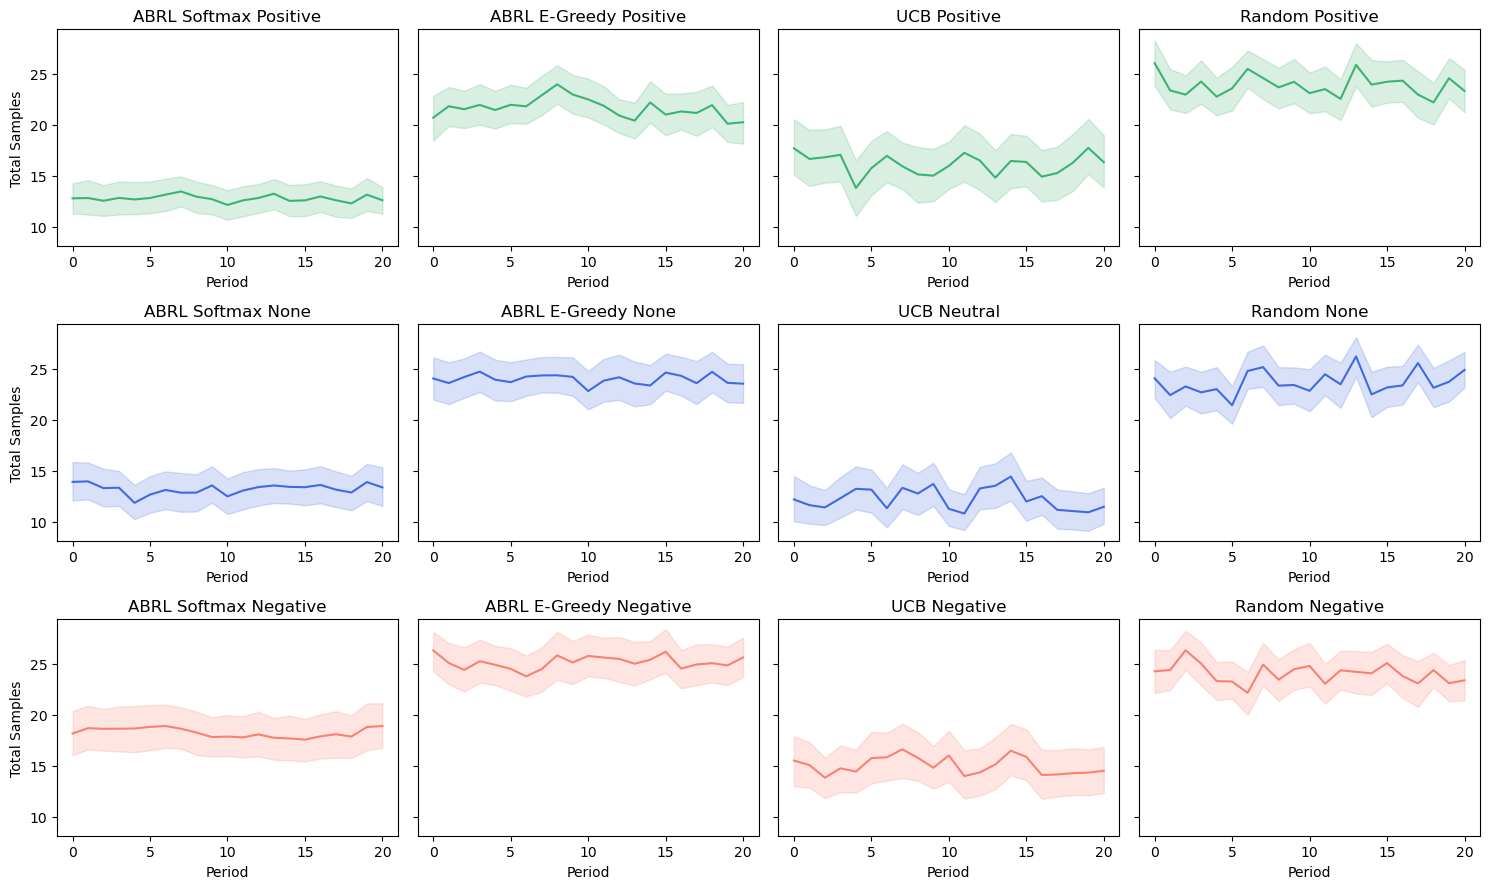

In [54]:
fig, axs = plt.subplots(3, 4, figsize=(15, 9), sharey=True) 
for i in range(3):  # iterating over externality types
    for j in range(4):  # iterating over agent types
        sns.lineplot(data = dataframes[i*4 + j], x='period', y='total_samples', color=colors[i*4 + j], ax=axs[i, j])
        axs[i, j].set_title(titles[i*4 + j])
        axs[i, j].set_xlabel('Period')
        axs[i, j].set_ylabel('Total Samples')
plt.tight_layout()

plt.savefig('RL_totalsamp.png', dpi=400)

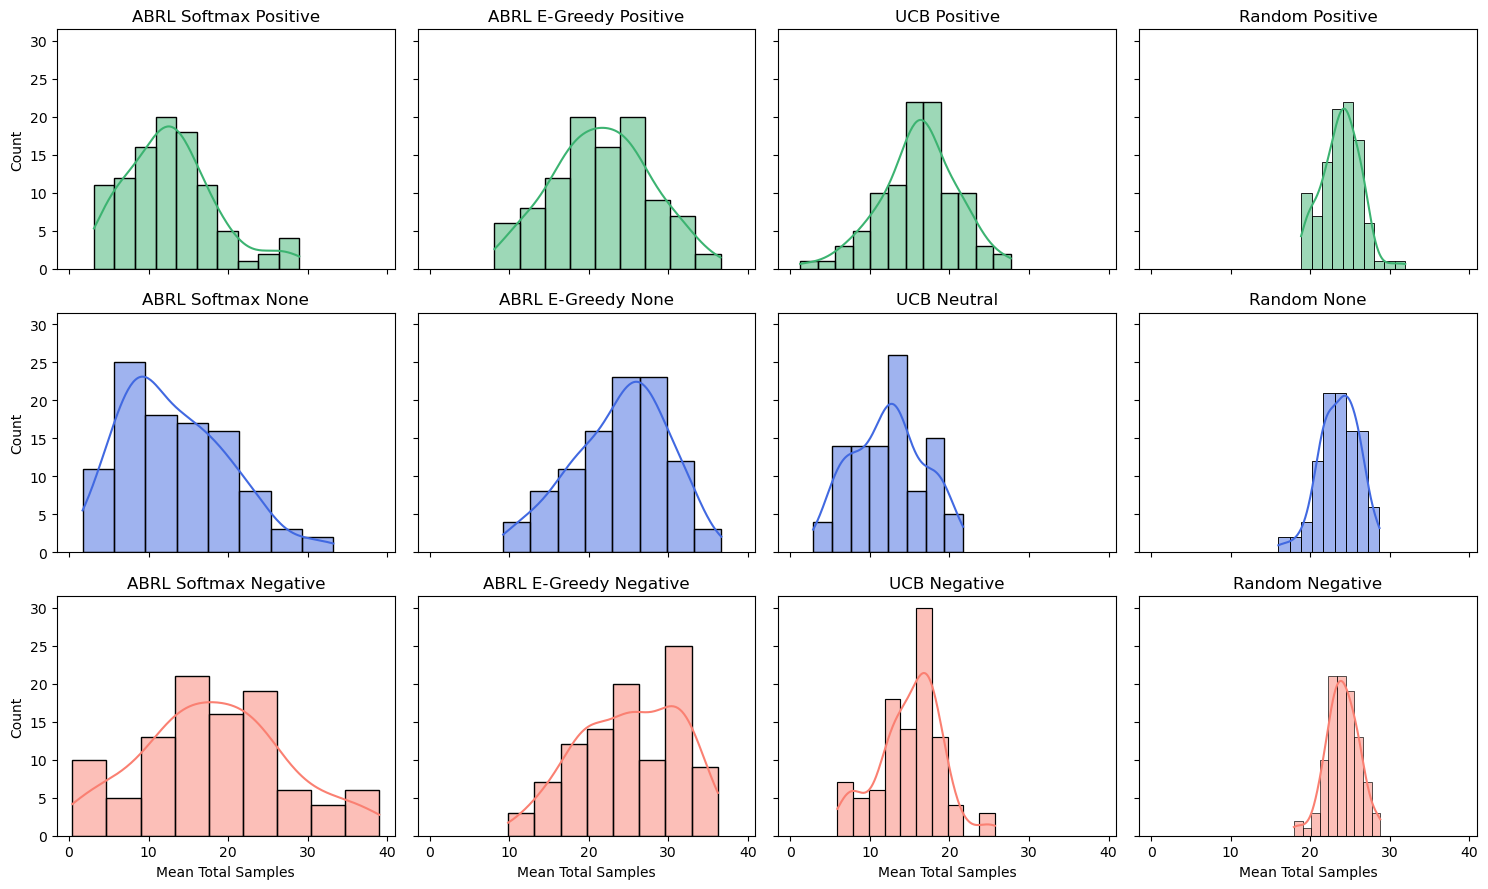

In [55]:
fig, axs = plt.subplots(3, 4, figsize=(15, 9), sharey=True, sharex=True) 
for i in range(3): 
    for j in range(4): 
        mean_total_samples = dataframes[i*4 + j].groupby('sim_nr')['total_samples'].mean()
        sns.histplot(data=mean_total_samples, kde=True, color=colors[i*4 + j], ax=axs[i, j])
        axs[i, j].set_title(titles[i*4 + j])
        axs[i, j].set_xlabel('Mean Total Samples')
plt.tight_layout()

plt.savefig('RL_totalsamphist.png', dpi=400)

##### Plots - Reward

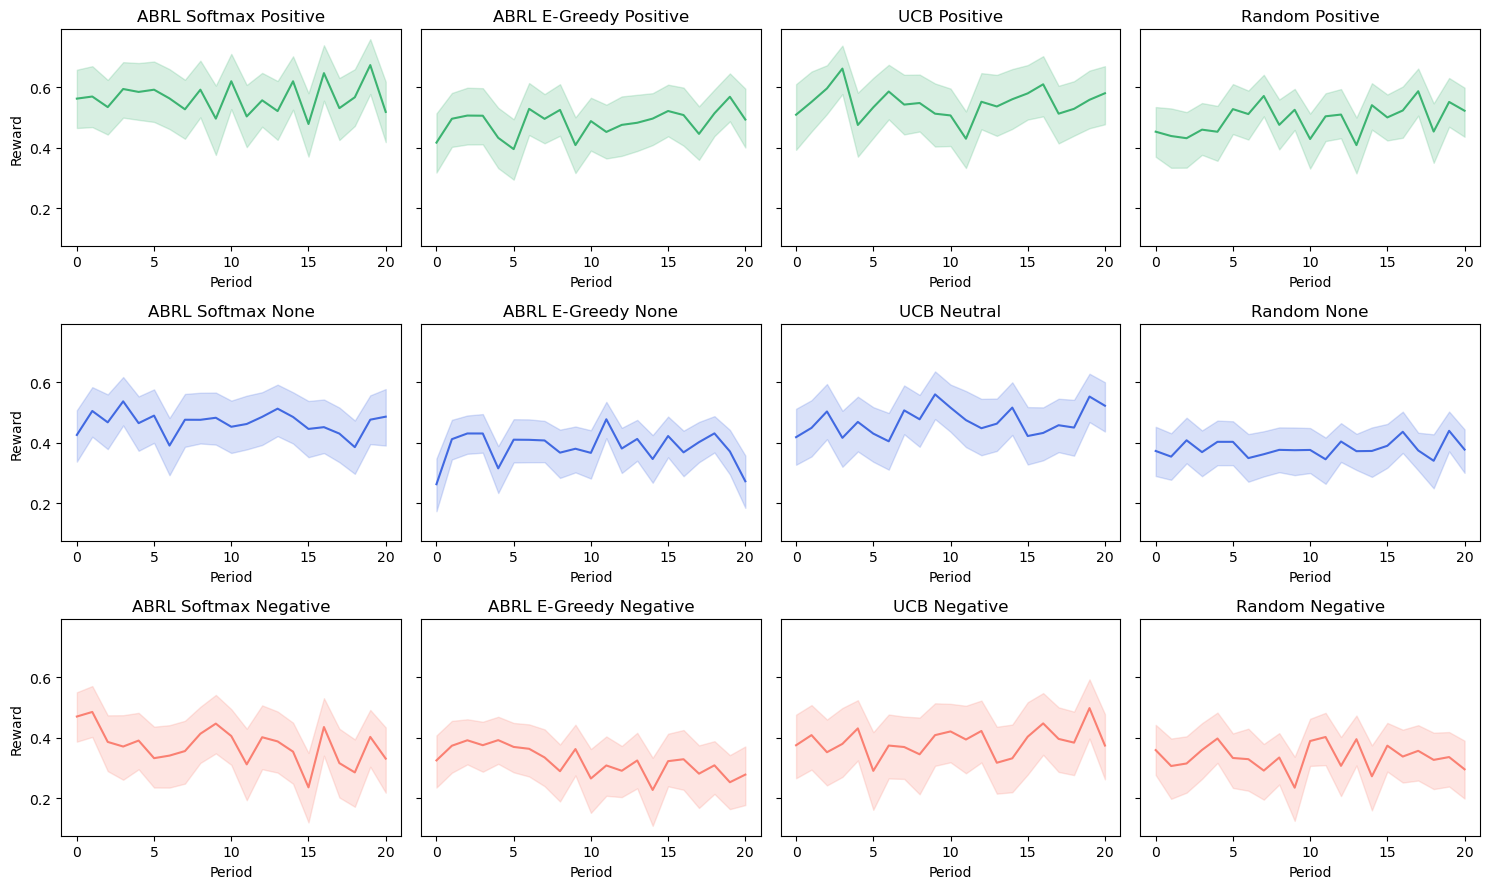

In [56]:
fig, axs = plt.subplots(3, 4, figsize=(15, 9), sharey=True) 
for i in range(3):  
    for j in range(4): 
        sns.lineplot(data = dataframes[i*4 + j], x='period', y='reward', color=colors[i*4 + j], ax=axs[i, j])
        axs[i, j].set_title(titles[i*4 + j])
        axs[i, j].set_xlabel('Period')
        axs[i, j].set_ylabel('Reward')
plt.tight_layout()

plt.savefig('RL_reward.png', dpi=400)

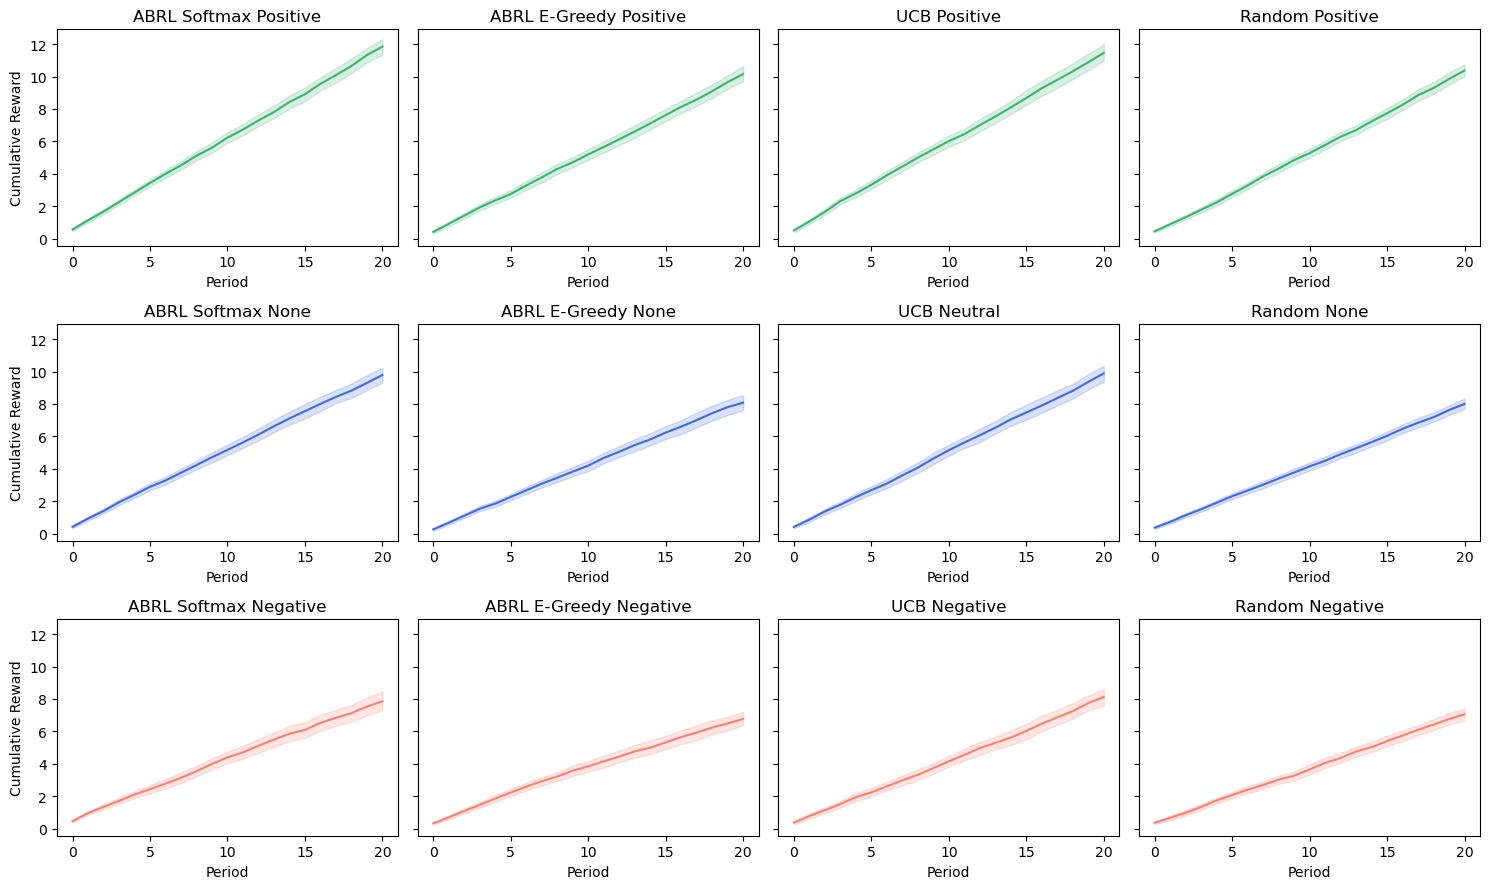

In [57]:
fig, axs = plt.subplots(3, 4, figsize=(15, 9), sharey=True) 
for i in range(3):  
    for j in range(4): 
        sns.lineplot(data = dataframes[i*4 + j], x='period', y='cum_reward', color=colors[i*4 + j], ax=axs[i, j])
        axs[i, j].set_title(titles[i*4 + j])
        axs[i, j].set_xlabel('Period')
        axs[i, j].set_ylabel('Cumulative Reward')
plt.tight_layout()

##### Summary

In [58]:
max_period = n_periods - 1

def calculate_metrics(df):
    condition = df['selected_computer'] == 'left'
    df['posterior_selected'] = np.where(condition, df['posterior_left'], df['posterior_right'])
    
    average_reward = df['reward'].mean()
    average_samples = df['total_samples'].mean()
    average_posterior = df['correct_answer'].mean()
    average_posterior_selected = df['posterior_selected'].mean()
    average_cumulative_reward = df[df['period'] == max_period].groupby('sim_nr')['cum_reward'].mean().mean()
    average_ext_realized = df['externality_realized'].mean()
    
    metrics = {
        'Method': df['Method'].iloc[0],
        'Externality Type': df['externality_type'].iloc[0],
        'Avg. Reward': average_reward,
        'Avg. Samples': average_samples,
        'Freq. Correct': average_posterior,
        'Avg. Posterior': average_posterior_selected,
        'Avg. Cumulative Reward': average_cumulative_reward,
        'Freq. Externalities': average_ext_realized
    }
    return metrics

summary_df = pd.DataFrame()

dataframes = [
    data_abrl_softmax_positive, data_abrl_softmax_neutral, data_abrl_softmax_negative,
    data_abrl_egreedy_positive, data_abrl_egreedy_neutral, data_abrl_egreedy_negative,
    data_ucb_positive, data_ucb_neutral, data_ucb_negative,
    data_random_positive, data_random_neutral, data_random_negative
]

for df in dataframes:
    metrics = calculate_metrics(df)
    summary_df = summary_df.append(metrics, ignore_index=True)

print('Metrics')
summary_df


Metrics


,Method,Externality Type,Avg. Reward,Avg. Samples,Freq. Correct,Avg. Posterior,Avg. Cumulative Reward,Freq. Externalities
0,ABRL Softmax,positive,0.563738,12.785714,0.720952,0.722112,11.83850,0.342857
1,ABRL Softmax,neutral,0.465764,13.230476,0.717143,0.725314,9.78104,0.000000
2,ABRL Softmax,negative,0.374169,18.264286,0.777143,0.773637,7.85755,0.111905
3,ABRL Softmax e-Greedy,positive,0.483266,21.651429,0.795714,0.802730,10.14858,0.395714
4,ABRL Softmax e-Greedy,neutral,0.384480,23.974762,0.840000,0.831465,8.07407,0.000000
5,ABRL Softmax e-Greedy,negative,0.322231,25.145714,0.837619,0.832207,6.76686,0.075238
6,UCB,positive,0.545710,16.134286,0.760476,0.743818,11.45992,0.367143
7,UCB,neutral,0.470652,12.271429,0.703810,0.705077,9.88370,0.000000
8,UCB,negative,0.386711,15.035238,0.744762,0.733238,8.12094,0.144762
9,Random,positive,0.493715,23.877143,0.841905,0.845630,10.36802,0.421905


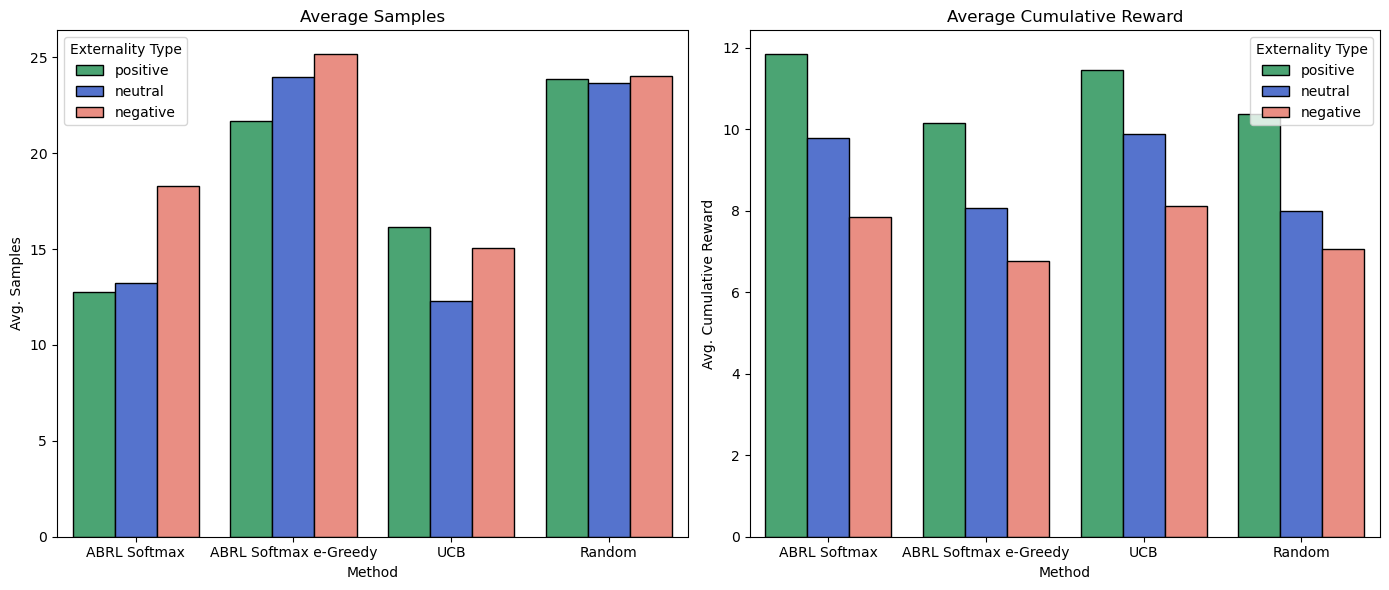

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(data=summary_df, x='Method', y='Avg. Samples', hue='Externality Type', 
            palette=palette, edgecolor="black", ax=axes[0])
axes[0].set_title('Average Samples')
sns.barplot(data=summary_df, x='Method', y='Avg. Cumulative Reward', hue='Externality Type', 
            palette=palette, edgecolor="black", ax=axes[1])
axes[1].set_title('Average Cumulative Reward')
plt.tight_layout()


----

Export RL Dataset

In [60]:
consolidate_and_export_dfs(dataframes, 'rl_df.csv')

data saved


In [45]:
summary_df_opt.to_csv('summary_df_opt.csv')